In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.layers import Dense, InputLayer, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import recall_score, make_scorer, roc_auc_score, accuracy_score, plot_roc_curve, f1_score, precision_score, confusion_matrix
sns.set_style("whitegrid")
sns.set_palette("Paired")

In [2]:
#open data set
df = pd.read_csv('../data/heart.csv')
#sum nan values
print(df.isna().sum())
print(df.dtypes)

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


/home/vladimir/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


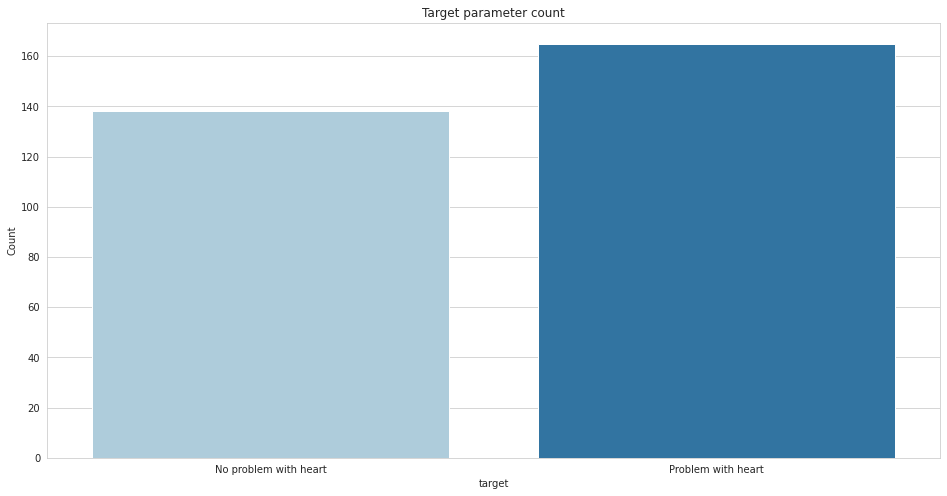

In [3]:
#show target count
plt.figure(figsize=(16, 8))
sns.countplot('target', data=df)
plt.xticks(ticks = [0, 1],labels=('No problem with heart', 'Problem with heart'))
plt.ylabel('Count')
plt.title('Target parameter count')
plt.show()

In [4]:
df['exang'] = df['exang'].apply(lambda x: 'yes' if x == 1 else 'no')
df['cp'] = df['cp'].apply(lambda x: 'typical_angina' if x == 1 else
                          'atypical_angina' if x == 2 else
                          'non_anginal_pain' if x == 3 else
                          'asymptomatic')
df['fbs'] = df['fbs'].apply(lambda x: 'lower_than_120mg/ml' if x == 0 else 'higher_than_120mg/ml')
df['restecg'] = df['restecg'].apply(lambda x: 'normal' if x == 0 else
                                    'st_t_wave abnormality' if x == 1 else
                                    'left_ventricular_hypertrophy')
df['sex'] = df['sex'].apply(lambda x: 'male' if x == 1 else 'female')
df['slope'] = df['slope'].apply(lambda x: 'upsloping' if x == 0 else 'flat' if x == 1 else 'downsloping')
df['thal'] = df['thal'].apply(lambda x: 'normal' if x == 1 else 'fixed_defect' if x == 2 else 'reversable_defect')

In [7]:
x = df.drop('target', axis=1)
y = df['target']
x = pd.get_dummies(x)
ct = ColumnTransformer([('scaled', StandardScaler(), x.columns)],
                       remainder='passthrough')

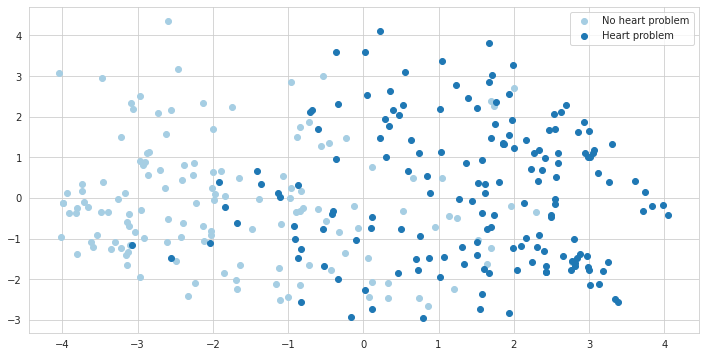

In [8]:
#show dataset
pca = PCA(n_components=2)
x_pca = pca.fit_transform(ct.fit_transform(x))
df_pca = pd.DataFrame(data=x_pca, columns=['1 component', '2 component'])
df_pca['target'] = y
df_pca_heart_problem = df_pca[df_pca['target'] == 1]
df_pca_no_heart_problem = df_pca[df_pca['target'] == 0]
plt.figure(figsize=(12, 6))
plt.scatter(df_pca_no_heart_problem.iloc[:, 0], df_pca_no_heart_problem.iloc[:, 1], label='No heart problem')
plt.scatter(df_pca_heart_problem.iloc[:, 0], df_pca_heart_problem.iloc[:, 1], label='Heart problem')
plt.legend()
plt.show()

In [9]:
#Train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)
x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.transform(x_test)

In [10]:
def keras_model(lr, neurons):
    model=Sequential()
    model.add(InputLayer(input_shape=(x.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['acc'])
    return model

model = KerasClassifier(build_fn=keras_model, epochs=20)

In [11]:
pd.set_option('display.max_rows', 100000)
params = dict(batch_size=[16, 32, 64, 128, 256], lr= [0.000001, 0.000001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
             neurons=[8, 16, 32, 64, 128, 256, 512])
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
scoring = dict(Recall= make_scorer(recall_score, average='micro'), F1=make_scorer(f1_score, average='macro'))
grid = GridSearchCV(model, params, return_train_score=True, scoring=scoring, refit=False)
grid.fit(x_train_scaled, y_train, callbacks=[es], validation_data=(x_test_scaled, y_test))
grid_result = pd.DataFrame(grid.cv_results_)

Epoch 1/20
13/13 [==============================] - 0s 8ms/step - loss: 0.8073 - acc: 0.3990 - val_loss: 0.8169 - val_acc: 0.4098
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.8073 - acc: 0.3990 - val_loss: 0.8168 - val_acc: 0.4098
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.8072 - acc: 0.3990 - val_loss: 0.8168 - val_acc: 0.4098
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.8072 - acc: 0.3990 - val_loss: 0.8167 - val_acc: 0.4098
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8071 - acc: 0.3990 - val_loss: 0.8167 - val_acc: 0.4098
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8071 - acc: 0.3990 - val_loss: 0.8166 - val_acc: 0.4098
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8070 - acc: 0.3990 - val_loss: 0.8166 - val_acc: 0.4098
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8070 - acc: 0.39

13/13 [==============================] - 0s 1ms/step - loss: 0.8007 - acc: 0.4948 - val_loss: 0.8202 - val_acc: 0.4426
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8006 - acc: 0.4948 - val_loss: 0.8201 - val_acc: 0.4426
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7889 - acc: 0.4536 - val_loss: 0.6727 - val_acc: 0.6066
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7888 - acc: 0.4485 - val_loss: 0.6726 - val_acc: 0.6066
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7887 - acc: 0.4485 - val_loss: 0.6726 - val_acc: 0.6066
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7887 - acc: 0.4485 - val_loss: 0.6725 - val_acc: 0.6066
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7886 - acc: 0.4485 - val_loss: 0.6725 - val_acc: 0.6066
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7886 - acc: 0.4485 - val_l

Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7557 - acc: 0.5596 - val_loss: 0.8040 - val_acc: 0.5082
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7556 - acc: 0.5596 - val_loss: 0.8039 - val_acc: 0.5082
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7556 - acc: 0.5596 - val_loss: 0.8039 - val_acc: 0.5082
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7555 - acc: 0.5596 - val_loss: 0.8038 - val_acc: 0.5082
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7554 - acc: 0.5596 - val_loss: 0.8037 - val_acc: 0.5082
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7554 - acc: 0.5596 - val_loss: 0.8037 - val_acc: 0.5082
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7553 - acc: 0.5596 - val_loss: 0.8036 - val_acc: 0.5082
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7553 - acc: 0.55

Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8449 - acc: 0.4278 - val_loss: 0.9033 - val_acc: 0.3770
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8448 - acc: 0.4278 - val_loss: 0.9031 - val_acc: 0.3770
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8447 - acc: 0.4278 - val_loss: 0.9030 - val_acc: 0.3770
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8446 - acc: 0.4278 - val_loss: 0.9029 - val_acc: 0.3770
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8445 - acc: 0.4278 - val_loss: 0.9028 - val_acc: 0.3770
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8444 - acc: 0.4278 - val_loss: 0.9027 - val_acc: 0.3770
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8443 - acc: 0.4278 - val_loss: 0.9026 - val_acc: 0.3770
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8442 - acc: 0

Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7797 - acc: 0.4845 - val_loss: 0.8534 - val_acc: 0.3934
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7796 - acc: 0.4845 - val_loss: 0.8533 - val_acc: 0.3934
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7795 - acc: 0.4845 - val_loss: 0.8531 - val_acc: 0.3934
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7794 - acc: 0.4845 - val_loss: 0.8530 - val_acc: 0.3934
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7793 - acc: 0.4845 - val_loss: 0.8529 - val_acc: 0.3934
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7792 - acc: 0.4845 - val_loss: 0.8527 - val_acc: 0.3934
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7790 - acc: 0.4845 - val_loss: 0.8526 - val_acc: 0.3934
Epoch 15/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7789 - acc

Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8728 - acc: 0.3161 - val_loss: 0.9137 - val_acc: 0.2459
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8726 - acc: 0.3161 - val_loss: 0.9135 - val_acc: 0.2459
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8724 - acc: 0.3161 - val_loss: 0.9133 - val_acc: 0.2459
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8722 - acc: 0.3161 - val_loss: 0.9131 - val_acc: 0.2459
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8721 - acc: 0.3161 - val_loss: 0.9129 - val_acc: 0.2459
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8719 - acc: 0.3161 - val_loss: 0.9127 - val_acc: 0.2459
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8717 - acc: 0.3161 - val_loss: 0.9125 - val_acc: 0.2459
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8715 - a

Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7096 - acc: 0.5567 - val_loss: 0.7848 - val_acc: 0.4426
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7094 - acc: 0.5567 - val_loss: 0.7846 - val_acc: 0.4426
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7093 - acc: 0.5567 - val_loss: 0.7844 - val_acc: 0.4426
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7091 - acc: 0.5567 - val_loss: 0.7842 - val_acc: 0.4426
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7090 - acc: 0.5567 - val_loss: 0.7840 - val_acc: 0.4426
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7088 - acc: 0.5567 - val_loss: 0.7838 - val_acc: 0.4426
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7087 - acc: 0.5567 - val_loss: 0.7836 - val_acc: 0.4426
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6165 - ac

Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6466 - acc: 0.6477 - val_loss: 0.6354 - val_acc: 0.6885
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6464 - acc: 0.6477 - val_loss: 0.6353 - val_acc: 0.6885
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6463 - acc: 0.6477 - val_loss: 0.6351 - val_acc: 0.6885
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6461 - acc: 0.6477 - val_loss: 0.6349 - val_acc: 0.6885
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7565 - acc: 0.3969 - val_loss: 0.7515 - val_acc: 0.4098
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7562 - acc: 0.3969 - val_loss: 0.7512 - val_acc: 0.4098
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7560 - acc: 0.3918 - val_loss: 0.7509 - val_acc: 0.4098
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7557 - acc: 

Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6807 - acc: 0.5722 - val_loss: 0.7233 - val_acc: 0.4426
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7169 - acc: 0.4663 - val_loss: 0.7013 - val_acc: 0.4754
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7165 - acc: 0.4663 - val_loss: 0.7009 - val_acc: 0.4754
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7162 - acc: 0.4663 - val_loss: 0.7006 - val_acc: 0.4754
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7158 - acc: 0.4663 - val_loss: 0.7002 - val_acc: 0.4754
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7155 - acc: 0.4663 - val_loss: 0.6998 - val_acc: 0.4754
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7152 - acc: 0.4663 - val_loss: 0.6995 - val_acc: 0.4754
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7149 - acc: 0.4

Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7139 - acc: 0.5103 - val_loss: 0.7153 - val_acc: 0.4098
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7136 - acc: 0.5103 - val_loss: 0.7149 - val_acc: 0.4098
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7132 - acc: 0.5103 - val_loss: 0.7145 - val_acc: 0.4098
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7128 - acc: 0.5103 - val_loss: 0.7141 - val_acc: 0.4098
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7125 - acc: 0.5103 - val_loss: 0.7137 - val_acc: 0.4098
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7121 - acc: 0.5155 - val_loss: 0.7133 - val_acc: 0.4098
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7118 - acc: 0.5155 - val_loss: 0.7129 - val_acc: 0.4098
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7114 - acc: 0.5

Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7104 - acc: 0.4456 - val_loss: 0.7342 - val_acc: 0.2951
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7100 - acc: 0.4456 - val_loss: 0.7338 - val_acc: 0.3115
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7096 - acc: 0.4456 - val_loss: 0.7333 - val_acc: 0.3279
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7091 - acc: 0.4456 - val_loss: 0.7328 - val_acc: 0.3279
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7086 - acc: 0.4456 - val_loss: 0.7323 - val_acc: 0.3279
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7082 - acc: 0.4508 - val_loss: 0.7318 - val_acc: 0.3279
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7078 - acc: 0.4508 - val_loss: 0.7313 - val_acc: 0.3443
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7073 - acc: 

Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6909 - acc: 0.5670 - val_loss: 0.7070 - val_acc: 0.5082
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6904 - acc: 0.5670 - val_loss: 0.7064 - val_acc: 0.5082
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6899 - acc: 0.5722 - val_loss: 0.7059 - val_acc: 0.5082
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6895 - acc: 0.5722 - val_loss: 0.7054 - val_acc: 0.5082
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6890 - acc: 0.5722 - val_loss: 0.7048 - val_acc: 0.5082
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6885 - acc: 0.5722 - val_loss: 0.7043 - val_acc: 0.5082
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6881 - acc: 0.5722 - val_loss: 0.7037 - val_acc: 0.5082
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6876 - ac

Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7563 - acc: 0.5619 - val_loss: 0.6985 - val_acc: 0.5738
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7562 - acc: 0.5619 - val_loss: 0.6985 - val_acc: 0.5738
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7562 - acc: 0.5619 - val_loss: 0.6984 - val_acc: 0.5738
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7561 - acc: 0.5619 - val_loss: 0.6984 - val_acc: 0.5738
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7561 - acc: 0.5619 - val_loss: 0.6983 - val_acc: 0.5738
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7560 - acc: 0.5619 - val_loss: 0.6983 - val_acc: 0.5738
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7560 - acc: 0.5619 - val_loss: 0.6982 - val_acc: 0.5738
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7559 - a

Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6905 - acc: 0.6010 - val_loss: 0.6201 - val_acc: 0.7213
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6905 - acc: 0.6010 - val_loss: 0.6200 - val_acc: 0.7213
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6904 - acc: 0.6010 - val_loss: 0.6200 - val_acc: 0.7213
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6904 - acc: 0.6010 - val_loss: 0.6199 - val_acc: 0.7213
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6903 - acc: 0.6010 - val_loss: 0.6199 - val_acc: 0.7213
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6902 - acc: 0.6010 - val_loss: 0.6198 - val_acc: 0.7213
Epoch 1/20
13/13 [==============================] - 0s 7ms/step - loss: 0.7880 - acc: 0.4093 - val_loss: 0.7702 - val_acc: 0.4098
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7879 - acc

Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7319 - acc: 0.5567 - val_loss: 0.7455 - val_acc: 0.6885
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7318 - acc: 0.5567 - val_loss: 0.7454 - val_acc: 0.6885
Epoch 20/20
13/13 [==============================] - ETA: 0s - loss: 0.8641 - acc: 0.500 - 0s 1ms/step - loss: 0.7317 - acc: 0.5567 - val_loss: 0.7453 - val_acc: 0.6885
Epoch 1/20
13/13 [==============================] - 0s 17ms/step - loss: 0.7391 - acc: 0.4794 - val_loss: 0.7881 - val_acc: 0.3934
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7391 - acc: 0.4794 - val_loss: 0.7880 - val_acc: 0.3934
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7390 - acc: 0.4794 - val_loss: 0.7880 - val_acc: 0.3934
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7389 - acc: 0.4794 - val_loss: 0.7879 - val_acc: 0.3934
Epoch 5/20
13/13 [==============================

13/13 [==============================] - 0s 2ms/step - loss: 0.8541 - acc: 0.4041 - val_loss: 0.9342 - val_acc: 0.3443
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.9960 - acc: 0.3608 - val_loss: 1.1466 - val_acc: 0.3934
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.9958 - acc: 0.3608 - val_loss: 1.1463 - val_acc: 0.3934
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.9956 - acc: 0.3608 - val_loss: 1.1461 - val_acc: 0.3934
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.9954 - acc: 0.3608 - val_loss: 1.1458 - val_acc: 0.3934
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.9952 - acc: 0.3608 - val_loss: 1.1456 - val_acc: 0.3934
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.9950 - acc: 0.3608 - val_loss: 1.1453 - val_acc: 0.3934
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.9948 - acc: 0.3660 - val_lo

Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8049 - acc: 0.4870 - val_loss: 0.7503 - val_acc: 0.4918
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8047 - acc: 0.4870 - val_loss: 0.7501 - val_acc: 0.4918
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8045 - acc: 0.4870 - val_loss: 0.7500 - val_acc: 0.4918
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8043 - acc: 0.4870 - val_loss: 0.7498 - val_acc: 0.4918
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8041 - acc: 0.4870 - val_loss: 0.7496 - val_acc: 0.4918
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8040 - acc: 0.4870 - val_loss: 0.7495 - val_acc: 0.4918
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8038 - acc: 0.4870 - val_loss: 0.7493 - val_acc: 0.4918
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8037 - acc: 0.4

Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7516 - acc: 0.4227 - val_loss: 0.7563 - val_acc: 0.4262
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7514 - acc: 0.4227 - val_loss: 0.7561 - val_acc: 0.4262
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7512 - acc: 0.4227 - val_loss: 0.7559 - val_acc: 0.4262
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7511 - acc: 0.4227 - val_loss: 0.7557 - val_acc: 0.4262
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7509 - acc: 0.4227 - val_loss: 0.7556 - val_acc: 0.4262
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7507 - acc: 0.4227 - val_loss: 0.7554 - val_acc: 0.4262
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7506 - acc: 0.4227 - val_loss: 0.7552 - val_acc: 0.4262
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7504 - acc: 

Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8107 - acc: 0.4041 - val_loss: 0.8230 - val_acc: 0.3934
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8104 - acc: 0.4041 - val_loss: 0.8227 - val_acc: 0.3934
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8102 - acc: 0.4041 - val_loss: 0.8224 - val_acc: 0.3934
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8099 - acc: 0.4041 - val_loss: 0.8221 - val_acc: 0.3934
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8096 - acc: 0.4041 - val_loss: 0.8219 - val_acc: 0.3934
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8094 - acc: 0.4041 - val_loss: 0.8216 - val_acc: 0.3934
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8091 - acc: 0.4041 - val_loss: 0.8214 - val_acc: 0.3934
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8089 - ac

Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5980 - acc: 0.7577 - val_loss: 0.6158 - val_acc: 0.6557
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5979 - acc: 0.7577 - val_loss: 0.6156 - val_acc: 0.6557
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5977 - acc: 0.7577 - val_loss: 0.6154 - val_acc: 0.6557
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5975 - acc: 0.7577 - val_loss: 0.6152 - val_acc: 0.6557
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5974 - acc: 0.7577 - val_loss: 0.6151 - val_acc: 0.6557
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5972 - acc: 0.7577 - val_loss: 0.6149 - val_acc: 0.6557
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5970 - acc: 0.7577 - val_loss: 0.6147 - val_acc: 0.6557
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5969 - a

Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6765 - acc: 0.5876 - val_loss: 0.7062 - val_acc: 0.5410
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6762 - acc: 0.5876 - val_loss: 0.7058 - val_acc: 0.5410
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6759 - acc: 0.5876 - val_loss: 0.7055 - val_acc: 0.5410
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6756 - acc: 0.5876 - val_loss: 0.7051 - val_acc: 0.5410
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6753 - acc: 0.5876 - val_loss: 0.7047 - val_acc: 0.5410
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6750 - acc: 0.5876 - val_loss: 0.7044 - val_acc: 0.5410
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7036 - acc: 0.4639 - val_loss: 0.7043 - val_acc: 0.4426
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7033 - acc

Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6933 - acc: 0.5389 - val_loss: 0.7012 - val_acc: 0.5246
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6929 - acc: 0.5389 - val_loss: 0.7007 - val_acc: 0.5246
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6925 - acc: 0.5389 - val_loss: 0.7003 - val_acc: 0.5246
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6995 - acc: 0.5389 - val_loss: 0.7010 - val_acc: 0.5082
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6990 - acc: 0.5389 - val_loss: 0.7004 - val_acc: 0.5082
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6986 - acc: 0.5389 - val_loss: 0.6999 - val_acc: 0.5082
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6981 - acc: 0.5389 - val_loss: 0.6994 - val_acc: 0.5082
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6977 - acc: 0

13/13 [==============================] - 0s 1ms/step - loss: 0.7230 - acc: 0.4175 - val_loss: 0.7316 - val_acc: 0.4590
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7486 - acc: 0.4536 - val_loss: 0.7348 - val_acc: 0.4754
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7480 - acc: 0.4536 - val_loss: 0.7343 - val_acc: 0.4754
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7475 - acc: 0.4536 - val_loss: 0.7337 - val_acc: 0.4754
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7470 - acc: 0.4536 - val_loss: 0.7332 - val_acc: 0.4754
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7465 - acc: 0.4536 - val_loss: 0.7327 - val_acc: 0.4754
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7459 - acc: 0.4536 - val_loss: 0.7322 - val_acc: 0.4754
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7455 - acc: 0.4536 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 1.1008 - acc: 0.2990 - val_loss: 1.0673 - val_acc: 0.3607
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0894 - acc: 0.3041 - val_loss: 1.0581 - val_acc: 0.3770
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0785 - acc: 0.3041 - val_loss: 1.0484 - val_acc: 0.3934
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0672 - acc: 0.3093 - val_loss: 1.0389 - val_acc: 0.4098
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0564 - acc: 0.3144 - val_loss: 1.0296 - val_acc: 0.4098
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0455 - acc: 0.3196 - val_loss: 1.0202 - val_acc: 0.4262
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0351 - acc: 0.3247 - val_loss: 1.0110 - val_acc: 0.4262
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0247 - acc: 0.3247 - val_lo

Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5933 - acc: 0.7202 - val_loss: 0.5721 - val_acc: 0.7541
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5890 - acc: 0.7306 - val_loss: 0.5670 - val_acc: 0.7705
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5843 - acc: 0.7306 - val_loss: 0.5623 - val_acc: 0.7705
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5798 - acc: 0.7358 - val_loss: 0.5578 - val_acc: 0.7541
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5754 - acc: 0.7409 - val_loss: 0.5537 - val_acc: 0.7869
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5713 - acc: 0.7461 - val_loss: 0.5491 - val_acc: 0.7705
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5670 - acc: 0.7409 - val_loss: 0.5445 - val_acc: 0.7869
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5625 - acc: 0

Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7017 - acc: 0.6031 - val_loss: 0.6833 - val_acc: 0.6230
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6958 - acc: 0.6082 - val_loss: 0.6761 - val_acc: 0.6230
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6897 - acc: 0.6082 - val_loss: 0.6699 - val_acc: 0.6230
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6846 - acc: 0.6134 - val_loss: 0.6637 - val_acc: 0.6230
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6793 - acc: 0.6134 - val_loss: 0.6580 - val_acc: 0.6066
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6742 - acc: 0.6134 - val_loss: 0.6523 - val_acc: 0.6066
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6689 - acc: 0.6134 - val_loss: 0.6466 - val_acc: 0.6066
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6638 - acc

Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7500 - acc: 0.4560 - val_loss: 0.6909 - val_acc: 0.5082
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7389 - acc: 0.4560 - val_loss: 0.6816 - val_acc: 0.5082
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7289 - acc: 0.4715 - val_loss: 0.6725 - val_acc: 0.5246
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7185 - acc: 0.5026 - val_loss: 0.6630 - val_acc: 0.5574
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7085 - acc: 0.5130 - val_loss: 0.6542 - val_acc: 0.5574
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6989 - acc: 0.5233 - val_loss: 0.6454 - val_acc: 0.5738
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6897 - acc: 0.5492 - val_loss: 0.6374 - val_acc: 0.5738
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6810 - a

Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6794 - acc: 0.6031 - val_loss: 0.5888 - val_acc: 0.7213
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6715 - acc: 0.6186 - val_loss: 0.5825 - val_acc: 0.7213
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6641 - acc: 0.6392 - val_loss: 0.5763 - val_acc: 0.7377
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6571 - acc: 0.6546 - val_loss: 0.5705 - val_acc: 0.7377
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6501 - acc: 0.6649 - val_loss: 0.5645 - val_acc: 0.7377
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6433 - acc: 0.6701 - val_loss: 0.5587 - val_acc: 0.7377
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6364 - acc: 0.6701 - val_loss: 0.5530 - val_acc: 0.7541
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6692 - ac

Epoch 17/20
13/13 [==============================] - 0s 2ms/step - loss: 0.5936 - acc: 0.6804 - val_loss: 0.5371 - val_acc: 0.7377
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5833 - acc: 0.7062 - val_loss: 0.5263 - val_acc: 0.7377
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5732 - acc: 0.7165 - val_loss: 0.5156 - val_acc: 0.7377
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5633 - acc: 0.7268 - val_loss: 0.5053 - val_acc: 0.7377
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.8808 - acc: 0.3969 - val_loss: 0.8354 - val_acc: 0.4918
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8578 - acc: 0.4124 - val_loss: 0.8150 - val_acc: 0.4918
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8377 - acc: 0.4433 - val_loss: 0.7953 - val_acc: 0.4918
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8166 - acc: 

Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4459 - acc: 0.8187 - val_loss: 0.4349 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7341 - acc: 0.4974 - val_loss: 0.7643 - val_acc: 0.4754
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7077 - acc: 0.5596 - val_loss: 0.7341 - val_acc: 0.5410
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6865 - acc: 0.5907 - val_loss: 0.7077 - val_acc: 0.5574
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6660 - acc: 0.6321 - val_loss: 0.6827 - val_acc: 0.5738
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6464 - acc: 0.6684 - val_loss: 0.6588 - val_acc: 0.5902
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6305 - acc: 0.6788 - val_loss: 0.6401 - val_acc: 0.6393
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6165 - acc: 0.6

Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6764 - acc: 0.5979 - val_loss: 0.6305 - val_acc: 0.6066
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6557 - acc: 0.6289 - val_loss: 0.6128 - val_acc: 0.6230
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6362 - acc: 0.6443 - val_loss: 0.5956 - val_acc: 0.6721
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6186 - acc: 0.6701 - val_loss: 0.5807 - val_acc: 0.6885
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6016 - acc: 0.6959 - val_loss: 0.5655 - val_acc: 0.7377
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5858 - acc: 0.7165 - val_loss: 0.5510 - val_acc: 0.7377
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5699 - acc: 0.7216 - val_loss: 0.5382 - val_acc: 0.7377
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5568 - acc: 0.7

Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5590 - acc: 0.7732 - val_loss: 0.5403 - val_acc: 0.8197
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5390 - acc: 0.7835 - val_loss: 0.5208 - val_acc: 0.8197
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5210 - acc: 0.8247 - val_loss: 0.5027 - val_acc: 0.8197
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5051 - acc: 0.8351 - val_loss: 0.4858 - val_acc: 0.8033
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4903 - acc: 0.8351 - val_loss: 0.4718 - val_acc: 0.8197
Epoch 11/20
13/13 [==============================] - 0s 2ms/step - loss: 0.4778 - acc: 0.8402 - val_loss: 0.4593 - val_acc: 0.8197
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4663 - acc: 0.8402 - val_loss: 0.4480 - val_acc: 0.8197
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4557 - acc: 

Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4473 - acc: 0.8394 - val_loss: 0.4106 - val_acc: 0.8689
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4353 - acc: 0.8446 - val_loss: 0.4003 - val_acc: 0.8689
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4247 - acc: 0.8497 - val_loss: 0.3916 - val_acc: 0.8689
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4154 - acc: 0.8497 - val_loss: 0.3829 - val_acc: 0.8689
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4064 - acc: 0.8497 - val_loss: 0.3747 - val_acc: 0.8852
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3980 - acc: 0.8497 - val_loss: 0.3675 - val_acc: 0.8852
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3909 - acc: 0.8497 - val_loss: 0.3622 - val_acc: 0.8852
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3841 - ac

Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4312 - acc: 0.8351 - val_loss: 0.4181 - val_acc: 0.8689
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4222 - acc: 0.8402 - val_loss: 0.4100 - val_acc: 0.8689
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4140 - acc: 0.8351 - val_loss: 0.4017 - val_acc: 0.8689
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4068 - acc: 0.8351 - val_loss: 0.3943 - val_acc: 0.8689
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4001 - acc: 0.8351 - val_loss: 0.3889 - val_acc: 0.8689
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3939 - acc: 0.8351 - val_loss: 0.3832 - val_acc: 0.8689
Epoch 18/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3884 - acc: 0.8402 - val_loss: 0.3792 - val_acc: 0.8689
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3836 - a

Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4738 - acc: 0.7720 - val_loss: 0.4256 - val_acc: 0.8197
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4649 - acc: 0.7720 - val_loss: 0.4163 - val_acc: 0.8197
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4565 - acc: 0.7824 - val_loss: 0.4085 - val_acc: 0.8197
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4496 - acc: 0.7772 - val_loss: 0.3998 - val_acc: 0.8197
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4424 - acc: 0.7876 - val_loss: 0.3941 - val_acc: 0.8197
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4369 - acc: 0.7927 - val_loss: 0.3871 - val_acc: 0.8197
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7466 - acc: 0.5979 - val_loss: 0.6968 - val_acc: 0.6557
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6764 - acc

Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4710 - acc: 0.7784 - val_loss: 0.3936 - val_acc: 0.8689
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4623 - acc: 0.7938 - val_loss: 0.3839 - val_acc: 0.8689
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4550 - acc: 0.7938 - val_loss: 0.3758 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.8687 - acc: 0.3990 - val_loss: 0.7440 - val_acc: 0.5574
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8020 - acc: 0.4301 - val_loss: 0.6894 - val_acc: 0.5574
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7460 - acc: 0.4922 - val_loss: 0.6417 - val_acc: 0.6393
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6948 - acc: 0.5544 - val_loss: 0.6016 - val_acc: 0.6721
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6511 - acc: 0

Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.8843 - acc: 0.4794 - val_loss: 0.8633 - val_acc: 0.5082
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7857 - acc: 0.5825 - val_loss: 0.7577 - val_acc: 0.5738
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.7147 - acc: 0.6237 - val_loss: 0.6707 - val_acc: 0.6557
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6518 - acc: 0.6856 - val_loss: 0.6057 - val_acc: 0.6885
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6085 - acc: 0.7113 - val_loss: 0.5595 - val_acc: 0.7541
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5698 - acc: 0.7268 - val_loss: 0.5193 - val_acc: 0.7705
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5385 - acc: 0.7423 - val_loss: 0.4839 - val_acc: 0.7869
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5113 - acc: 0.75

Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5398 - acc: 0.7565 - val_loss: 0.4470 - val_acc: 0.8852
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5032 - acc: 0.7927 - val_loss: 0.4179 - val_acc: 0.8689
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4764 - acc: 0.8135 - val_loss: 0.3944 - val_acc: 0.9016
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4543 - acc: 0.8187 - val_loss: 0.3755 - val_acc: 0.9016
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4351 - acc: 0.8187 - val_loss: 0.3593 - val_acc: 0.9016
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4190 - acc: 0.8342 - val_loss: 0.3498 - val_acc: 0.8852
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4076 - acc: 0.8394 - val_loss: 0.3455 - val_acc: 0.8852
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3978 - acc: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.4284 - acc: 0.8093 - val_loss: 0.3959 - val_acc: 0.8197
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4061 - acc: 0.8196 - val_loss: 0.3785 - val_acc: 0.8361
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3907 - acc: 0.8402 - val_loss: 0.3647 - val_acc: 0.8361
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3779 - acc: 0.8454 - val_loss: 0.3555 - val_acc: 0.8525
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3682 - acc: 0.8557 - val_loss: 0.3486 - val_acc: 0.8689
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3607 - acc: 0.8608 - val_loss: 0.3450 - val_acc: 0.8689
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3540 - acc: 0.8660 - val_loss: 0.3420 - val_acc: 0.8689
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3477 - acc: 0.8711 - va

13/13 [==============================] - 0s 1ms/step - loss: 0.2922 - acc: 0.8918 - val_loss: 0.3358 - val_acc: 0.9016
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2869 - acc: 0.8969 - val_loss: 0.3355 - val_acc: 0.8852
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2813 - acc: 0.8969 - val_loss: 0.3299 - val_acc: 0.8852
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2765 - acc: 0.9021 - val_loss: 0.3297 - val_acc: 0.8852
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2714 - acc: 0.9021 - val_loss: 0.3283 - val_acc: 0.8852
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2666 - acc: 0.9021 - val_loss: 0.3294 - val_acc: 0.8852
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2620 - acc: 0.9072 - val_loss: 0.3293 - val_acc: 0.8852
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.6635 - acc: 0.6134 - 

Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4736 - acc: 0.8031 - val_loss: 0.3936 - val_acc: 0.8689
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4130 - acc: 0.8290 - val_loss: 0.3565 - val_acc: 0.8689
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3807 - acc: 0.8446 - val_loss: 0.3388 - val_acc: 0.8852
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3576 - acc: 0.8394 - val_loss: 0.3331 - val_acc: 0.9016
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3416 - acc: 0.8446 - val_loss: 0.3286 - val_acc: 0.9016
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3288 - acc: 0.8549 - val_loss: 0.3265 - val_acc: 0.8852
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3181 - acc: 0.8497 - val_loss: 0.3263 - val_acc: 0.8852
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3115 - acc: 0.86

Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3326 - acc: 0.8653 - val_loss: 0.3179 - val_acc: 0.8689
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3128 - acc: 0.8653 - val_loss: 0.3192 - val_acc: 0.8852
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2981 - acc: 0.8912 - val_loss: 0.3141 - val_acc: 0.8852
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2842 - acc: 0.9016 - val_loss: 0.3017 - val_acc: 0.8852
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2719 - acc: 0.9016 - val_loss: 0.3036 - val_acc: 0.8852
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2627 - acc: 0.9067 - val_loss: 0.3038 - val_acc: 0.9016
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2518 - acc: 0.9119 - val_loss: 0.3081 - val_acc: 0.9180
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2443 - acc: 0.

Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2820 - acc: 0.8814 - val_loss: 0.3476 - val_acc: 0.8852
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2728 - acc: 0.8866 - val_loss: 0.3614 - val_acc: 0.8689
Epoch 11/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2649 - acc: 0.8969 - val_loss: 0.3555 - val_acc: 0.8852
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2563 - acc: 0.9021 - val_loss: 0.3586 - val_acc: 0.8852
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2503 - acc: 0.9124 - val_loss: 0.3550 - val_acc: 0.9016
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2436 - acc: 0.9124 - val_loss: 0.3636 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5676 - acc: 0.7150 - val_loss: 0.4041 - val_acc: 0.8852
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3881 - acc:

Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2564 - acc: 0.8964 - val_loss: 0.3101 - val_acc: 0.9016
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2460 - acc: 0.9067 - val_loss: 0.3168 - val_acc: 0.8852
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2365 - acc: 0.9171 - val_loss: 0.3175 - val_acc: 0.9016
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5827 - acc: 0.6943 - val_loss: 0.3421 - val_acc: 0.8689
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4060 - acc: 0.7979 - val_loss: 0.3237 - val_acc: 0.8525
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3732 - acc: 0.8394 - val_loss: 0.3154 - val_acc: 0.8525
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3440 - acc: 0.8601 - val_loss: 0.3032 - val_acc: 0.8852
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3277 - acc: 0.8

Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3245 - acc: 0.8446 - val_loss: 0.3479 - val_acc: 0.8689
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2948 - acc: 0.8705 - val_loss: 0.3651 - val_acc: 0.8852
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2872 - acc: 0.8705 - val_loss: 0.3764 - val_acc: 0.8852
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2732 - acc: 0.8601 - val_loss: 0.3706 - val_acc: 0.8852
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2688 - acc: 0.8601 - val_loss: 0.3628 - val_acc: 0.8689
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2612 - acc: 0.8653 - val_loss: 0.3780 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 7ms/step - loss: 0.6424 - acc: 0.6237 - val_loss: 0.3547 - val_acc: 0.8852
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3726 - acc: 0.84

Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.1705 - acc: 0.9330 - val_loss: 0.3531 - val_acc: 0.8852
Epoch 11/20
13/13 [==============================] - 0s 2ms/step - loss: 0.1556 - acc: 0.9536 - val_loss: 0.3542 - val_acc: 0.8852
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.1519 - acc: 0.9588 - val_loss: 0.3233 - val_acc: 0.8852
Epoch 1/20
13/13 [==============================] - 0s 20ms/step - loss: 0.4719 - acc: 0.7629 - val_loss: 0.3687 - val_acc: 0.8689
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3492 - acc: 0.8454 - val_loss: 0.3525 - val_acc: 0.8689
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3144 - acc: 0.8608 - val_loss: 0.3244 - val_acc: 0.8689
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.2912 - acc: 0.8814 - val_loss: 0.3332 - val_acc: 0.8689
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.2690 - acc: 

Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2118 - acc: 0.9275 - val_loss: 0.3684 - val_acc: 0.8852
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2304 - acc: 0.9223 - val_loss: 0.3752 - val_acc: 0.8852
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2638 - acc: 0.8964 - val_loss: 0.4043 - val_acc: 0.8525
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2370 - acc: 0.9171 - val_loss: 0.4057 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4756 - acc: 0.7617 - val_loss: 0.3205 - val_acc: 0.8689
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3612 - acc: 0.8653 - val_loss: 0.3076 - val_acc: 0.8852
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2804 - acc: 0.8808 - val_loss: 0.3111 - val_acc: 0.9016
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2852 - acc: 0.85

13/13 [==============================] - 0s 1ms/step - loss: 0.2024 - acc: 0.9381 - val_loss: 0.4519 - val_acc: 0.8525
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.4855 - acc: 0.7668 - val_loss: 0.4401 - val_acc: 0.8525
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3261 - acc: 0.8808 - val_loss: 0.2933 - val_acc: 0.8852
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2958 - acc: 0.8705 - val_loss: 0.3687 - val_acc: 0.9180
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2266 - acc: 0.9016 - val_loss: 0.3592 - val_acc: 0.9016
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.1803 - acc: 0.9585 - val_loss: 0.3842 - val_acc: 0.8689
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.1689 - acc: 0.9430 - val_loss: 0.4487 - val_acc: 0.8361
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.1348 - acc: 0.9637 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 0.3967 - acc: 0.7784 - val_loss: 0.4556 - val_acc: 0.8525
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3530 - acc: 0.8299 - val_loss: 0.5598 - val_acc: 0.8033
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3221 - acc: 0.8660 - val_loss: 0.4912 - val_acc: 0.8689
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2823 - acc: 0.8763 - val_loss: 0.4552 - val_acc: 0.8525
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2660 - acc: 0.8918 - val_loss: 0.4603 - val_acc: 0.8525
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2474 - acc: 0.9021 - val_loss: 0.5687 - val_acc: 0.8361
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2282 - acc: 0.9072 - val_loss: 0.6151 - val_acc: 0.8361
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2305 - acc: 0.9021 - val_lo

13/13 [==============================] - 0s 2ms/step - loss: 0.2188 - acc: 0.8969 - val_loss: 0.9633 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5845 - acc: 0.7113 - val_loss: 0.4177 - val_acc: 0.8361
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5523 - acc: 0.8247 - val_loss: 0.6386 - val_acc: 0.8197
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4074 - acc: 0.8351 - val_loss: 0.5950 - val_acc: 0.7705
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3034 - acc: 0.8351 - val_loss: 0.4137 - val_acc: 0.8852
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2788 - acc: 0.8814 - val_loss: 0.5414 - val_acc: 0.7869
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2253 - acc: 0.9021 - val_loss: 0.5211 - val_acc: 0.8361
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2547 - acc: 0.9072 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 0.9358 - acc: 0.7979 - val_loss: 0.5846 - val_acc: 0.8689
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.9661 - acc: 0.8238 - val_loss: 2.2708 - val_acc: 0.7869
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 1.1167 - acc: 0.8135 - val_loss: 1.3505 - val_acc: 0.8361
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0373 - acc: 0.8135 - val_loss: 2.1309 - val_acc: 0.8033
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 2.3283 - acc: 0.8808 - val_loss: 4.3325 - val_acc: 0.8689
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 1.7549 - acc: 0.8808 - val_loss: 2.1929 - val_acc: 0.7869
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 1.0323 - acc: 0.7254 - val_loss: 1.9571 - val_acc: 0.5082
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 1.3328 - acc: 0.7617 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 1.9055 - acc: 0.8144 - val_loss: 1.9752 - val_acc: 0.8689
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 2.4337 - acc: 0.8196 - val_loss: 5.1745 - val_acc: 0.7705
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 2.4782 - acc: 0.8196 - val_loss: 4.4673 - val_acc: 0.8361
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 1.8176 - acc: 0.8918 - val_loss: 2.4743 - val_acc: 0.8033
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 1.3003 - acc: 0.8608 - val_loss: 3.4857 - val_acc: 0.8852
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 1.4454 - acc: 0.7320 - val_loss: 1.9419 - val_acc: 0.6393
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 1.1492 - acc: 0.7732 - val_loss: 2.6555 - val_acc: 0.7541
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 1.7351 - acc: 0.7990 - val_lo

13/13 [==============================] - 0s 6ms/step - loss: 0.5512 - acc: 0.7254 - val_loss: 0.6106 - val_acc: 0.8689
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5021 - acc: 0.8342 - val_loss: 0.5413 - val_acc: 0.7541
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3897 - acc: 0.8238 - val_loss: 0.4798 - val_acc: 0.8525
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3540 - acc: 0.8394 - val_loss: 0.3152 - val_acc: 0.8689
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2949 - acc: 0.8705 - val_loss: 0.4491 - val_acc: 0.8689
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4618 - acc: 0.8653 - val_loss: 0.6430 - val_acc: 0.8197
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4254 - acc: 0.8705 - val_loss: 0.3664 - val_acc: 0.8689
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2936 - acc: 0.8705 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 0.5746 - acc: 0.7979 - val_loss: 0.7578 - val_acc: 0.8852
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5395 - acc: 0.8342 - val_loss: 0.4377 - val_acc: 0.8361
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3538 - acc: 0.8601 - val_loss: 0.6425 - val_acc: 0.8525
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8418 - acc: 0.7927 - val_loss: 2.2612 - val_acc: 0.7705
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5618 - acc: 0.8342 - val_loss: 1.1305 - val_acc: 0.8033
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.6680 - acc: 0.8083 - val_loss: 3.1900 - val_acc: 0.7541
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.8922 - acc: 0.8290 - val_loss: 1.3527 - val_acc: 0.8361
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7484 - acc: 0.7526 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 0.6956 - acc: 0.8402 - val_loss: 1.9306 - val_acc: 0.7705
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.9734 - acc: 0.8505 - val_loss: 1.9608 - val_acc: 0.7541
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 1.0293 - acc: 0.8093 - val_loss: 2.4192 - val_acc: 0.8689
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.9131 - acc: 0.8454 - val_loss: 1.7019 - val_acc: 0.7705
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.5066 - acc: 0.8608 - val_loss: 1.1859 - val_acc: 0.8197
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 1.2177 - acc: 0.6804 - val_loss: 1.4124 - val_acc: 0.7213
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 1.2925 - acc: 0.7577 - val_loss: 2.7432 - val_acc: 0.7377
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 1.7253 - acc: 0.7938 - val_lo

13/13 [==============================] - 0s 1ms/step - loss: 3.1397 - acc: 0.8497 - val_loss: 6.3668 - val_acc: 0.8689
Epoch 9/20
13/13 [==============================] - 0s 2ms/step - loss: 2.8242 - acc: 0.8653 - val_loss: 9.8331 - val_acc: 0.8197
Epoch 10/20
13/13 [==============================] - 0s 2ms/step - loss: 2.3438 - acc: 0.9016 - val_loss: 9.6942 - val_acc: 0.8689
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 4.6532 - acc: 0.6632 - val_loss: 6.2313 - val_acc: 0.6230
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 5.0522 - acc: 0.7772 - val_loss: 2.7600 - val_acc: 0.8361
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 3.1118 - acc: 0.8187 - val_loss: 3.0484 - val_acc: 0.8689
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 1.3344 - acc: 0.8497 - val_loss: 2.5734 - val_acc: 0.8689
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 1.3319 - acc: 0.8912 - val_l

Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 2.9576 - acc: 0.8454 - val_loss: 6.2828 - val_acc: 0.8033
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 10.5360 - acc: 0.7835 - val_loss: 22.0424 - val_acc: 0.7541
Epoch 8/20
13/13 [==============================] - 0s 2ms/step - loss: 9.0817 - acc: 0.8505 - val_loss: 11.2853 - val_acc: 0.8525
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 4.7922 - acc: 0.8660 - val_loss: 13.2866 - val_acc: 0.8033
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 7.5692 - acc: 0.7577 - val_loss: 11.7774 - val_acc: 0.5410
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 10.8751 - acc: 0.7216 - val_loss: 8.3855 - val_acc: 0.8852
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 7.8508 - acc: 0.8144 - val_loss: 7.8384 - val_acc: 0.8361
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 8.2002 - acc

13/13 [==============================] - 0s 2ms/step - loss: 0.9025 - acc: 0.8187 - val_loss: 0.8529 - val_acc: 0.8033
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7176 - acc: 0.7150 - val_loss: 0.5564 - val_acc: 0.8033
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.5242 - acc: 0.7876 - val_loss: 0.6295 - val_acc: 0.7541
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3897 - acc: 0.8031 - val_loss: 0.4792 - val_acc: 0.8033
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3418 - acc: 0.8135 - val_loss: 1.0181 - val_acc: 0.8361
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3179 - acc: 0.8394 - val_loss: 0.7988 - val_acc: 0.8689
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.2835 - acc: 0.8497 - val_loss: 0.9158 - val_acc: 0.8197
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3714 - acc: 0.8135 - val_lo

13/13 [==============================] - 0s 2ms/step - loss: 0.7006 - acc: 0.8093 - val_loss: 1.5976 - val_acc: 0.8689
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6220 - acc: 0.8247 - val_loss: 1.1853 - val_acc: 0.7705
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.4859 - acc: 0.8041 - val_loss: 1.3503 - val_acc: 0.7705
Epoch 1/20
13/13 [==============================] - 0s 23ms/step - loss: 1.6371 - acc: 0.7202 - val_loss: 9.6523 - val_acc: 0.2951
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 3.3780 - acc: 0.7098 - val_loss: 1.6712 - val_acc: 0.8852
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 2.9246 - acc: 0.8238 - val_loss: 3.3045 - val_acc: 0.8361
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 2.7241 - acc: 0.8031 - val_loss: 0.8012 - val_acc: 0.8852
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 2.2360 - acc: 0.8135 - val_l

13/13 [==============================] - 0s 2ms/step - loss: 3.3866 - acc: 0.7938 - val_loss: 4.2706 - val_acc: 0.8852
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 6.4625 - acc: 0.8196 - val_loss: 5.5005 - val_acc: 0.8525
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 2.1773 - acc: 0.8969 - val_loss: 4.8440 - val_acc: 0.8197
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 2.8511 - acc: 0.8711 - val_loss: 6.7519 - val_acc: 0.8689
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 4.3607 - acc: 0.8557 - val_loss: 5.2208 - val_acc: 0.8852
Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 3.9525 - acc: 0.7577 - val_loss: 16.8915 - val_acc: 0.4754
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 5.9926 - acc: 0.7165 - val_loss: 3.5501 - val_acc: 0.8689
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 2.5984 - acc: 0.8041 - val_l

Epoch 1/20
13/13 [==============================] - 0s 6ms/step - loss: 22.5720 - acc: 0.6477 - val_loss: 24.3851 - val_acc: 0.7705
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 16.1712 - acc: 0.7824 - val_loss: 10.1733 - val_acc: 0.7541
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 12.7819 - acc: 0.8135 - val_loss: 18.8617 - val_acc: 0.7705
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 9.6679 - acc: 0.8238 - val_loss: 7.7224 - val_acc: 0.8361
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 3.2478 - acc: 0.8394 - val_loss: 17.2046 - val_acc: 0.8197
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 8.6753 - acc: 0.8549 - val_loss: 18.3740 - val_acc: 0.8852
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 6.7041 - acc: 0.8912 - val_loss: 15.9699 - val_acc: 0.7869
Epoch 8/20
13/13 [==============================] - 0s 2ms/step - loss: 3.7363 - 

13/13 [==============================] - 0s 2ms/step - loss: 8.3743 - acc: 0.9175 - val_loss: 57.8841 - val_acc: 0.8197
Epoch 1/20
13/13 [==============================] - 0s 9ms/step - loss: 26.1895 - acc: 0.7268 - val_loss: 29.0895 - val_acc: 0.6066
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 53.6672 - acc: 0.7010 - val_loss: 32.3429 - val_acc: 0.7869
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 45.6595 - acc: 0.7887 - val_loss: 48.1759 - val_acc: 0.8689
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 34.3012 - acc: 0.8093 - val_loss: 56.8220 - val_acc: 0.6885
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 31.9960 - acc: 0.7990 - val_loss: 29.2522 - val_acc: 0.8852
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 24.0880 - acc: 0.8608 - val_loss: 47.5782 - val_acc: 0.8033
Epoch 1/20
7/7 [==============================] - 0s 15ms/step - loss: 0.9558 - acc: 0.3

7/7 [==============================] - 0s 3ms/step - loss: 0.8783 - acc: 0.4278 - val_loss: 0.8642 - val_acc: 0.4590
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8783 - acc: 0.4278 - val_loss: 0.8642 - val_acc: 0.4590
Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8783 - acc: 0.4278 - val_loss: 0.8642 - val_acc: 0.4590
Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8782 - acc: 0.4278 - val_loss: 0.8641 - val_acc: 0.4590
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 1.1010 - acc: 0.3557 - val_loss: 0.9441 - val_acc: 0.4590
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1010 - acc: 0.3557 - val_loss: 0.9440 - val_acc: 0.4590
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1009 - acc: 0.3557 - val_loss: 0.9440 - val_acc: 0.4590
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1008 - acc: 0.3557 - val_loss: 0.9439 -

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7884 - acc: 0.4767 - val_loss: 0.8438 - val_acc: 0.4918
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7884 - acc: 0.4767 - val_loss: 0.8437 - val_acc: 0.4918
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7883 - acc: 0.4767 - val_loss: 0.8437 - val_acc: 0.4918
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7882 - acc: 0.4767 - val_loss: 0.8436 - val_acc: 0.4918
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7882 - acc: 0.4767 - val_loss: 0.8435 - val_acc: 0.4918
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7881 - acc: 0.4767 - val_loss: 0.8435 - val_acc: 0.4918
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7881 - acc: 0.4767 - val_loss: 0.8434 - val_acc: 0.4918
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7880 - acc: 0.4767 - val_loss: 

Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7542 - acc: 0.5361 - val_loss: 0.6780 - val_acc: 0.6230
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7541 - acc: 0.5361 - val_loss: 0.6780 - val_acc: 0.6230
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7541 - acc: 0.5361 - val_loss: 0.6779 - val_acc: 0.6230
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7540 - acc: 0.5361 - val_loss: 0.6779 - val_acc: 0.6230
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7540 - acc: 0.5361 - val_loss: 0.6778 - val_acc: 0.6230
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7540 - acc: 0.5361 - val_loss: 0.6778 - val_acc: 0.6230
Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7539 - acc: 0.5361 - val_loss: 0.6778 - val_acc: 0.6230
Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7539 - acc: 0.5361 - val_loss

Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8071 - acc: 0.4588 - val_loss: 0.8505 - val_acc: 0.3770
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8070 - acc: 0.4588 - val_loss: 0.8504 - val_acc: 0.3770
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8069 - acc: 0.4588 - val_loss: 0.8503 - val_acc: 0.3770
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8069 - acc: 0.4588 - val_loss: 0.8503 - val_acc: 0.3770
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8068 - acc: 0.4588 - val_loss: 0.8502 - val_acc: 0.3770
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8067 - acc: 0.4588 - val_loss: 0.8501 - val_acc: 0.3770
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8066 - acc: 0.4588 - val_loss: 0.8500 - val_acc: 0.3770
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8066 - acc: 0.4588 - val_

Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7717 - acc: 0.5492 - val_loss: 0.7669 - val_acc: 0.5902
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7716 - acc: 0.5492 - val_loss: 0.7668 - val_acc: 0.5902
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7715 - acc: 0.5492 - val_loss: 0.7667 - val_acc: 0.5902
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7714 - acc: 0.5492 - val_loss: 0.7666 - val_acc: 0.5902
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7713 - acc: 0.5492 - val_loss: 0.7666 - val_acc: 0.5902
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7712 - acc: 0.5492 - val_loss: 0.7665 - val_acc: 0.5902
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7712 - acc: 0.5492 - val_loss: 0.7664 - val_acc: 0.5902
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7711 - acc: 0.5492 - val

Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7108 - acc: 0.5515 - val_loss: 0.6417 - val_acc: 0.5738
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7107 - acc: 0.5515 - val_loss: 0.6416 - val_acc: 0.5738
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7107 - acc: 0.5515 - val_loss: 0.6415 - val_acc: 0.5738
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7106 - acc: 0.5515 - val_loss: 0.6414 - val_acc: 0.5738
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7371 - acc: 0.5412 - val_loss: 0.7128 - val_acc: 0.5738
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7370 - acc: 0.5412 - val_loss: 0.7127 - val_acc: 0.5738
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7369 - acc: 0.5412 - val_loss: 0.7126 - val_acc: 0.5738
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7368 - acc: 0.5412 - val_lo

Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.8428 - acc: 0.4124 - val_loss: 0.8957 - val_acc: 0.3443
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8426 - acc: 0.4124 - val_loss: 0.8955 - val_acc: 0.3443
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8424 - acc: 0.4124 - val_loss: 0.8953 - val_acc: 0.3443
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8422 - acc: 0.4124 - val_loss: 0.8951 - val_acc: 0.3443
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8420 - acc: 0.4124 - val_loss: 0.8949 - val_acc: 0.3443
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8419 - acc: 0.4124 - val_loss: 0.8947 - val_acc: 0.3443
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8417 - acc: 0.4124 - val_loss: 0.8945 - val_acc: 0.3443
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8415 - acc: 0.4124 - val_loss: 

Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6963 - acc: 0.5181 - val_loss: 0.7222 - val_acc: 0.5246
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6962 - acc: 0.5181 - val_loss: 0.7220 - val_acc: 0.5246
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6960 - acc: 0.5181 - val_loss: 0.7219 - val_acc: 0.5246
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6959 - acc: 0.5181 - val_loss: 0.7217 - val_acc: 0.5246
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6957 - acc: 0.5181 - val_loss: 0.7215 - val_acc: 0.5246
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6956 - acc: 0.5181 - val_loss: 0.7214 - val_acc: 0.5246
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6954 - acc: 0.5181 - val_loss: 0.7212 - val_acc: 0.5246
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6953 - acc: 0.5181 - val_loss

Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6768 - acc: 0.5722 - val_loss: 0.6856 - val_acc: 0.6393
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6767 - acc: 0.5722 - val_loss: 0.6854 - val_acc: 0.6393
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6765 - acc: 0.5722 - val_loss: 0.6852 - val_acc: 0.6393
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6763 - acc: 0.5722 - val_loss: 0.6850 - val_acc: 0.6393
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6761 - acc: 0.5722 - val_loss: 0.6848 - val_acc: 0.6393
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6760 - acc: 0.5722 - val_loss: 0.6846 - val_acc: 0.6393
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6758 - acc: 0.5722 - val_loss: 0.6844 - val_acc: 0.6393
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6756 - acc: 0.5722 - val_

Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6995 - acc: 0.5078 - val_loss: 0.7072 - val_acc: 0.4262
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6993 - acc: 0.5078 - val_loss: 0.7069 - val_acc: 0.4262
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6991 - acc: 0.5078 - val_loss: 0.7067 - val_acc: 0.4262
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6989 - acc: 0.5078 - val_loss: 0.7065 - val_acc: 0.4262
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6987 - acc: 0.5078 - val_loss: 0.7064 - val_acc: 0.4262
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6986 - acc: 0.5078 - val_loss: 0.7062 - val_acc: 0.4262
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6984 - acc: 0.5078 - val_loss: 0.7060 - val_acc: 0.4262
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6982 - acc: 0.5078 - val

Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6572 - acc: 0.6598 - val_loss: 0.6106 - val_acc: 0.7705
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6569 - acc: 0.6598 - val_loss: 0.6103 - val_acc: 0.7705
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6567 - acc: 0.6598 - val_loss: 0.6101 - val_acc: 0.7705
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6565 - acc: 0.6649 - val_loss: 0.6099 - val_acc: 0.7705
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.8999 - acc: 0.3938 - val_loss: 0.9974 - val_acc: 0.3443
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8999 - acc: 0.3938 - val_loss: 0.9974 - val_acc: 0.3443
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8998 - acc: 0.3938 - val_loss: 0.9973 - val_acc: 0.3443
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8998 - acc: 0.3938 - val_lo

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.8687 - acc: 0.4278 - val_loss: 1.0690 - val_acc: 0.3607
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8687 - acc: 0.4278 - val_loss: 1.0689 - val_acc: 0.3607
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8686 - acc: 0.4278 - val_loss: 1.0689 - val_acc: 0.3607
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8686 - acc: 0.4278 - val_loss: 1.0688 - val_acc: 0.3607
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8685 - acc: 0.4278 - val_loss: 1.0688 - val_acc: 0.3607
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8685 - acc: 0.4278 - val_loss: 1.0687 - val_acc: 0.3607
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8685 - acc: 0.4278 - val_loss: 1.0687 - val_acc: 0.3607
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8684 - acc: 0.4278 - val_loss: 

Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8946 - acc: 0.4301 - val_loss: 0.9569 - val_acc: 0.3770
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8945 - acc: 0.4301 - val_loss: 0.9569 - val_acc: 0.3770
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8945 - acc: 0.4301 - val_loss: 0.9568 - val_acc: 0.3770
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8945 - acc: 0.4301 - val_loss: 0.9568 - val_acc: 0.3770
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8944 - acc: 0.4301 - val_loss: 0.9567 - val_acc: 0.3770
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8944 - acc: 0.4301 - val_loss: 0.9567 - val_acc: 0.3770
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8943 - acc: 0.4301 - val_loss: 0.9567 - val_acc: 0.3770
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8943 - acc: 0.4301 - val_loss

Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9777 - acc: 0.4845 - val_loss: 1.2678 - val_acc: 0.4098
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9776 - acc: 0.4845 - val_loss: 1.2677 - val_acc: 0.4098
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9776 - acc: 0.4845 - val_loss: 1.2676 - val_acc: 0.4098
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9775 - acc: 0.4845 - val_loss: 1.2675 - val_acc: 0.4098
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9775 - acc: 0.4845 - val_loss: 1.2675 - val_acc: 0.4098
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9774 - acc: 0.4845 - val_loss: 1.2674 - val_acc: 0.4098
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9773 - acc: 0.4845 - val_loss: 1.2673 - val_acc: 0.4098
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9773 - acc: 0.4845 - val_

Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6457 - acc: 0.6495 - val_loss: 0.6213 - val_acc: 0.6393
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6457 - acc: 0.6495 - val_loss: 0.6213 - val_acc: 0.6393
Epoch 15/20
7/7 [==============================] - ETA: 0s - loss: 0.5495 - acc: 0.750 - 0s 2ms/step - loss: 0.6457 - acc: 0.6546 - val_loss: 0.6212 - val_acc: 0.6393
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6456 - acc: 0.6546 - val_loss: 0.6212 - val_acc: 0.6393
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6456 - acc: 0.6546 - val_loss: 0.6211 - val_acc: 0.6393
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6455 - acc: 0.6546 - val_loss: 0.6211 - val_acc: 0.6393
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6455 - acc: 0.6546 - val_loss: 0.6210 - val_acc: 0.6393
Epoch 20/20
7/7 [==============================] - 0s 2ms/s

7/7 [==============================] - 0s 2ms/step - loss: 0.5946 - acc: 0.7047 - val_loss: 0.6184 - val_acc: 0.7049
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5945 - acc: 0.7047 - val_loss: 0.6184 - val_acc: 0.7049
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5945 - acc: 0.7047 - val_loss: 0.6183 - val_acc: 0.7049
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5944 - acc: 0.7047 - val_loss: 0.6183 - val_acc: 0.7049
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5944 - acc: 0.7047 - val_loss: 0.6182 - val_acc: 0.7049
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.8567 - acc: 0.3627 - val_loss: 0.9055 - val_acc: 0.2787
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8566 - acc: 0.3627 - val_loss: 0.9054 - val_acc: 0.2787
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8565 - acc: 0.3627 - val_loss: 0.9053 

Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6088 - acc: 0.6804 - val_loss: 0.6032 - val_acc: 0.6393
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6749 - acc: 0.5722 - val_loss: 0.6453 - val_acc: 0.6230
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6748 - acc: 0.5722 - val_loss: 0.6453 - val_acc: 0.6230
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6747 - acc: 0.5722 - val_loss: 0.6452 - val_acc: 0.6230
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6747 - acc: 0.5722 - val_loss: 0.6451 - val_acc: 0.6230
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6746 - acc: 0.5722 - val_loss: 0.6450 - val_acc: 0.6230
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6745 - acc: 0.5722 - val_loss: 0.6450 - val_acc: 0.6230
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6745 - acc: 0.5722 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7966 - acc: 0.4175 - val_loss: 0.7658 - val_acc: 0.4098
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7964 - acc: 0.4175 - val_loss: 0.7656 - val_acc: 0.4098
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7963 - acc: 0.4175 - val_loss: 0.7654 - val_acc: 0.4098
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7961 - acc: 0.4175 - val_loss: 0.7653 - val_acc: 0.4098
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7959 - acc: 0.4175 - val_loss: 0.7651 - val_acc: 0.4098
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7958 - acc: 0.4175 - val_loss: 0.7649 - val_acc: 0.4098
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7956 - acc: 0.4175 - val_loss: 0.7648 - val_acc: 0.4098
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7954 - acc: 0.4175 - val_loss:

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7459 - acc: 0.3627 - val_loss: 0.6819 - val_acc: 0.5574
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7457 - acc: 0.3627 - val_loss: 0.6817 - val_acc: 0.5574
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7456 - acc: 0.3679 - val_loss: 0.6816 - val_acc: 0.5574
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7455 - acc: 0.3679 - val_loss: 0.6814 - val_acc: 0.5738
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7453 - acc: 0.3679 - val_loss: 0.6813 - val_acc: 0.5738
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7451 - acc: 0.3679 - val_loss: 0.6811 - val_acc: 0.5738
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7449 - acc: 0.3679 - val_loss: 0.6809 - val_acc: 0.5738
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7448 - acc: 0.3679 - val_l

7/7 [==============================] - 0s 2ms/step - loss: 0.7039 - acc: 0.5670 - val_loss: 0.7736 - val_acc: 0.5246
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7037 - acc: 0.5670 - val_loss: 0.7734 - val_acc: 0.5246
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7035 - acc: 0.5670 - val_loss: 0.7731 - val_acc: 0.5246
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7034 - acc: 0.5670 - val_loss: 0.7729 - val_acc: 0.5246
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7032 - acc: 0.5670 - val_loss: 0.7727 - val_acc: 0.5246
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7030 - acc: 0.5670 - val_loss: 0.7724 - val_acc: 0.5246
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7028 - acc: 0.5670 - val_loss: 0.7722 - val_acc: 0.5246
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7026 - acc: 0.5670 - val_loss: 0.771

Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7125 - acc: 0.5337 - val_loss: 0.7387 - val_acc: 0.4098
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7123 - acc: 0.5337 - val_loss: 0.7385 - val_acc: 0.4098
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7121 - acc: 0.5337 - val_loss: 0.7382 - val_acc: 0.4098
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7119 - acc: 0.5337 - val_loss: 0.7380 - val_acc: 0.4098
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7116 - acc: 0.5337 - val_loss: 0.7377 - val_acc: 0.4098
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7114 - acc: 0.5337 - val_loss: 0.7375 - val_acc: 0.4098
Epoch 1/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6479 - acc: 0.6649 - val_loss: 0.6210 - val_acc: 0.7377
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6476 - acc: 0.6649 - val_

Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7204 - acc: 0.4278 - val_loss: 0.7027 - val_acc: 0.4918
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7201 - acc: 0.4278 - val_loss: 0.7024 - val_acc: 0.4918
Epoch 1/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6091 - acc: 0.6632 - val_loss: 0.4922 - val_acc: 0.7869
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6062 - acc: 0.6632 - val_loss: 0.4899 - val_acc: 0.7869
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6038 - acc: 0.6632 - val_loss: 0.4879 - val_acc: 0.7869
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6018 - acc: 0.6684 - val_loss: 0.4861 - val_acc: 0.7869
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5997 - acc: 0.6684 - val_loss: 0.4844 - val_acc: 0.7869
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5976 - acc: 0.6684 - val_loss

Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6870 - acc: 0.6134 - val_loss: 0.7641 - val_acc: 0.5574
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6846 - acc: 0.6186 - val_loss: 0.7611 - val_acc: 0.5574
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6823 - acc: 0.6186 - val_loss: 0.7580 - val_acc: 0.5574
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6799 - acc: 0.6186 - val_loss: 0.7550 - val_acc: 0.5574
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6776 - acc: 0.6186 - val_loss: 0.7516 - val_acc: 0.5574
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6749 - acc: 0.6237 - val_loss: 0.7483 - val_acc: 0.5574
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6726 - acc: 0.6237 - val_loss: 0.7449 - val_acc: 0.5574
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6699 - acc: 0.6289 - val_loss: 

Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8902 - acc: 0.3834 - val_loss: 0.8957 - val_acc: 0.4754
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8872 - acc: 0.3834 - val_loss: 0.8926 - val_acc: 0.4754
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8839 - acc: 0.3834 - val_loss: 0.8891 - val_acc: 0.4754
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8806 - acc: 0.3834 - val_loss: 0.8857 - val_acc: 0.4754
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8774 - acc: 0.3990 - val_loss: 0.8823 - val_acc: 0.4754
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8741 - acc: 0.4041 - val_loss: 0.8789 - val_acc: 0.4754
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8711 - acc: 0.4093 - val_loss: 0.8757 - val_acc: 0.4754
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8683 - acc: 0.4093 - val_lo

Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7523 - acc: 0.5412 - val_loss: 0.7600 - val_acc: 0.5738
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7474 - acc: 0.5412 - val_loss: 0.7554 - val_acc: 0.5738
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7428 - acc: 0.5412 - val_loss: 0.7511 - val_acc: 0.5738
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7386 - acc: 0.5515 - val_loss: 0.7470 - val_acc: 0.5738
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7343 - acc: 0.5515 - val_loss: 0.7425 - val_acc: 0.5738
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7295 - acc: 0.5670 - val_loss: 0.7379 - val_acc: 0.5738
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.7252 - acc: 0.5722 - val_loss: 0.7333 - val_acc: 0.5738
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7209 - acc: 0.5773 - val

Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7000 - acc: 0.5619 - val_loss: 0.6315 - val_acc: 0.6721
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6954 - acc: 0.5670 - val_loss: 0.6268 - val_acc: 0.6721
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6905 - acc: 0.5773 - val_loss: 0.6220 - val_acc: 0.6721
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6853 - acc: 0.5825 - val_loss: 0.6172 - val_acc: 0.6721
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6801 - acc: 0.5979 - val_loss: 0.6124 - val_acc: 0.6885
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6751 - acc: 0.6082 - val_loss: 0.6076 - val_acc: 0.7049
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7405 - acc: 0.5412 - val_loss: 0.7692 - val_acc: 0.4754
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7322 - acc: 0.5515 - val_

Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7405 - acc: 0.4301 - val_loss: 0.6876 - val_acc: 0.5410
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7324 - acc: 0.4456 - val_loss: 0.6796 - val_acc: 0.5574
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.8001 - acc: 0.4041 - val_loss: 0.7215 - val_acc: 0.4754
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7890 - acc: 0.4093 - val_loss: 0.7122 - val_acc: 0.4754
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7796 - acc: 0.4249 - val_loss: 0.7044 - val_acc: 0.4918
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7720 - acc: 0.4301 - val_loss: 0.6970 - val_acc: 0.4918
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7643 - acc: 0.4456 - val_loss: 0.6895 - val_acc: 0.5410
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7564 - acc: 0.4715 - val_loss

Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7135 - acc: 0.5258 - val_loss: 0.7997 - val_acc: 0.4098
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7036 - acc: 0.5515 - val_loss: 0.7872 - val_acc: 0.4098
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6945 - acc: 0.5619 - val_loss: 0.7755 - val_acc: 0.4426
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6858 - acc: 0.5722 - val_loss: 0.7645 - val_acc: 0.4426
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6776 - acc: 0.5825 - val_loss: 0.7534 - val_acc: 0.4590
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6692 - acc: 0.6031 - val_loss: 0.7422 - val_acc: 0.4590
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6611 - acc: 0.6082 - val_loss: 0.7308 - val_acc: 0.4918
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6524 - acc: 0.6186 - val_loss: 

Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5488 - acc: 0.7268 - val_loss: 0.5517 - val_acc: 0.7049
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5408 - acc: 0.7371 - val_loss: 0.5434 - val_acc: 0.7213
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5332 - acc: 0.7474 - val_loss: 0.5362 - val_acc: 0.7213
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5262 - acc: 0.7526 - val_loss: 0.5286 - val_acc: 0.7377
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5190 - acc: 0.7577 - val_loss: 0.5209 - val_acc: 0.7541
Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5121 - acc: 0.7732 - val_loss: 0.5139 - val_acc: 0.8033
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5054 - acc: 0.8093 - val_loss: 0.5071 - val_acc: 0.8197
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4992 - acc: 0.8144 - val_lo

Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5398 - acc: 0.7927 - val_loss: 0.5705 - val_acc: 0.7541
Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5310 - acc: 0.8031 - val_loss: 0.5610 - val_acc: 0.7705
Epoch 13/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5236 - acc: 0.8135 - val_loss: 0.5517 - val_acc: 0.7705
Epoch 14/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5157 - acc: 0.8290 - val_loss: 0.5428 - val_acc: 0.7869
Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5086 - acc: 0.8290 - val_loss: 0.5346 - val_acc: 0.7869
Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5017 - acc: 0.8342 - val_loss: 0.5273 - val_acc: 0.8033
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.4947 - acc: 0.8342 - val_loss: 0.5206 - val_acc: 0.8361
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.4887 - acc: 0.8342 - val

Epoch 15/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5300 - acc: 0.7526 - val_loss: 0.4900 - val_acc: 0.7869
Epoch 16/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5221 - acc: 0.7680 - val_loss: 0.4831 - val_acc: 0.7869
Epoch 17/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5150 - acc: 0.7680 - val_loss: 0.4768 - val_acc: 0.7869
Epoch 18/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5082 - acc: 0.7680 - val_loss: 0.4706 - val_acc: 0.8033
Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5019 - acc: 0.7680 - val_loss: 0.4644 - val_acc: 0.8033
Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.4957 - acc: 0.7732 - val_loss: 0.4589 - val_acc: 0.8033
Epoch 1/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6767 - acc: 0.6289 - val_loss: 0.6797 - val_acc: 0.5738
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6573 - acc: 0.6495 - val_

Epoch 19/20
7/7 [==============================] - 0s 3ms/step - loss: 0.4427 - acc: 0.8342 - val_loss: 0.4191 - val_acc: 0.8852
Epoch 20/20
7/7 [==============================] - 0s 3ms/step - loss: 0.4368 - acc: 0.8446 - val_loss: 0.4136 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 15ms/step - loss: 0.7009 - acc: 0.4897 - val_loss: 0.6426 - val_acc: 0.5738
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6681 - acc: 0.5515 - val_loss: 0.6115 - val_acc: 0.7049
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6411 - acc: 0.6598 - val_loss: 0.5866 - val_acc: 0.8197
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.6185 - acc: 0.7010 - val_loss: 0.5642 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5976 - acc: 0.7680 - val_loss: 0.5443 - val_acc: 0.8525
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5791 - acc: 0.8041 - val_loss

Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7759 - acc: 0.5233 - val_loss: 0.7515 - val_acc: 0.6393
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7461 - acc: 0.5492 - val_loss: 0.7238 - val_acc: 0.6557
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7210 - acc: 0.6010 - val_loss: 0.6999 - val_acc: 0.6557
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6972 - acc: 0.6218 - val_loss: 0.6783 - val_acc: 0.6721
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6793 - acc: 0.6321 - val_loss: 0.6616 - val_acc: 0.6885
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6632 - acc: 0.6321 - val_loss: 0.6425 - val_acc: 0.7049
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6452 - acc: 0.6684 - val_loss: 0.6246 - val_acc: 0.7213
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6278 - acc: 0.6891 - val_loss: 

Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6760 - acc: 0.4794 - val_loss: 0.6161 - val_acc: 0.5902
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6653 - acc: 0.4897 - val_loss: 0.6075 - val_acc: 0.6066
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6542 - acc: 0.4897 - val_loss: 0.5988 - val_acc: 0.6557
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6452 - acc: 0.5000 - val_loss: 0.5906 - val_acc: 0.6393
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6356 - acc: 0.5361 - val_loss: 0.5821 - val_acc: 0.6557
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6265 - acc: 0.5567 - val_loss: 0.5738 - val_acc: 0.6721
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6183 - acc: 0.5876 - val_loss: 0.5668 - val_acc: 0.6885
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6108 - acc: 0.6289 - val_lo

Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4914 - acc: 0.7824 - val_loss: 0.4435 - val_acc: 0.8361
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4823 - acc: 0.7927 - val_loss: 0.4361 - val_acc: 0.8525
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4731 - acc: 0.7927 - val_loss: 0.4281 - val_acc: 0.8361
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4630 - acc: 0.7927 - val_loss: 0.4196 - val_acc: 0.8361
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4535 - acc: 0.8135 - val_loss: 0.4121 - val_acc: 0.8361
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4453 - acc: 0.8187 - val_loss: 0.4058 - val_acc: 0.8525
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4386 - acc: 0.8187 - val_loss: 0.3988 - val_acc: 0.8525
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4319 - acc: 0.8187 - val

Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4926 - acc: 0.7835 - val_loss: 0.4653 - val_acc: 0.7869
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4809 - acc: 0.7887 - val_loss: 0.4573 - val_acc: 0.8033
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4698 - acc: 0.8041 - val_loss: 0.4507 - val_acc: 0.8033
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4599 - acc: 0.8093 - val_loss: 0.4454 - val_acc: 0.8033
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4504 - acc: 0.8196 - val_loss: 0.4392 - val_acc: 0.8197
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4419 - acc: 0.8299 - val_loss: 0.4333 - val_acc: 0.8361
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.7704 - acc: 0.4611 - val_loss: 0.7095 - val_acc: 0.5082
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6978 - acc: 0.5492 - val_

Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3430 - acc: 0.8866 - val_loss: 0.3983 - val_acc: 0.8361
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3384 - acc: 0.8969 - val_loss: 0.3930 - val_acc: 0.8197
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.8512 - acc: 0.3351 - val_loss: 0.8127 - val_acc: 0.3115
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7762 - acc: 0.3866 - val_loss: 0.7453 - val_acc: 0.3934
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7173 - acc: 0.5052 - val_loss: 0.6942 - val_acc: 0.5246
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6708 - acc: 0.6082 - val_loss: 0.6498 - val_acc: 0.5902
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6321 - acc: 0.6804 - val_loss: 0.6128 - val_acc: 0.6066
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5990 - acc: 0.6907 - val_loss

Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5405 - acc: 0.7513 - val_loss: 0.5665 - val_acc: 0.7705
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4972 - acc: 0.8031 - val_loss: 0.5293 - val_acc: 0.7869
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4630 - acc: 0.8135 - val_loss: 0.5007 - val_acc: 0.8197
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4366 - acc: 0.8238 - val_loss: 0.4753 - val_acc: 0.8197
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4149 - acc: 0.8238 - val_loss: 0.4555 - val_acc: 0.8361
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3986 - acc: 0.8290 - val_loss: 0.4420 - val_acc: 0.8525
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3851 - acc: 0.8290 - val_loss: 0.4318 - val_acc: 0.8525
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3742 - acc: 0.8290 - val_loss: 

Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3837 - acc: 0.8608 - val_loss: 0.3618 - val_acc: 0.8525
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3743 - acc: 0.8608 - val_loss: 0.3554 - val_acc: 0.8361
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3678 - acc: 0.8608 - val_loss: 0.3499 - val_acc: 0.8361
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3610 - acc: 0.8608 - val_loss: 0.3478 - val_acc: 0.8361
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3564 - acc: 0.8608 - val_loss: 0.3429 - val_acc: 0.8525
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3512 - acc: 0.8660 - val_loss: 0.3448 - val_acc: 0.8525
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3489 - acc: 0.8711 - val_loss: 0.3462 - val_acc: 0.8525
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3460 - acc: 0.8660 - val

Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2975 - acc: 0.8814 - val_loss: 0.2979 - val_acc: 0.8689
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2923 - acc: 0.8814 - val_loss: 0.2964 - val_acc: 0.8689
Epoch 17/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2880 - acc: 0.8814 - val_loss: 0.2956 - val_acc: 0.8689
Epoch 18/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2837 - acc: 0.8918 - val_loss: 0.2976 - val_acc: 0.8852
Epoch 19/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2801 - acc: 0.8969 - val_loss: 0.3020 - val_acc: 0.8852
Epoch 20/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2766 - acc: 0.9072 - val_loss: 0.3052 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5830 - acc: 0.6907 - val_loss: 0.5113 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5029 - acc: 0.7784 - val_

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6621 - acc: 0.6010 - val_loss: 0.5293 - val_acc: 0.8033
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5174 - acc: 0.7979 - val_loss: 0.4425 - val_acc: 0.8361
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4462 - acc: 0.8083 - val_loss: 0.3916 - val_acc: 0.8361
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4031 - acc: 0.8290 - val_loss: 0.3656 - val_acc: 0.8525
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3804 - acc: 0.8238 - val_loss: 0.3527 - val_acc: 0.8689
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3626 - acc: 0.8446 - val_loss: 0.3455 - val_acc: 0.8689
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3492 - acc: 0.8394 - val_loss: 0.3424 - val_acc: 0.8689
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3382 - acc: 0.8446 - val_loss: 

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3029 - acc: 0.8756 - val_loss: 0.3005 - val_acc: 0.9016
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2936 - acc: 0.8705 - val_loss: 0.3004 - val_acc: 0.9016
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2846 - acc: 0.8705 - val_loss: 0.3134 - val_acc: 0.8852
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2768 - acc: 0.8808 - val_loss: 0.3190 - val_acc: 0.9016
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2687 - acc: 0.8964 - val_loss: 0.3324 - val_acc: 0.8852
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2673 - acc: 0.8912 - val_loss: 0.3331 - val_acc: 0.8852
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2598 - acc: 0.8964 - val_loss: 0.3228 - val_acc: 0.8852
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6027 - acc: 0.6995 - val_l

Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3408 - acc: 0.8290 - val_loss: 0.3496 - val_acc: 0.8525
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3306 - acc: 0.8446 - val_loss: 0.3456 - val_acc: 0.8689
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3226 - acc: 0.8549 - val_loss: 0.3375 - val_acc: 0.8689
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3123 - acc: 0.8653 - val_loss: 0.3291 - val_acc: 0.8689
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3029 - acc: 0.8808 - val_loss: 0.3291 - val_acc: 0.8852
Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2938 - acc: 0.8756 - val_loss: 0.3275 - val_acc: 0.8689
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2880 - acc: 0.8912 - val_loss: 0.3270 - val_acc: 0.9016
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2863 - acc: 0.8964 - val_lo

Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4029 - acc: 0.8196 - val_loss: 0.3925 - val_acc: 0.8525
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3666 - acc: 0.8299 - val_loss: 0.3746 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3416 - acc: 0.8454 - val_loss: 0.3543 - val_acc: 0.8689
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3270 - acc: 0.8608 - val_loss: 0.3459 - val_acc: 0.8689
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3116 - acc: 0.8557 - val_loss: 0.3488 - val_acc: 0.8689
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3028 - acc: 0.8505 - val_loss: 0.3519 - val_acc: 0.8689
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2919 - acc: 0.8505 - val_loss: 0.3557 - val_acc: 0.8689
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2814 - acc: 0.8608 - val_loss: 

Epoch 12/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2851 - acc: 0.8866 - val_loss: 0.3301 - val_acc: 0.8852
Epoch 13/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2764 - acc: 0.8866 - val_loss: 0.3376 - val_acc: 0.8689
Epoch 14/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2692 - acc: 0.9021 - val_loss: 0.3380 - val_acc: 0.8689
Epoch 15/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2616 - acc: 0.9021 - val_loss: 0.3460 - val_acc: 0.8689
Epoch 16/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2546 - acc: 0.9072 - val_loss: 0.3521 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6734 - acc: 0.5803 - val_loss: 0.3815 - val_acc: 0.8852
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3703 - acc: 0.8342 - val_loss: 0.3181 - val_acc: 0.9016
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3385 - acc: 0.8446 - val_l

Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2911 - acc: 0.8756 - val_loss: 0.3150 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2624 - acc: 0.8912 - val_loss: 0.3248 - val_acc: 0.8689
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2460 - acc: 0.9067 - val_loss: 0.3527 - val_acc: 0.9016
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2275 - acc: 0.9223 - val_loss: 0.3755 - val_acc: 0.8852
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2057 - acc: 0.9326 - val_loss: 0.3673 - val_acc: 0.8852
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.1895 - acc: 0.9430 - val_loss: 0.3747 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5862 - acc: 0.6701 - val_loss: 0.3623 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3673 - acc: 0.8402 - val_loss: 

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2660 - acc: 0.8918 - val_loss: 0.4025 - val_acc: 0.8361
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2359 - acc: 0.9175 - val_loss: 0.4022 - val_acc: 0.8361
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2232 - acc: 0.9227 - val_loss: 0.4354 - val_acc: 0.8197
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2124 - acc: 0.9227 - val_loss: 0.4107 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4733 - acc: 0.7979 - val_loss: 0.3594 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3619 - acc: 0.8497 - val_loss: 0.3920 - val_acc: 0.8525
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3154 - acc: 0.8705 - val_loss: 0.3347 - val_acc: 0.8525
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2746 - acc: 0.8705 - val_loss

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5286 - acc: 0.6856 - val_loss: 0.3488 - val_acc: 0.8852
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3606 - acc: 0.8505 - val_loss: 0.2989 - val_acc: 0.9016
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3049 - acc: 0.8660 - val_loss: 0.3393 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2535 - acc: 0.8918 - val_loss: 0.3900 - val_acc: 0.8361
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2240 - acc: 0.8969 - val_loss: 0.4045 - val_acc: 0.8525
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2022 - acc: 0.9175 - val_loss: 0.4340 - val_acc: 0.8197
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2032 - acc: 0.9175 - val_loss: 0.4234 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 0.4649 - acc: 0.7784 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2854 - acc: 0.8808 - val_loss: 0.4773 - val_acc: 0.8852
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2314 - acc: 0.8912 - val_loss: 0.4653 - val_acc: 0.9016
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2364 - acc: 0.8964 - val_loss: 0.5459 - val_acc: 0.8852
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.1843 - acc: 0.9171 - val_loss: 0.6206 - val_acc: 0.8689
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.1400 - acc: 0.9275 - val_loss: 0.6999 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5570 - acc: 0.7680 - val_loss: 0.3220 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3513 - acc: 0.8402 - val_loss: 0.5956 - val_acc: 0.7705
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3912 - acc: 0.8660 - val_loss: 

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7907 - acc: 0.7150 - val_loss: 0.8331 - val_acc: 0.5902
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6712 - acc: 0.7772 - val_loss: 1.0324 - val_acc: 0.8361
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4104 - acc: 0.8912 - val_loss: 0.6331 - val_acc: 0.8689
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2581 - acc: 0.8860 - val_loss: 0.3792 - val_acc: 0.8852
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5284 - acc: 0.8290 - val_loss: 0.7297 - val_acc: 0.7049
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4651 - acc: 0.8446 - val_loss: 0.6117 - val_acc: 0.9016
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3789 - acc: 0.9067 - val_loss: 0.6222 - val_acc: 0.8852
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2429 - acc: 0.9326 - val_loss: 

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4931 - acc: 0.8969 - val_loss: 1.8747 - val_acc: 0.8525
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4916 - acc: 0.8969 - val_loss: 1.4902 - val_acc: 0.8525
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3113 - acc: 0.9227 - val_loss: 1.0669 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6852 - acc: 0.7526 - val_loss: 0.8139 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8931 - acc: 0.8093 - val_loss: 0.8318 - val_acc: 0.6885
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6244 - acc: 0.8196 - val_loss: 0.9236 - val_acc: 0.8525
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.6353 - acc: 0.8660 - val_loss: 0.8566 - val_acc: 0.7705
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3328 - acc: 0.8505 - val_loss:

Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 4.5457 - acc: 0.7565 - val_loss: 2.3543 - val_acc: 0.8361
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 2.5695 - acc: 0.8446 - val_loss: 4.6076 - val_acc: 0.7541
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 3.6427 - acc: 0.8549 - val_loss: 3.6073 - val_acc: 0.8689
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 3.1892 - acc: 0.8290 - val_loss: 2.9071 - val_acc: 0.7869
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8152 - acc: 0.8808 - val_loss: 4.2013 - val_acc: 0.8361
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 1.2758 - acc: 0.9223 - val_loss: 3.6369 - val_acc: 0.8525
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 2.2836 - acc: 0.6891 - val_loss: 2.6354 - val_acc: 0.8689
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 2.7345 - acc: 0.6891 - val_loss: 

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3306 - acc: 0.8660 - val_loss: 0.4921 - val_acc: 0.8689
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2944 - acc: 0.8557 - val_loss: 0.4220 - val_acc: 0.8852
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.2408 - acc: 0.9124 - val_loss: 0.4798 - val_acc: 0.8361
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5994 - acc: 0.7371 - val_loss: 0.4328 - val_acc: 0.8361
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4101 - acc: 0.7938 - val_loss: 0.5316 - val_acc: 0.8689
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3915 - acc: 0.8454 - val_loss: 0.6276 - val_acc: 0.7705
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3686 - acc: 0.8505 - val_loss: 0.6912 - val_acc: 0.8689
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3545 - acc: 0.8763 - val_loss:

Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5258 - acc: 0.8299 - val_loss: 1.0941 - val_acc: 0.8689
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4309 - acc: 0.8505 - val_loss: 1.2746 - val_acc: 0.8033
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 1.0375 - acc: 0.6321 - val_loss: 1.0775 - val_acc: 0.8525
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1541 - acc: 0.8394 - val_loss: 1.3834 - val_acc: 0.6557
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7756 - acc: 0.7979 - val_loss: 0.7816 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5554 - acc: 0.8756 - val_loss: 0.4357 - val_acc: 0.8852
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3168 - acc: 0.9119 - val_loss: 0.5823 - val_acc: 0.8361
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3891 - acc: 0.9067 - val_loss: 

Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7245 - acc: 0.9223 - val_loss: 1.4097 - val_acc: 0.8525
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9293 - acc: 0.9067 - val_loss: 1.1529 - val_acc: 0.8361
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 1.3540 - acc: 0.6632 - val_loss: 4.3810 - val_acc: 0.5574
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.3132 - acc: 0.7409 - val_loss: 2.1298 - val_acc: 0.8197
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 1.5567 - acc: 0.8135 - val_loss: 2.5982 - val_acc: 0.8033
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 1.8337 - acc: 0.7927 - val_loss: 4.5693 - val_acc: 0.8525
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 1.5843 - acc: 0.8601 - val_loss: 4.2956 - val_acc: 0.8689
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7533 - acc: 0.8912 - val_loss

Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 1.3101 - acc: 0.8711 - val_loss: 2.0340 - val_acc: 0.8361
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1545 - acc: 0.8608 - val_loss: 3.4645 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 2.9577 - acc: 0.6340 - val_loss: 2.3910 - val_acc: 0.8852
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 5.1280 - acc: 0.7577 - val_loss: 1.9703 - val_acc: 0.7541
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 2.1498 - acc: 0.7577 - val_loss: 2.3415 - val_acc: 0.8197
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 3.0855 - acc: 0.8093 - val_loss: 2.3309 - val_acc: 0.8033
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 2.1270 - acc: 0.8351 - val_loss: 2.6831 - val_acc: 0.8525
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 2.5692 - acc: 0.8814 - val_loss: 

Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 2.6004 - acc: 0.8912 - val_loss: 2.6983 - val_acc: 0.8361
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 1.0508 - acc: 0.9378 - val_loss: 6.6901 - val_acc: 0.7705
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 2.3068 - acc: 0.8912 - val_loss: 7.5538 - val_acc: 0.8689
Epoch 9/20
7/7 [==============================] - 0s 2ms/step - loss: 2.0533 - acc: 0.9275 - val_loss: 7.4687 - val_acc: 0.8852
Epoch 10/20
7/7 [==============================] - 0s 2ms/step - loss: 2.0496 - acc: 0.9534 - val_loss: 5.8718 - val_acc: 0.8361
Epoch 11/20
7/7 [==============================] - 0s 2ms/step - loss: 0.8774 - acc: 0.9637 - val_loss: 5.6649 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 9.6309 - acc: 0.6477 - val_loss: 5.8221 - val_acc: 0.9016
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 13.2500 - acc: 0.7720 - val_los

7/7 [==============================] - 0s 2ms/step - loss: 0.5862 - acc: 0.8402 - val_loss: 1.4646 - val_acc: 0.8361
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5405 - acc: 0.8299 - val_loss: 1.9325 - val_acc: 0.7869
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5814 - acc: 0.8454 - val_loss: 2.0775 - val_acc: 0.8197
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4718 - acc: 0.8866 - val_loss: 1.2483 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.6444 - acc: 0.7268 - val_loss: 0.6630 - val_acc: 0.7869
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5765 - acc: 0.7371 - val_loss: 0.6952 - val_acc: 0.8361
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 0.5146 - acc: 0.8351 - val_loss: 0.4892 - val_acc: 0.8525
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 0.3663 - acc: 0.8299 - val_loss: 0.6043 - va

Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.4592 - acc: 0.8608 - val_loss: 1.6696 - val_acc: 0.7705
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 1.3459 - acc: 0.8041 - val_loss: 4.1562 - val_acc: 0.8033
Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 1.4110 - acc: 0.6891 - val_loss: 1.6641 - val_acc: 0.7377
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 1.5306 - acc: 0.7927 - val_loss: 0.5745 - val_acc: 0.8852
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 1.4369 - acc: 0.7254 - val_loss: 1.7793 - val_acc: 0.8197
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 1.0422 - acc: 0.8653 - val_loss: 2.4301 - val_acc: 0.8361
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1209 - acc: 0.8808 - val_loss: 2.1017 - val_acc: 0.8852
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 0.7712 - acc: 0.9171 - val_loss: 

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 4.0591 - acc: 0.6237 - val_loss: 5.0833 - val_acc: 0.8361
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 5.7442 - acc: 0.7784 - val_loss: 3.6339 - val_acc: 0.7213
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 3.4700 - acc: 0.7629 - val_loss: 2.5219 - val_acc: 0.9016
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 2.2329 - acc: 0.8144 - val_loss: 1.3172 - val_acc: 0.7541
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 1.1713 - acc: 0.7887 - val_loss: 2.4126 - val_acc: 0.8197
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 1.3353 - acc: 0.8505 - val_loss: 3.2355 - val_acc: 0.8197
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 0.9027 - acc: 0.8402 - val_loss: 2.6139 - val_acc: 0.8033
Epoch 8/20
7/7 [==============================] - 0s 2ms/step - loss: 1.0412 - acc: 0.8454 - val_loss: 

Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 15.9868 - acc: 0.8187 - val_loss: 20.3866 - val_acc: 0.8852
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 11.5274 - acc: 0.8446 - val_loss: 30.5059 - val_acc: 0.6885
Epoch 5/20
7/7 [==============================] - 0s 2ms/step - loss: 14.4462 - acc: 0.7772 - val_loss: 16.1597 - val_acc: 0.8852
Epoch 6/20
7/7 [==============================] - 0s 2ms/step - loss: 14.3472 - acc: 0.8808 - val_loss: 48.4637 - val_acc: 0.7869
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 12.3770 - acc: 0.6321 - val_loss: 9.9304 - val_acc: 0.8361
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 8.8789 - acc: 0.8135 - val_loss: 8.4464 - val_acc: 0.8197
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 6.7876 - acc: 0.8135 - val_loss: 13.4543 - val_acc: 0.8033
Epoch 4/20
7/7 [==============================] - 0s 2ms/step - loss: 18.5508 - acc: 0.7617 -

7/7 [==============================] - 0s 2ms/step - loss: 9.6249 - acc: 0.8814 - val_loss: 28.0700 - val_acc: 0.8689
Epoch 1/20
7/7 [==============================] - 0s 11ms/step - loss: 27.3428 - acc: 0.6546 - val_loss: 25.8130 - val_acc: 0.8033
Epoch 2/20
7/7 [==============================] - 0s 2ms/step - loss: 17.8490 - acc: 0.7835 - val_loss: 30.5815 - val_acc: 0.7541
Epoch 3/20
7/7 [==============================] - 0s 2ms/step - loss: 20.6526 - acc: 0.8144 - val_loss: 14.9233 - val_acc: 0.8689
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 11.3495 - acc: 0.7680 - val_loss: 22.5303 - val_acc: 0.8197
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 11.1311 - acc: 0.8299 - val_loss: 17.3203 - val_acc: 0.8525
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 10.0649 - acc: 0.8711 - val_loss: 34.3778 - val_acc: 0.7705
Epoch 7/20
7/7 [==============================] - 0s 2ms/step - loss: 5.9054 - acc: 0.8763 - val_loss

4/4 [==============================] - 0s 3ms/step - loss: 1.0543 - acc: 0.3608 - val_loss: 1.0011 - val_acc: 0.3934
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0543 - acc: 0.3608 - val_loss: 1.0011 - val_acc: 0.3934
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0543 - acc: 0.3608 - val_loss: 1.0011 - val_acc: 0.3934
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0543 - acc: 0.3608 - val_loss: 1.0010 - val_acc: 0.3934
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0542 - acc: 0.3608 - val_loss: 1.0010 - val_acc: 0.3934
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0542 - acc: 0.3608 - val_loss: 1.0010 - val_acc: 0.3934
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0542 - acc: 0.3608 - val_loss: 1.0009 - val_acc: 0.3934
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0542 - acc: 0.3608 - val_loss: 1.0009

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8301 - acc: 0.4922 - val_loss: 0.9146 - val_acc: 0.4754
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8301 - acc: 0.4922 - val_loss: 0.9146 - val_acc: 0.4754
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8301 - acc: 0.4922 - val_loss: 0.9145 - val_acc: 0.4754
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8301 - acc: 0.4922 - val_loss: 0.9145 - val_acc: 0.4754
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8301 - acc: 0.4922 - val_loss: 0.9145 - val_acc: 0.4754
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8300 - acc: 0.4922 - val_loss: 0.9145 - val_acc: 0.4754
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8300 - acc: 0.4922 - val_loss: 0.9145 - val_acc: 0.4754
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8300 - acc: 0.4922 - val

Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0053 - acc: 0.3454 - val_loss: 0.9921 - val_acc: 0.3934
Epoch 17/20
4/4 [==============================] - 0s 4ms/step - loss: 1.0052 - acc: 0.3454 - val_loss: 0.9921 - val_acc: 0.3934
Epoch 18/20
4/4 [==============================] - 0s 4ms/step - loss: 1.0052 - acc: 0.3454 - val_loss: 0.9921 - val_acc: 0.3934
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0052 - acc: 0.3454 - val_loss: 0.9920 - val_acc: 0.3934
Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0052 - acc: 0.3454 - val_loss: 0.9920 - val_acc: 0.3934
Epoch 1/20
4/4 [==============================] - 0s 20ms/step - loss: 0.8530 - acc: 0.4845 - val_loss: 0.7745 - val_acc: 0.5574
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8529 - acc: 0.4845 - val_loss: 0.7745 - val_acc: 0.5574
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 0.8529 - acc: 0.4845 - val_l

Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5444 - acc: 0.7358 - val_loss: 0.6256 - val_acc: 0.7705
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 1.0367 - acc: 0.2371 - val_loss: 1.1042 - val_acc: 0.2623
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0367 - acc: 0.2371 - val_loss: 1.1041 - val_acc: 0.2623
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0366 - acc: 0.2371 - val_loss: 1.1041 - val_acc: 0.2623
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0365 - acc: 0.2371 - val_loss: 1.1040 - val_acc: 0.2623
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0365 - acc: 0.2371 - val_loss: 1.1039 - val_acc: 0.2623
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0364 - acc: 0.2371 - val_loss: 1.1039 - val_acc: 0.2623
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0364 - acc: 0.2371 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9002 - acc: 0.3109 - val_loss: 0.9832 - val_acc: 0.1803
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9002 - acc: 0.3109 - val_loss: 0.9831 - val_acc: 0.1803
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9001 - acc: 0.3109 - val_loss: 0.9831 - val_acc: 0.1803
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9001 - acc: 0.3109 - val_loss: 0.9830 - val_acc: 0.1803
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9000 - acc: 0.3109 - val_loss: 0.9830 - val_acc: 0.1803
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9000 - acc: 0.3109 - val_loss: 0.9829 - val_acc: 0.1803
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8999 - acc: 0.3109 - val_loss: 0.9829 - val_acc: 0.1803
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8999 - acc: 0.3109 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8922 - acc: 0.4072 - val_loss: 1.0308 - val_acc: 0.3443
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8921 - acc: 0.4072 - val_loss: 1.0307 - val_acc: 0.3443
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8921 - acc: 0.4072 - val_loss: 1.0306 - val_acc: 0.3443
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8920 - acc: 0.4072 - val_loss: 1.0305 - val_acc: 0.3443
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8919 - acc: 0.4072 - val_loss: 1.0304 - val_acc: 0.3443
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8918 - acc: 0.4072 - val_loss: 1.0303 - val_acc: 0.3443
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8917 - acc: 0.4072 - val_loss: 1.0302 - val_acc: 0.3443
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8917 - acc: 0.4124 - val_l

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7329 - acc: 0.4301 - val_loss: 0.7372 - val_acc: 0.4262
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7328 - acc: 0.4301 - val_loss: 0.7371 - val_acc: 0.4262
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7328 - acc: 0.4301 - val_loss: 0.7371 - val_acc: 0.4262
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7327 - acc: 0.4301 - val_loss: 0.7370 - val_acc: 0.4262
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7327 - acc: 0.4301 - val_loss: 0.7370 - val_acc: 0.4262
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7326 - acc: 0.4301 - val_loss: 0.7369 - val_acc: 0.4262
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7326 - acc: 0.4301 - val_loss: 0.7368 - val_acc: 0.4262
Epoch 19/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7325 - acc: 0.4301 - val

Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7282 - acc: 0.4691 - val_loss: 0.7252 - val_acc: 0.4754
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7281 - acc: 0.4691 - val_loss: 0.7251 - val_acc: 0.4754
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7280 - acc: 0.4691 - val_loss: 0.7250 - val_acc: 0.4754
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7280 - acc: 0.4691 - val_loss: 0.7250 - val_acc: 0.4754
Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7279 - acc: 0.4691 - val_loss: 0.7249 - val_acc: 0.4754
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.7369 - acc: 0.4249 - val_loss: 0.7709 - val_acc: 0.4426
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7367 - acc: 0.4249 - val_loss: 0.7707 - val_acc: 0.4426
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7366 - acc: 0.4249 - val_l

Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7064 - acc: 0.5515 - val_loss: 0.7034 - val_acc: 0.5082
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.7204 - acc: 0.4588 - val_loss: 0.7109 - val_acc: 0.4918
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7202 - acc: 0.4588 - val_loss: 0.7107 - val_acc: 0.4918
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7201 - acc: 0.4588 - val_loss: 0.7106 - val_acc: 0.4918
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7200 - acc: 0.4588 - val_loss: 0.7105 - val_acc: 0.4918
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7199 - acc: 0.4588 - val_loss: 0.7104 - val_acc: 0.4918
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7198 - acc: 0.4588 - val_loss: 0.7103 - val_acc: 0.4918
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7197 - acc: 0.4588 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7286 - acc: 0.4145 - val_loss: 0.7441 - val_acc: 0.3115
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7285 - acc: 0.4145 - val_loss: 0.7440 - val_acc: 0.3115
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7283 - acc: 0.4145 - val_loss: 0.7438 - val_acc: 0.3115
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7282 - acc: 0.4145 - val_loss: 0.7437 - val_acc: 0.3115
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7281 - acc: 0.4145 - val_loss: 0.7436 - val_acc: 0.3115
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7280 - acc: 0.4145 - val_loss: 0.7434 - val_acc: 0.3115
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7278 - acc: 0.4145 - val_loss: 0.7433 - val_acc: 0.3115
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7277 - acc: 0.4145 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7416 - acc: 0.3969 - val_loss: 0.7265 - val_acc: 0.4262
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7415 - acc: 0.3969 - val_loss: 0.7263 - val_acc: 0.4262
Epoch 10/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7414 - acc: 0.3969 - val_loss: 0.7262 - val_acc: 0.4262
Epoch 11/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7412 - acc: 0.3969 - val_loss: 0.7260 - val_acc: 0.4262
Epoch 12/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7411 - acc: 0.3969 - val_loss: 0.7259 - val_acc: 0.4262
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7409 - acc: 0.3969 - val_loss: 0.7257 - val_acc: 0.4262
Epoch 14/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7408 - acc: 0.3969 - val_loss: 0.7256 - val_acc: 0.4262
Epoch 15/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7406 - acc: 0.3969 - val_l

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9615 - acc: 0.4021 - val_loss: 1.0907 - val_acc: 0.3279
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9615 - acc: 0.4021 - val_loss: 1.0907 - val_acc: 0.3279
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9615 - acc: 0.4021 - val_loss: 1.0906 - val_acc: 0.3279
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9614 - acc: 0.4021 - val_loss: 1.0906 - val_acc: 0.3279
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9614 - acc: 0.4021 - val_loss: 1.0906 - val_acc: 0.3279
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9614 - acc: 0.4021 - val_loss: 1.0905 - val_acc: 0.3279
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9614 - acc: 0.4021 - val_loss: 1.0905 - val_acc: 0.3279
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9613 - acc: 0.4021 - val

Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9443 - acc: 0.3886 - val_loss: 0.9767 - val_acc: 0.4262
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9443 - acc: 0.3886 - val_loss: 0.9766 - val_acc: 0.4262
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9443 - acc: 0.3886 - val_loss: 0.9766 - val_acc: 0.4262
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9443 - acc: 0.3886 - val_loss: 0.9766 - val_acc: 0.4262
Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9442 - acc: 0.3886 - val_loss: 0.9765 - val_acc: 0.4262
Epoch 1/20
4/4 [==============================] - 0s 19ms/step - loss: 0.7166 - acc: 0.5233 - val_loss: 0.7505 - val_acc: 0.5902
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7166 - acc: 0.5233 - val_loss: 0.7505 - val_acc: 0.5902
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7166 - acc: 0.5233 - val_l

Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7579 - acc: 0.5361 - val_loss: 0.7696 - val_acc: 0.5246
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.6212 - acc: 0.6701 - val_loss: 0.6520 - val_acc: 0.6885
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.6701 - val_loss: 0.6520 - val_acc: 0.6885
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.6701 - val_loss: 0.6519 - val_acc: 0.6885
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.6701 - val_loss: 0.6519 - val_acc: 0.6885
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.6701 - val_loss: 0.6519 - val_acc: 0.6885
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.6701 - val_loss: 0.6519 - val_acc: 0.6885
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.6701 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7263 - acc: 0.5309 - val_loss: 0.7200 - val_acc: 0.5410
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7263 - acc: 0.5309 - val_loss: 0.7199 - val_acc: 0.5410
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7262 - acc: 0.5309 - val_loss: 0.7199 - val_acc: 0.5410
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7262 - acc: 0.5309 - val_loss: 0.7199 - val_acc: 0.5410
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7262 - acc: 0.5309 - val_loss: 0.7198 - val_acc: 0.5410
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7261 - acc: 0.5309 - val_loss: 0.7198 - val_acc: 0.5410
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7261 - acc: 0.5309 - val_loss: 0.7198 - val_acc: 0.5410
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7261 - acc: 0.5309 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6869 - acc: 0.6218 - val_loss: 0.6410 - val_acc: 0.6721
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6869 - acc: 0.6218 - val_loss: 0.6409 - val_acc: 0.6721
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6869 - acc: 0.6218 - val_loss: 0.6409 - val_acc: 0.6721
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6868 - acc: 0.6218 - val_loss: 0.6409 - val_acc: 0.6721
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6868 - acc: 0.6218 - val_loss: 0.6409 - val_acc: 0.6721
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6868 - acc: 0.6218 - val_loss: 0.6408 - val_acc: 0.6721
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6867 - acc: 0.6218 - val_loss: 0.6408 - val_acc: 0.6721
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6867 - acc: 0.6218 - val_l

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8675 - acc: 0.4588 - val_loss: 0.8889 - val_acc: 0.3770
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8674 - acc: 0.4588 - val_loss: 0.8889 - val_acc: 0.3770
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8674 - acc: 0.4588 - val_loss: 0.8888 - val_acc: 0.3770
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8673 - acc: 0.4588 - val_loss: 0.8887 - val_acc: 0.3770
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8673 - acc: 0.4588 - val_loss: 0.8887 - val_acc: 0.3770
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8672 - acc: 0.4588 - val_loss: 0.8886 - val_acc: 0.3770
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8672 - acc: 0.4588 - val_loss: 0.8885 - val_acc: 0.3770
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8671 - acc: 0.4588 - val

Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7092 - acc: 0.5285 - val_loss: 0.6670 - val_acc: 0.5902
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7092 - acc: 0.5285 - val_loss: 0.6669 - val_acc: 0.5902
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7091 - acc: 0.5285 - val_loss: 0.6669 - val_acc: 0.5902
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7091 - acc: 0.5285 - val_loss: 0.6669 - val_acc: 0.5902
Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7090 - acc: 0.5285 - val_loss: 0.6668 - val_acc: 0.5902
Epoch 1/20
4/4 [==============================] - 0s 19ms/step - loss: 0.7315 - acc: 0.5155 - val_loss: 0.7441 - val_acc: 0.5246
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7314 - acc: 0.5155 - val_loss: 0.7440 - val_acc: 0.5246
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7313 - acc: 0.5155 - val_l

Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6966 - acc: 0.5206 - val_loss: 0.7050 - val_acc: 0.4918
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.7313 - acc: 0.4301 - val_loss: 0.7418 - val_acc: 0.3934
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7311 - acc: 0.4301 - val_loss: 0.7417 - val_acc: 0.3934
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7310 - acc: 0.4301 - val_loss: 0.7415 - val_acc: 0.3934
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7309 - acc: 0.4301 - val_loss: 0.7414 - val_acc: 0.3934
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7308 - acc: 0.4301 - val_loss: 0.7413 - val_acc: 0.3934
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7307 - acc: 0.4301 - val_loss: 0.7412 - val_acc: 0.3934
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7306 - acc: 0.4301 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7301 - acc: 0.4227 - val_loss: 0.7314 - val_acc: 0.4098
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7300 - acc: 0.4227 - val_loss: 0.7313 - val_acc: 0.4098
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7299 - acc: 0.4227 - val_loss: 0.7312 - val_acc: 0.4098
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7298 - acc: 0.4227 - val_loss: 0.7311 - val_acc: 0.4098
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7297 - acc: 0.4227 - val_loss: 0.7310 - val_acc: 0.4098
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7296 - acc: 0.4227 - val_loss: 0.7309 - val_acc: 0.4098
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7295 - acc: 0.4227 - val_loss: 0.7308 - val_acc: 0.4098
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7294 - acc: 0.4227 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6975 - acc: 0.5078 - val_loss: 0.7032 - val_acc: 0.4754
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6974 - acc: 0.5078 - val_loss: 0.7030 - val_acc: 0.4754
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6973 - acc: 0.5078 - val_loss: 0.7029 - val_acc: 0.4754
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6972 - acc: 0.5078 - val_loss: 0.7028 - val_acc: 0.4754
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6970 - acc: 0.5130 - val_loss: 0.7027 - val_acc: 0.4754
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6969 - acc: 0.5130 - val_loss: 0.7026 - val_acc: 0.4754
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6968 - acc: 0.5130 - val_loss: 0.7024 - val_acc: 0.4754
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6967 - acc: 0.5130 - val_l

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6218 - acc: 0.7423 - val_loss: 0.5962 - val_acc: 0.7869
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6217 - acc: 0.7423 - val_loss: 0.5961 - val_acc: 0.7869
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6216 - acc: 0.7423 - val_loss: 0.5960 - val_acc: 0.7869
Epoch 15/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6215 - acc: 0.7423 - val_loss: 0.5959 - val_acc: 0.7869
Epoch 16/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6214 - acc: 0.7423 - val_loss: 0.5958 - val_acc: 0.7869
Epoch 17/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6213 - acc: 0.7474 - val_loss: 0.5957 - val_acc: 0.7869
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6212 - acc: 0.7474 - val_loss: 0.5956 - val_acc: 0.7869
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6211 - acc: 0.7474 - val

Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7215 - acc: 0.5309 - val_loss: 0.7447 - val_acc: 0.5082
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7203 - acc: 0.5309 - val_loss: 0.7436 - val_acc: 0.5082
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7192 - acc: 0.5309 - val_loss: 0.7424 - val_acc: 0.5082
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7179 - acc: 0.5309 - val_loss: 0.7412 - val_acc: 0.5082
Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7168 - acc: 0.5361 - val_loss: 0.7401 - val_acc: 0.5082
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.9610 - acc: 0.4433 - val_loss: 0.8455 - val_acc: 0.5082
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9585 - acc: 0.4433 - val_loss: 0.8433 - val_acc: 0.5082
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9561 - acc: 0.4433 - val_l

Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8869 - acc: 0.4301 - val_loss: 0.8459 - val_acc: 0.4098
Epoch 1/20
4/4 [==============================] - 0s 20ms/step - loss: 0.9112 - acc: 0.4870 - val_loss: 0.7842 - val_acc: 0.5574
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9068 - acc: 0.4870 - val_loss: 0.7806 - val_acc: 0.5574
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9029 - acc: 0.4870 - val_loss: 0.7773 - val_acc: 0.5574
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8993 - acc: 0.4870 - val_loss: 0.7745 - val_acc: 0.5574
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.8965 - acc: 0.4870 - val_loss: 0.7723 - val_acc: 0.5574
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8941 - acc: 0.4870 - val_loss: 0.7701 - val_acc: 0.5574
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8918 - acc: 0.4870 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1487 - acc: 0.3969 - val_loss: 1.1663 - val_acc: 0.3279
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1436 - acc: 0.3969 - val_loss: 1.1624 - val_acc: 0.3279
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1388 - acc: 0.3969 - val_loss: 1.1586 - val_acc: 0.3279
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1341 - acc: 0.4021 - val_loss: 1.1548 - val_acc: 0.3279
Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1293 - acc: 0.4021 - val_loss: 1.1511 - val_acc: 0.3279
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1247 - acc: 0.4021 - val_loss: 1.1476 - val_acc: 0.3279
Epoch 10/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1203 - acc: 0.4021 - val_loss: 1.1440 - val_acc: 0.3279
Epoch 11/20
4/4 [==============================] - 0s 4ms/step - loss: 1.1156 - acc: 0.4021 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7514 - acc: 0.4794 - val_loss: 0.8431 - val_acc: 0.3607
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7479 - acc: 0.4897 - val_loss: 0.8388 - val_acc: 0.3607
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7442 - acc: 0.5000 - val_loss: 0.8345 - val_acc: 0.3770
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7406 - acc: 0.5000 - val_loss: 0.8301 - val_acc: 0.3934
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7372 - acc: 0.5000 - val_loss: 0.8259 - val_acc: 0.3934
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7338 - acc: 0.5000 - val_loss: 0.8216 - val_acc: 0.3934
Epoch 14/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7305 - acc: 0.5052 - val_loss: 0.8174 - val_acc: 0.3934
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7273 - acc: 0.5155 - val_l

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6784 - acc: 0.6166 - val_loss: 0.6654 - val_acc: 0.6393
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6750 - acc: 0.6166 - val_loss: 0.6613 - val_acc: 0.6557
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6713 - acc: 0.6269 - val_loss: 0.6571 - val_acc: 0.6557
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6677 - acc: 0.6321 - val_loss: 0.6528 - val_acc: 0.6557
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6640 - acc: 0.6477 - val_loss: 0.6488 - val_acc: 0.6721
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6606 - acc: 0.6528 - val_loss: 0.6452 - val_acc: 0.6721
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6575 - acc: 0.6477 - val_loss: 0.6418 - val_acc: 0.6885
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6545 - acc: 0.6528 - val

Epoch 16/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7244 - acc: 0.4948 - val_loss: 0.7453 - val_acc: 0.5246
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7194 - acc: 0.4948 - val_loss: 0.7395 - val_acc: 0.5574
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7142 - acc: 0.5155 - val_loss: 0.7343 - val_acc: 0.5738
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7098 - acc: 0.5309 - val_loss: 0.7295 - val_acc: 0.5738
Epoch 20/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7054 - acc: 0.5309 - val_loss: 0.7250 - val_acc: 0.5738
Epoch 1/20
4/4 [==============================] - 0s 19ms/step - loss: 0.6928 - acc: 0.5928 - val_loss: 0.6824 - val_acc: 0.5738
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6876 - acc: 0.6031 - val_loss: 0.6781 - val_acc: 0.6066
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6835 - acc: 0.6082 - val_l

Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5471 - acc: 0.7461 - val_loss: 0.4891 - val_acc: 0.8197
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.7580 - acc: 0.5619 - val_loss: 0.8531 - val_acc: 0.5082
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7476 - acc: 0.5619 - val_loss: 0.8405 - val_acc: 0.5082
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7386 - acc: 0.5619 - val_loss: 0.8288 - val_acc: 0.5082
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7299 - acc: 0.5619 - val_loss: 0.8178 - val_acc: 0.4918
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7223 - acc: 0.5619 - val_loss: 0.8079 - val_acc: 0.4918
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7152 - acc: 0.5670 - val_loss: 0.7985 - val_acc: 0.4918
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7082 - acc: 0.5670 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6317 - acc: 0.6269 - val_loss: 0.5708 - val_acc: 0.8033
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6236 - acc: 0.6477 - val_loss: 0.5633 - val_acc: 0.8033
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6164 - acc: 0.6788 - val_loss: 0.5567 - val_acc: 0.8197
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6092 - acc: 0.6839 - val_loss: 0.5498 - val_acc: 0.8197
Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6022 - acc: 0.7047 - val_loss: 0.5430 - val_acc: 0.8197
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5953 - acc: 0.7150 - val_loss: 0.5368 - val_acc: 0.8361
Epoch 10/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5888 - acc: 0.7150 - val_loss: 0.5312 - val_acc: 0.8361
Epoch 11/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5825 - acc: 0.7306 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6586 - acc: 0.6495 - val_loss: 0.6643 - val_acc: 0.5902
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6509 - acc: 0.6804 - val_loss: 0.6570 - val_acc: 0.6066
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6441 - acc: 0.6907 - val_loss: 0.6493 - val_acc: 0.6393
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6367 - acc: 0.7010 - val_loss: 0.6414 - val_acc: 0.6721
Epoch 12/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6293 - acc: 0.7062 - val_loss: 0.6333 - val_acc: 0.6885
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6218 - acc: 0.7216 - val_loss: 0.6256 - val_acc: 0.7213
Epoch 14/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6148 - acc: 0.7320 - val_loss: 0.6191 - val_acc: 0.7213
Epoch 15/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6089 - acc: 0.7474 - val_l

Epoch 12/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5267 - acc: 0.8238 - val_loss: 0.4987 - val_acc: 0.8361
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5210 - acc: 0.8290 - val_loss: 0.4921 - val_acc: 0.8197
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5147 - acc: 0.8342 - val_loss: 0.4861 - val_acc: 0.8197
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5095 - acc: 0.8446 - val_loss: 0.4808 - val_acc: 0.8197
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5044 - acc: 0.8446 - val_loss: 0.4765 - val_acc: 0.8197
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5004 - acc: 0.8394 - val_loss: 0.4733 - val_acc: 0.8197
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4971 - acc: 0.8394 - val_loss: 0.4700 - val_acc: 0.8361
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4937 - acc: 0.8342 - val

Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5259 - acc: 0.8196 - val_loss: 0.5125 - val_acc: 0.8197
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5201 - acc: 0.8196 - val_loss: 0.5067 - val_acc: 0.8197
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5144 - acc: 0.8247 - val_loss: 0.5004 - val_acc: 0.8197
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5087 - acc: 0.8299 - val_loss: 0.4952 - val_acc: 0.8197
Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5038 - acc: 0.8299 - val_loss: 0.4913 - val_acc: 0.8197
Epoch 1/20
4/4 [==============================] - 0s 20ms/step - loss: 0.6602 - acc: 0.6477 - val_loss: 0.6590 - val_acc: 0.6721
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6524 - acc: 0.6477 - val_loss: 0.6523 - val_acc: 0.6885
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6462 - acc: 0.6425 - val_l

Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5671 - acc: 0.7423 - val_loss: 0.5431 - val_acc: 0.7705
Epoch 1/20
4/4 [==============================] - 0s 26ms/step - loss: 0.6633 - acc: 0.5567 - val_loss: 0.6264 - val_acc: 0.6066
Epoch 2/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6487 - acc: 0.5773 - val_loss: 0.6146 - val_acc: 0.6066
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6364 - acc: 0.5773 - val_loss: 0.6046 - val_acc: 0.6393
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.6256 - acc: 0.5876 - val_loss: 0.5953 - val_acc: 0.6557
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6162 - acc: 0.5979 - val_loss: 0.5870 - val_acc: 0.6557
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6072 - acc: 0.5928 - val_loss: 0.5801 - val_acc: 0.6557
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5989 - acc: 0.5928 - val_loss:

Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8795 - acc: 0.5389 - val_loss: 1.1311 - val_acc: 0.4426
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 0.8532 - acc: 0.5440 - val_loss: 1.0911 - val_acc: 0.4754
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8282 - acc: 0.5440 - val_loss: 1.0555 - val_acc: 0.4918
Epoch 7/20
4/4 [==============================] - 0s 5ms/step - loss: 0.8062 - acc: 0.5596 - val_loss: 1.0232 - val_acc: 0.4918
Epoch 8/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7856 - acc: 0.5751 - val_loss: 0.9916 - val_acc: 0.4918
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7657 - acc: 0.5907 - val_loss: 0.9646 - val_acc: 0.4918
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7492 - acc: 0.6010 - val_loss: 0.9399 - val_acc: 0.4918
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7332 - acc: 0.6114 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.7874 - acc: 0.5722 - val_loss: 0.7477 - val_acc: 0.6066
Epoch 9/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7665 - acc: 0.5825 - val_loss: 0.7306 - val_acc: 0.6066
Epoch 10/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7467 - acc: 0.5979 - val_loss: 0.7150 - val_acc: 0.6393
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7281 - acc: 0.6186 - val_loss: 0.6991 - val_acc: 0.6230
Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7109 - acc: 0.6289 - val_loss: 0.6843 - val_acc: 0.6557
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6957 - acc: 0.6495 - val_loss: 0.6699 - val_acc: 0.6557
Epoch 14/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6791 - acc: 0.6598 - val_loss: 0.6575 - val_acc: 0.6885
Epoch 15/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6651 - acc: 0.6701 - val_l

Epoch 12/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4878 - acc: 0.8247 - val_loss: 0.4885 - val_acc: 0.7869
Epoch 13/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4763 - acc: 0.8247 - val_loss: 0.4774 - val_acc: 0.7869
Epoch 14/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4650 - acc: 0.8247 - val_loss: 0.4671 - val_acc: 0.7869
Epoch 15/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4546 - acc: 0.8196 - val_loss: 0.4577 - val_acc: 0.7869
Epoch 16/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4454 - acc: 0.8196 - val_loss: 0.4495 - val_acc: 0.7869
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4373 - acc: 0.8196 - val_loss: 0.4418 - val_acc: 0.7869
Epoch 18/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4301 - acc: 0.8247 - val_loss: 0.4335 - val_acc: 0.7869
Epoch 19/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4237 - acc: 0.8299 - val

Epoch 16/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3919 - acc: 0.8394 - val_loss: 0.3775 - val_acc: 0.8525
Epoch 17/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3866 - acc: 0.8446 - val_loss: 0.3740 - val_acc: 0.8525
Epoch 18/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3816 - acc: 0.8446 - val_loss: 0.3714 - val_acc: 0.8525
Epoch 19/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3773 - acc: 0.8497 - val_loss: 0.3692 - val_acc: 0.8525
Epoch 20/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3724 - acc: 0.8497 - val_loss: 0.3670 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.6525 - acc: 0.6373 - val_loss: 0.5521 - val_acc: 0.7049
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6007 - acc: 0.6839 - val_loss: 0.5217 - val_acc: 0.7377
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5669 - acc: 0.7202 - val_l

Epoch 20/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3629 - acc: 0.8505 - val_loss: 0.3400 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 18ms/step - loss: 0.7970 - acc: 0.4588 - val_loss: 0.7738 - val_acc: 0.4590
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7323 - acc: 0.5206 - val_loss: 0.7242 - val_acc: 0.5246
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6823 - acc: 0.5979 - val_loss: 0.6809 - val_acc: 0.5738
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6406 - acc: 0.6546 - val_loss: 0.6415 - val_acc: 0.5738
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6027 - acc: 0.6753 - val_loss: 0.6059 - val_acc: 0.6230
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5700 - acc: 0.6907 - val_loss: 0.5725 - val_acc: 0.6721
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5390 - acc: 0.7320 - val_loss:

4/4 [==============================] - 0s 3ms/step - loss: 0.6357 - acc: 0.6495 - val_loss: 0.5536 - val_acc: 0.7377
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5763 - acc: 0.7320 - val_loss: 0.4964 - val_acc: 0.8033
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5263 - acc: 0.7577 - val_loss: 0.4507 - val_acc: 0.8361
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4857 - acc: 0.7784 - val_loss: 0.4160 - val_acc: 0.9016
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4525 - acc: 0.8247 - val_loss: 0.3921 - val_acc: 0.8852
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4282 - acc: 0.8144 - val_loss: 0.3732 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4070 - acc: 0.8299 - val_loss: 0.3591 - val_acc: 0.8525
Epoch 10/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3910 - acc: 0.8402 - val_loss: 0.3503 - va

Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3640 - acc: 0.8497 - val_loss: 0.3541 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3543 - acc: 0.8549 - val_loss: 0.3508 - val_acc: 0.8525
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3479 - acc: 0.8601 - val_loss: 0.3469 - val_acc: 0.8525
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3435 - acc: 0.8601 - val_loss: 0.3427 - val_acc: 0.8525
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3382 - acc: 0.8549 - val_loss: 0.3377 - val_acc: 0.8689
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3357 - acc: 0.8601 - val_loss: 0.3319 - val_acc: 0.8852
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3324 - acc: 0.8653 - val_loss: 0.3271 - val_acc: 0.8852
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3295 - acc: 0.8653 - val_l

Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3443 - acc: 0.8402 - val_loss: 0.3198 - val_acc: 0.8852
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3407 - acc: 0.8454 - val_loss: 0.3203 - val_acc: 0.8852
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3370 - acc: 0.8454 - val_loss: 0.3199 - val_acc: 0.8852
Epoch 15/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3337 - acc: 0.8454 - val_loss: 0.3193 - val_acc: 0.8852
Epoch 16/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3314 - acc: 0.8505 - val_loss: 0.3184 - val_acc: 0.8852
Epoch 17/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3275 - acc: 0.8505 - val_loss: 0.3176 - val_acc: 0.8852
Epoch 18/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3236 - acc: 0.8608 - val_loss: 0.3166 - val_acc: 0.8852
Epoch 19/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3204 - acc: 0.8711 - val

Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3464 - acc: 0.8763 - val_loss: 0.3524 - val_acc: 0.8525
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3347 - acc: 0.8763 - val_loss: 0.3445 - val_acc: 0.8525
Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3249 - acc: 0.8763 - val_loss: 0.3378 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3186 - acc: 0.8763 - val_loss: 0.3318 - val_acc: 0.8852
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3124 - acc: 0.8763 - val_loss: 0.3283 - val_acc: 0.8689
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3077 - acc: 0.8763 - val_loss: 0.3272 - val_acc: 0.8525
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3034 - acc: 0.8814 - val_loss: 0.3264 - val_acc: 0.8525
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2989 - acc: 0.8814 - val_los

Epoch 16/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3362 - acc: 0.8653 - val_loss: 0.3363 - val_acc: 0.9180
Epoch 17/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3349 - acc: 0.8653 - val_loss: 0.3395 - val_acc: 0.9180
Epoch 18/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3311 - acc: 0.8705 - val_loss: 0.3575 - val_acc: 0.8852
Epoch 19/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3311 - acc: 0.8601 - val_loss: 0.3840 - val_acc: 0.8689
Epoch 20/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3305 - acc: 0.8653 - val_loss: 0.4020 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 20ms/step - loss: 0.7976 - acc: 0.5078 - val_loss: 0.8076 - val_acc: 0.5246
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6265 - acc: 0.6736 - val_loss: 0.6656 - val_acc: 0.6230
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5309 - acc: 0.7306 - val_l

Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3649 - acc: 0.8402 - val_loss: 0.3546 - val_acc: 0.8689
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3575 - acc: 0.8402 - val_loss: 0.3442 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3515 - acc: 0.8402 - val_loss: 0.3378 - val_acc: 0.8689
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3479 - acc: 0.8505 - val_loss: 0.3327 - val_acc: 0.8689
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3407 - acc: 0.8608 - val_loss: 0.3322 - val_acc: 0.8689
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3354 - acc: 0.8608 - val_loss: 0.3428 - val_acc: 0.8689
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3326 - acc: 0.8660 - val_loss: 0.3535 - val_acc: 0.8689
Epoch 14/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3303 - acc: 0.8814 - val_lo

Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3799 - acc: 0.8299 - val_loss: 0.3711 - val_acc: 0.8525
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3675 - acc: 0.8402 - val_loss: 0.3797 - val_acc: 0.8525
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3556 - acc: 0.8557 - val_loss: 0.4009 - val_acc: 0.8361
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3489 - acc: 0.8608 - val_loss: 0.4231 - val_acc: 0.8197
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3455 - acc: 0.8660 - val_loss: 0.4360 - val_acc: 0.8197
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3414 - acc: 0.8660 - val_loss: 0.4414 - val_acc: 0.8197
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.5277 - acc: 0.7409 - val_loss: 0.3747 - val_acc: 0.8361
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3994 - acc: 0.8446 - val_loss:

Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3000 - acc: 0.8763 - val_loss: 0.4367 - val_acc: 0.8689
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2905 - acc: 0.8763 - val_loss: 0.4155 - val_acc: 0.8525
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2830 - acc: 0.8814 - val_loss: 0.3897 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.7194 - acc: 0.5130 - val_loss: 0.3843 - val_acc: 0.8525
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3983 - acc: 0.8446 - val_loss: 0.3514 - val_acc: 0.8852
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3654 - acc: 0.8601 - val_loss: 0.3683 - val_acc: 0.8852
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3581 - acc: 0.8601 - val_loss: 0.3764 - val_acc: 0.8852
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3465 - acc: 0.8601 - val_los

Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3317 - acc: 0.8394 - val_loss: 0.3673 - val_acc: 0.8525
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3040 - acc: 0.8446 - val_loss: 0.4058 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 19ms/step - loss: 0.5276 - acc: 0.7268 - val_loss: 0.3213 - val_acc: 0.8689
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3417 - acc: 0.8660 - val_loss: 0.3514 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3466 - acc: 0.8814 - val_loss: 0.3751 - val_acc: 0.8689
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3130 - acc: 0.8711 - val_loss: 0.3817 - val_acc: 0.8689
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2921 - acc: 0.8814 - val_loss: 0.3691 - val_acc: 0.8361
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3014 - acc: 0.8608 - val_loss: 

Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4110 - acc: 0.8497 - val_loss: 0.4400 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3935 - acc: 0.8446 - val_loss: 0.3863 - val_acc: 0.8525
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3495 - acc: 0.8601 - val_loss: 0.3506 - val_acc: 0.9016
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3063 - acc: 0.8601 - val_loss: 0.3377 - val_acc: 0.9016
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2683 - acc: 0.8964 - val_loss: 0.3691 - val_acc: 0.8852
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2408 - acc: 0.8912 - val_loss: 0.4895 - val_acc: 0.8689
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2620 - acc: 0.8912 - val_loss: 0.5186 - val_acc: 0.8361
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2409 - acc: 0.9067 - val_loss: 0

Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3531 - acc: 0.8608 - val_loss: 0.5232 - val_acc: 0.8197
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3357 - acc: 0.8763 - val_loss: 0.5035 - val_acc: 0.8361
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3534 - acc: 0.8660 - val_loss: 0.4891 - val_acc: 0.8197
Epoch 1/20
4/4 [==============================] - 0s 18ms/step - loss: 0.7535 - acc: 0.6340 - val_loss: 0.3728 - val_acc: 0.8689
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4511 - acc: 0.8196 - val_loss: 0.3166 - val_acc: 0.8852
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3805 - acc: 0.8557 - val_loss: 0.4423 - val_acc: 0.8689
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3785 - acc: 0.8454 - val_loss: 0.5404 - val_acc: 0.8525
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3851 - acc: 0.8454 - val_loss: 

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4234 - acc: 0.8705 - val_loss: 0.8719 - val_acc: 0.8361
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4234 - acc: 0.8964 - val_loss: 0.6020 - val_acc: 0.8852
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3081 - acc: 0.8964 - val_loss: 0.4701 - val_acc: 0.8361
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2691 - acc: 0.9223 - val_loss: 0.5403 - val_acc: 0.8033
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.5680 - acc: 0.6598 - val_loss: 0.3737 - val_acc: 0.9016
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4455 - acc: 0.8557 - val_loss: 0.5628 - val_acc: 0.8689
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3563 - acc: 0.8505 - val_loss: 0.5827 - val_acc: 0.8033
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3235 - acc: 0.8299 - val_loss: 

Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4428 - acc: 0.8402 - val_loss: 0.6960 - val_acc: 0.7705
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6744 - acc: 0.7835 - val_loss: 0.5855 - val_acc: 0.8361
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5380 - acc: 0.8093 - val_loss: 0.5021 - val_acc: 0.8689
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5047 - acc: 0.8299 - val_loss: 0.4574 - val_acc: 0.7869
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.7227 - acc: 0.7474 - val_loss: 1.9713 - val_acc: 0.7541
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 1.2422 - acc: 0.7371 - val_loss: 0.6524 - val_acc: 0.8689
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6622 - acc: 0.8144 - val_loss: 0.9085 - val_acc: 0.8852
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0735 - acc: 0.8351 - val_los

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 2.0926 - acc: 0.8705 - val_loss: 1.6109 - val_acc: 0.8689
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 1.1927 - acc: 0.8653 - val_loss: 2.4407 - val_acc: 0.7869
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8089 - acc: 0.8756 - val_loss: 2.9524 - val_acc: 0.7705
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5527 - acc: 0.8964 - val_loss: 3.2506 - val_acc: 0.7377
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4195 - acc: 0.9119 - val_loss: 3.6034 - val_acc: 0.7213
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3182 - acc: 0.9067 - val_loss: 2.3692 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 1.0104 - acc: 0.6218 - val_loss: 3.5654 - val_acc: 0.5574
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.8599 - acc: 0.7047 - val_loss: 

Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 5.1957 - acc: 0.8608 - val_loss: 13.5937 - val_acc: 0.8197
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 7.5555 - acc: 0.8505 - val_loss: 12.4657 - val_acc: 0.8689
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 5.8725 - acc: 0.8402 - val_loss: 8.1109 - val_acc: 0.8852
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 3.7367 - acc: 0.8196 - val_loss: 4.6168 - val_acc: 0.8197
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 5.9313 - acc: 0.7938 - val_loss: 2.5915 - val_acc: 0.8689
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 4.1364 - acc: 0.8351 - val_loss: 5.1730 - val_acc: 0.8361
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 4.1872 - acc: 0.8505 - val_loss: 5.7736 - val_acc: 0.8197
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 3.6291 - acc: 0.8557 - val_lo

Epoch 1/20
4/4 [==============================] - 0s 18ms/step - loss: 0.6272 - acc: 0.6598 - val_loss: 0.4851 - val_acc: 0.8361
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4471 - acc: 0.8299 - val_loss: 0.4169 - val_acc: 0.8361
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4128 - acc: 0.8557 - val_loss: 0.6276 - val_acc: 0.8525
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3718 - acc: 0.8557 - val_loss: 0.3415 - val_acc: 0.8525
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4711 - acc: 0.7784 - val_loss: 0.3551 - val_acc: 0.8852
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3736 - acc: 0.8454 - val_loss: 0.4023 - val_acc: 0.8361
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3813 - acc: 0.8351 - val_loss: 0.4796 - val_acc: 0.8197
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3872 - acc: 0.8351 - val_loss: 

Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.6600 - acc: 0.6804 - val_loss: 1.5539 - val_acc: 0.8033
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8339 - acc: 0.8247 - val_loss: 1.8099 - val_acc: 0.8361
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6955 - acc: 0.8505 - val_loss: 1.9440 - val_acc: 0.8033
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6005 - acc: 0.8814 - val_loss: 1.9366 - val_acc: 0.8361
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4867 - acc: 0.9124 - val_loss: 1.7571 - val_acc: 0.8033
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3162 - acc: 0.8918 - val_loss: 1.4386 - val_acc: 0.8525
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2788 - acc: 0.8969 - val_loss: 1.0959 - val_acc: 0.8361
Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2687 - acc: 0.8969 - val_loss: 1

Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 2.2769 - acc: 0.7680 - val_loss: 3.0799 - val_acc: 0.8033
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 2.2980 - acc: 0.8144 - val_loss: 2.8440 - val_acc: 0.8361
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 1.4534 - acc: 0.8660 - val_loss: 3.1732 - val_acc: 0.7377
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 2.4768 - acc: 0.8093 - val_loss: 3.6649 - val_acc: 0.7049
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 1.9313 - acc: 0.7990 - val_loss: 2.8477 - val_acc: 0.7541
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 1.3716 - acc: 0.6082 - val_loss: 1.4603 - val_acc: 0.8033
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.1564 - acc: 0.8144 - val_loss: 6.6857 - val_acc: 0.5246
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 2.5648 - acc: 0.7062 - val_loss: 

Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 7.8969 - acc: 0.8238 - val_loss: 20.3783 - val_acc: 0.8197
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 5.5927 - acc: 0.8705 - val_loss: 17.3701 - val_acc: 0.8361
Epoch 1/20
4/4 [==============================] - 0s 21ms/step - loss: 5.2612 - acc: 0.5412 - val_loss: 6.5004 - val_acc: 0.8197
Epoch 2/20
4/4 [==============================] - 0s 4ms/step - loss: 5.8170 - acc: 0.8299 - val_loss: 2.8594 - val_acc: 0.8197
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 5.1809 - acc: 0.8144 - val_loss: 5.7658 - val_acc: 0.8361
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 3.0654 - acc: 0.8505 - val_loss: 6.9673 - val_acc: 0.7869
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 2.3225 - acc: 0.8454 - val_loss: 8.3099 - val_acc: 0.7869
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 1.4098 - acc: 0.8918 - val_loss

4/4 [==============================] - 0s 3ms/step - loss: 5.8049 - acc: 0.8093 - val_loss: 15.7758 - val_acc: 0.8689
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 5.0937 - acc: 0.8763 - val_loss: 14.5079 - val_acc: 0.8852
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 4.7314 - acc: 0.8814 - val_loss: 19.0059 - val_acc: 0.8361
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 7.4463 - acc: 0.8041 - val_loss: 28.6939 - val_acc: 0.7213
Epoch 1/20
4/4 [==============================] - 0s 18ms/step - loss: 5.6561 - acc: 0.6237 - val_loss: 6.9384 - val_acc: 0.8361
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 12.9484 - acc: 0.7320 - val_loss: 2.7531 - val_acc: 0.8361
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 4.4271 - acc: 0.7474 - val_loss: 5.0353 - val_acc: 0.8361
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 5.2431 - acc: 0.7784 - val_loss: 3.8455

Epoch 9/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6548 - acc: 0.8653 - val_loss: 0.8981 - val_acc: 0.8525
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5189 - acc: 0.8808 - val_loss: 0.8355 - val_acc: 0.8689
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3429 - acc: 0.9067 - val_loss: 0.8257 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 17ms/step - loss: 0.9082 - acc: 0.6995 - val_loss: 1.6048 - val_acc: 0.5738
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.0120 - acc: 0.7098 - val_loss: 1.2205 - val_acc: 0.8361
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 1.2230 - acc: 0.8497 - val_loss: 1.6409 - val_acc: 0.8033
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8250 - acc: 0.7927 - val_loss: 1.5172 - val_acc: 0.7705
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.4849 - acc: 0.8238 - val_loss

Epoch 1/20
4/4 [==============================] - 0s 19ms/step - loss: 1.0412 - acc: 0.6649 - val_loss: 1.5192 - val_acc: 0.8689
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 1.7563 - acc: 0.8351 - val_loss: 1.6257 - val_acc: 0.8525
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 0.9898 - acc: 0.8351 - val_loss: 0.8342 - val_acc: 0.7705
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 0.6741 - acc: 0.7423 - val_loss: 0.4823 - val_acc: 0.8852
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 0.5796 - acc: 0.8247 - val_loss: 1.8769 - val_acc: 0.8033
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8488 - acc: 0.8041 - val_loss: 1.2554 - val_acc: 0.8525
Epoch 7/20
4/4 [==============================] - 0s 3ms/step - loss: 0.8285 - acc: 0.8660 - val_loss: 1.4839 - val_acc: 0.8361
Epoch 8/20
4/4 [==============================] - 0s 3ms/step - loss: 0.3789 - acc: 0.9021 - val_loss: 

Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 2.0831 - acc: 0.8866 - val_loss: 5.5372 - val_acc: 0.8361
Epoch 12/20
4/4 [==============================] - 0s 3ms/step - loss: 1.6866 - acc: 0.8711 - val_loss: 6.0041 - val_acc: 0.8033
Epoch 13/20
4/4 [==============================] - 0s 3ms/step - loss: 1.9277 - acc: 0.8454 - val_loss: 5.3690 - val_acc: 0.8689
Epoch 1/20
4/4 [==============================] - 0s 18ms/step - loss: 2.8031 - acc: 0.6186 - val_loss: 4.2787 - val_acc: 0.8525
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 3.7622 - acc: 0.8196 - val_loss: 7.3066 - val_acc: 0.7049
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 2.7831 - acc: 0.7938 - val_loss: 3.1378 - val_acc: 0.8525
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 4.1088 - acc: 0.8196 - val_loss: 2.4904 - val_acc: 0.8197
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 5.4353 - acc: 0.8196 - val_los

4/4 [==============================] - 0s 4ms/step - loss: 4.1687 - acc: 0.8031 - val_loss: 7.7734 - val_acc: 0.8361
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 3.4859 - acc: 0.8808 - val_loss: 6.8431 - val_acc: 0.8525
Epoch 1/20
4/4 [==============================] - 0s 19ms/step - loss: 8.7256 - acc: 0.6166 - val_loss: 23.1645 - val_acc: 0.7049
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 17.5330 - acc: 0.7668 - val_loss: 6.7384 - val_acc: 0.8852
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 16.3521 - acc: 0.8135 - val_loss: 7.3596 - val_acc: 0.7541
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 10.8593 - acc: 0.8083 - val_loss: 7.5421 - val_acc: 0.8361
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 6.7522 - acc: 0.8601 - val_loss: 8.7932 - val_acc: 0.8197
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 4.9410 - acc: 0.8653 - val_loss: 21.0575

4/4 [==============================] - 0s 3ms/step - loss: 14.2181 - acc: 0.8763 - val_loss: 22.3582 - val_acc: 0.8689
Epoch 10/20
4/4 [==============================] - 0s 3ms/step - loss: 8.6864 - acc: 0.8711 - val_loss: 24.9323 - val_acc: 0.8852
Epoch 1/20
4/4 [==============================] - 0s 18ms/step - loss: 25.3679 - acc: 0.4433 - val_loss: 25.3363 - val_acc: 0.8689
Epoch 2/20
4/4 [==============================] - 0s 3ms/step - loss: 27.6815 - acc: 0.7835 - val_loss: 27.3292 - val_acc: 0.8361
Epoch 3/20
4/4 [==============================] - 0s 3ms/step - loss: 31.2322 - acc: 0.7577 - val_loss: 48.0747 - val_acc: 0.6885
Epoch 4/20
4/4 [==============================] - 0s 3ms/step - loss: 30.4254 - acc: 0.7423 - val_loss: 96.9348 - val_acc: 0.6721
Epoch 5/20
4/4 [==============================] - 0s 3ms/step - loss: 122.6580 - acc: 0.6237 - val_loss: 66.9080 - val_acc: 0.7541
Epoch 6/20
4/4 [==============================] - 0s 3ms/step - loss: 33.0415 - acc: 0.7990 - val_l

2/2 [==============================] - 0s 5ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8075 - val_acc: 0.4590
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8075 - val_acc: 0.4590
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8074 - val_acc: 0.4590
Epoch 11/20
2/2 [==============================] - 0s 8ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8074 - val_acc: 0.4590
Epoch 12/20
2/2 [==============================] - 0s 7ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8074 - val_acc: 0.4590
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8074 - val_acc: 0.4590
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8451 - acc: 0.4021 - val_loss: 0.8074 - val_acc: 0.4590
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8450 - acc: 0.4021 - val_loss: 0.8074

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.8996 - acc: 0.4352 - val_loss: 0.9898 - val_acc: 0.4262
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8996 - acc: 0.4352 - val_loss: 0.9898 - val_acc: 0.4262
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8996 - acc: 0.4352 - val_loss: 0.9898 - val_acc: 0.4262
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8996 - acc: 0.4352 - val_loss: 0.9897 - val_acc: 0.4262
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8995 - acc: 0.4352 - val_loss: 0.9897 - val_acc: 0.4262
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8995 - acc: 0.4352 - val_loss: 0.9897 - val_acc: 0.4262
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8995 - acc: 0.4352 - val_loss: 0.9896 - val_acc: 0.4262
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8995 - acc: 0.4352 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8866 - acc: 0.4588 - val_loss: 0.9803 - val_acc: 0.3279
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8865 - acc: 0.4588 - val_loss: 0.9803 - val_acc: 0.3279
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8865 - acc: 0.4588 - val_loss: 0.9803 - val_acc: 0.3279
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8865 - acc: 0.4588 - val_loss: 0.9803 - val_acc: 0.3279
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8865 - acc: 0.4588 - val_loss: 0.9802 - val_acc: 0.3279
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8865 - acc: 0.4588 - val_loss: 0.9802 - val_acc: 0.3279
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8864 - acc: 0.4588 - val_loss: 0.9802 - val_acc: 0.3279
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8864 - acc: 0.4588 - val

Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.7103 - acc: 0.5751 - val_loss: 0.7951 - val_acc: 0.4918
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7102 - acc: 0.5751 - val_loss: 0.7951 - val_acc: 0.4918
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7102 - acc: 0.5751 - val_loss: 0.7951 - val_acc: 0.4918
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7102 - acc: 0.5751 - val_loss: 0.7951 - val_acc: 0.4918
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7102 - acc: 0.5751 - val_loss: 0.7950 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7101 - acc: 0.5751 - val_loss: 0.7950 - val_acc: 0.4918
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7101 - acc: 0.5751 - val_loss: 0.7950 - val_acc: 0.4918
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7101 - acc: 0.5751 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6000 - acc: 0.6959 - val_loss: 0.6073 - val_acc: 0.6721
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6000 - acc: 0.6959 - val_loss: 0.6073 - val_acc: 0.6721
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6000 - acc: 0.6959 - val_loss: 0.6073 - val_acc: 0.6721
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5999 - acc: 0.6959 - val_loss: 0.6073 - val_acc: 0.6721
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5999 - acc: 0.6959 - val_loss: 0.6072 - val_acc: 0.6721
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5999 - acc: 0.6959 - val_loss: 0.6072 - val_acc: 0.6721
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5999 - acc: 0.6959 - val_loss: 0.6072 - val_acc: 0.6721
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5999 - acc: 0.6959 - val

Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.6859 - acc: 0.5596 - val_loss: 0.6420 - val_acc: 0.6066
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6859 - acc: 0.5596 - val_loss: 0.6419 - val_acc: 0.6066
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6859 - acc: 0.5596 - val_loss: 0.6419 - val_acc: 0.6066
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6858 - acc: 0.5596 - val_loss: 0.6418 - val_acc: 0.6066
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6858 - acc: 0.5596 - val_loss: 0.6418 - val_acc: 0.6066
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6858 - acc: 0.5596 - val_loss: 0.6418 - val_acc: 0.6066
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6857 - acc: 0.5596 - val_loss: 0.6417 - val_acc: 0.6066
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6857 - acc: 0.5596 - val_loss: 

2/2 [==============================] - 0s 6ms/step - loss: 0.8071 - acc: 0.5515 - val_loss: 0.7553 - val_acc: 0.5574
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8071 - acc: 0.5515 - val_loss: 0.7552 - val_acc: 0.5574
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8070 - acc: 0.5515 - val_loss: 0.7552 - val_acc: 0.5574
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8070 - acc: 0.5515 - val_loss: 0.7551 - val_acc: 0.5574
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8070 - acc: 0.5515 - val_loss: 0.7551 - val_acc: 0.5574
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8069 - acc: 0.5515 - val_loss: 0.7551 - val_acc: 0.5574
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8069 - acc: 0.5515 - val_loss: 0.7550 - val_acc: 0.5574
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8068 - acc: 0.5515 - val_loss: 0.755

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.7231 - acc: 0.4922 - val_loss: 0.7361 - val_acc: 0.4918
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7231 - acc: 0.4922 - val_loss: 0.7361 - val_acc: 0.4918
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7230 - acc: 0.4922 - val_loss: 0.7360 - val_acc: 0.4918
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7230 - acc: 0.4922 - val_loss: 0.7360 - val_acc: 0.4918
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7229 - acc: 0.4922 - val_loss: 0.7359 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7229 - acc: 0.4922 - val_loss: 0.7359 - val_acc: 0.4918
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7228 - acc: 0.4922 - val_loss: 0.7358 - val_acc: 0.4918
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7228 - acc: 0.4922 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7124 - acc: 0.5000 - val_loss: 0.6920 - val_acc: 0.5738
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7123 - acc: 0.5000 - val_loss: 0.6920 - val_acc: 0.5738
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7122 - acc: 0.5052 - val_loss: 0.6919 - val_acc: 0.5738
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7122 - acc: 0.5052 - val_loss: 0.6919 - val_acc: 0.5738
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7121 - acc: 0.5052 - val_loss: 0.6918 - val_acc: 0.5738
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7121 - acc: 0.5052 - val_loss: 0.6917 - val_acc: 0.5738
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7120 - acc: 0.5052 - val_loss: 0.6917 - val_acc: 0.5738
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7120 - acc: 0.5052 - val

Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.7965 - acc: 0.3368 - val_loss: 0.7547 - val_acc: 0.3770
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7964 - acc: 0.3368 - val_loss: 0.7546 - val_acc: 0.3770
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7963 - acc: 0.3368 - val_loss: 0.7545 - val_acc: 0.3770
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7962 - acc: 0.3368 - val_loss: 0.7544 - val_acc: 0.3770
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7961 - acc: 0.3368 - val_loss: 0.7543 - val_acc: 0.3770
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7961 - acc: 0.3368 - val_loss: 0.7542 - val_acc: 0.3770
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7960 - acc: 0.3368 - val_loss: 0.7542 - val_acc: 0.3770
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7959 - acc: 0.3368 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7872 - acc: 0.3144 - val_loss: 0.8143 - val_acc: 0.2459
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7871 - acc: 0.3144 - val_loss: 0.8142 - val_acc: 0.2459
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7871 - acc: 0.3144 - val_loss: 0.8141 - val_acc: 0.2459
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7870 - acc: 0.3144 - val_loss: 0.8140 - val_acc: 0.2459
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7869 - acc: 0.3144 - val_loss: 0.8139 - val_acc: 0.2459
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7868 - acc: 0.3144 - val_loss: 0.8138 - val_acc: 0.2459
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7867 - acc: 0.3144 - val_loss: 0.8137 - val_acc: 0.2459
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7866 - acc: 0.3144 - val

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6841 - acc: 0.5544 - val_loss: 0.6765 - val_acc: 0.6230
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6840 - acc: 0.5544 - val_loss: 0.6764 - val_acc: 0.6230
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6839 - acc: 0.5544 - val_loss: 0.6763 - val_acc: 0.6230
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6838 - acc: 0.5544 - val_loss: 0.6762 - val_acc: 0.6230
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6837 - acc: 0.5544 - val_loss: 0.6760 - val_acc: 0.6230
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6836 - acc: 0.5544 - val_loss: 0.6759 - val_acc: 0.6230
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6835 - acc: 0.5544 - val_loss: 0.6758 - val_acc: 0.6230
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6834 - acc: 0.5544 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7185 - acc: 0.4433 - val_loss: 0.7011 - val_acc: 0.4590
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7184 - acc: 0.4433 - val_loss: 0.7010 - val_acc: 0.4590
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7183 - acc: 0.4433 - val_loss: 0.7009 - val_acc: 0.4590
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7182 - acc: 0.4433 - val_loss: 0.7008 - val_acc: 0.4590
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7181 - acc: 0.4433 - val_loss: 0.7007 - val_acc: 0.4590
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7180 - acc: 0.4433 - val_loss: 0.7006 - val_acc: 0.4590
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7178 - acc: 0.4433 - val_loss: 0.7005 - val_acc: 0.4590
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7177 - acc: 0.4485 - val

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.7959 - acc: 0.4922 - val_loss: 0.7813 - val_acc: 0.4918
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 0.7813 - val_acc: 0.4918
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 0.7813 - val_acc: 0.4918
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 0.7812 - val_acc: 0.4918
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 0.7812 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 0.7812 - val_acc: 0.4918
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 0.7812 - val_acc: 0.4918
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7958 - acc: 0.4974 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8264 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8264 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8264 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8264 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8263 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8263 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8263 - acc: 0.4536 - val_loss: 0.8299 - val_acc: 0.5246
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8263 - acc: 0.4536 - val

Epoch 1/20
2/2 [==============================] - 0s 33ms/step - loss: 0.7992 - acc: 0.4249 - val_loss: 0.8165 - val_acc: 0.5738
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7992 - acc: 0.4249 - val_loss: 0.8165 - val_acc: 0.5738
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7992 - acc: 0.4249 - val_loss: 0.8165 - val_acc: 0.5738
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7991 - acc: 0.4249 - val_loss: 0.8165 - val_acc: 0.5738
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7991 - acc: 0.4249 - val_loss: 0.8165 - val_acc: 0.5738
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7991 - acc: 0.4249 - val_loss: 0.8164 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7991 - acc: 0.4249 - val_loss: 0.8164 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7991 - acc: 0.4249 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 7ms/step - loss: 0.8615 - acc: 0.4897 - val_loss: 0.8684 - val_acc: 0.5082
Epoch 14/20
2/2 [==============================] - 0s 7ms/step - loss: 0.8614 - acc: 0.4897 - val_loss: 0.8683 - val_acc: 0.5082
Epoch 15/20
2/2 [==============================] - 0s 7ms/step - loss: 0.8614 - acc: 0.4897 - val_loss: 0.8683 - val_acc: 0.5082
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8614 - acc: 0.4897 - val_loss: 0.8683 - val_acc: 0.5082
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8614 - acc: 0.4897 - val_loss: 0.8682 - val_acc: 0.5082
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8613 - acc: 0.4897 - val_loss: 0.8682 - val_acc: 0.5082
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8613 - acc: 0.4897 - val_loss: 0.8682 - val_acc: 0.5082
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8613 - acc: 0.4897 - val

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.7360 - acc: 0.5440 - val_loss: 0.6747 - val_acc: 0.5738
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7360 - acc: 0.5440 - val_loss: 0.6747 - val_acc: 0.5738
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7360 - acc: 0.5440 - val_loss: 0.6747 - val_acc: 0.5738
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7359 - acc: 0.5440 - val_loss: 0.6746 - val_acc: 0.5738
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7359 - acc: 0.5440 - val_loss: 0.6746 - val_acc: 0.5738
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7359 - acc: 0.5440 - val_loss: 0.6746 - val_acc: 0.5738
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7359 - acc: 0.5440 - val_loss: 0.6746 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7358 - acc: 0.5440 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8254 - acc: 0.3557 - val_loss: 0.8262 - val_acc: 0.4262
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8254 - acc: 0.3557 - val_loss: 0.8262 - val_acc: 0.4262
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8253 - acc: 0.3557 - val_loss: 0.8261 - val_acc: 0.4262
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8253 - acc: 0.3557 - val_loss: 0.8261 - val_acc: 0.4262
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8253 - acc: 0.3557 - val_loss: 0.8260 - val_acc: 0.4262
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8252 - acc: 0.3557 - val_loss: 0.8260 - val_acc: 0.4262
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8252 - acc: 0.3557 - val_loss: 0.8260 - val_acc: 0.4262
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8252 - acc: 0.3557 - val

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.7011 - acc: 0.5492 - val_loss: 0.6962 - val_acc: 0.5410
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7011 - acc: 0.5492 - val_loss: 0.6961 - val_acc: 0.5410
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7010 - acc: 0.5492 - val_loss: 0.6961 - val_acc: 0.5410
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7010 - acc: 0.5492 - val_loss: 0.6960 - val_acc: 0.5410
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7010 - acc: 0.5492 - val_loss: 0.6960 - val_acc: 0.5410
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7009 - acc: 0.5492 - val_loss: 0.6959 - val_acc: 0.5410
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7009 - acc: 0.5492 - val_loss: 0.6959 - val_acc: 0.5410
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7009 - acc: 0.5492 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7867 - acc: 0.4948 - val_loss: 0.8344 - val_acc: 0.4426
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7866 - acc: 0.4948 - val_loss: 0.8344 - val_acc: 0.4426
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7866 - acc: 0.4948 - val_loss: 0.8343 - val_acc: 0.4426
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7866 - acc: 0.4948 - val_loss: 0.8343 - val_acc: 0.4426
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7865 - acc: 0.4948 - val_loss: 0.8342 - val_acc: 0.4426
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7865 - acc: 0.4948 - val_loss: 0.8342 - val_acc: 0.4426
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7864 - acc: 0.4948 - val_loss: 0.8341 - val_acc: 0.4426
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7864 - acc: 0.4948 - val

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.6804 - acc: 0.5751 - val_loss: 0.6676 - val_acc: 0.5902
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6803 - acc: 0.5751 - val_loss: 0.6675 - val_acc: 0.5902
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6803 - acc: 0.5751 - val_loss: 0.6674 - val_acc: 0.5902
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6802 - acc: 0.5751 - val_loss: 0.6674 - val_acc: 0.5902
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6802 - acc: 0.5751 - val_loss: 0.6673 - val_acc: 0.5902
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6801 - acc: 0.5751 - val_loss: 0.6673 - val_acc: 0.5902
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6801 - acc: 0.5751 - val_loss: 0.6672 - val_acc: 0.5902
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6800 - acc: 0.5751 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7227 - acc: 0.4794 - val_loss: 0.7505 - val_acc: 0.4426
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7227 - acc: 0.4794 - val_loss: 0.7504 - val_acc: 0.4426
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7226 - acc: 0.4794 - val_loss: 0.7503 - val_acc: 0.4426
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7226 - acc: 0.4794 - val_loss: 0.7503 - val_acc: 0.4426
Epoch 17/20
2/2 [==============================] - ETA: 0s - loss: 0.7204 - acc: 0.476 - 0s 5ms/step - loss: 0.7225 - acc: 0.4794 - val_loss: 0.7502 - val_acc: 0.4426
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7224 - acc: 0.4794 - val_loss: 0.7501 - val_acc: 0.4426
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7224 - acc: 0.4794 - val_loss: 0.7501 - val_acc: 0.4426
Epoch 20/20
2/2 [==============================] - 0s 5ms/s

Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.7453 - acc: 0.3316 - val_loss: 0.7423 - val_acc: 0.3443
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7452 - acc: 0.3368 - val_loss: 0.7422 - val_acc: 0.3443
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7451 - acc: 0.3368 - val_loss: 0.7421 - val_acc: 0.3443
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7450 - acc: 0.3368 - val_loss: 0.7420 - val_acc: 0.3443
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7449 - acc: 0.3368 - val_loss: 0.7420 - val_acc: 0.3443
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7449 - acc: 0.3368 - val_loss: 0.7419 - val_acc: 0.3443
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7448 - acc: 0.3368 - val_loss: 0.7418 - val_acc: 0.3443
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7447 - acc: 0.3368 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6770 - acc: 0.5876 - val_loss: 0.6907 - val_acc: 0.5082
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6769 - acc: 0.5928 - val_loss: 0.6906 - val_acc: 0.5082
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6768 - acc: 0.5928 - val_loss: 0.6905 - val_acc: 0.5082
Epoch 16/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6768 - acc: 0.5928 - val_loss: 0.6904 - val_acc: 0.5082
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6767 - acc: 0.5928 - val_loss: 0.6904 - val_acc: 0.5082
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6766 - acc: 0.5928 - val_loss: 0.6903 - val_acc: 0.5082
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6765 - acc: 0.5928 - val_loss: 0.6902 - val_acc: 0.5082
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6765 - acc: 0.5928 - val

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.6889 - acc: 0.6010 - val_loss: 0.6644 - val_acc: 0.5902
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6888 - acc: 0.6010 - val_loss: 0.6643 - val_acc: 0.5902
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6887 - acc: 0.6010 - val_loss: 0.6642 - val_acc: 0.6066
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6886 - acc: 0.6010 - val_loss: 0.6641 - val_acc: 0.6066
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6885 - acc: 0.6010 - val_loss: 0.6640 - val_acc: 0.6066
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6884 - acc: 0.6010 - val_loss: 0.6639 - val_acc: 0.6230
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6883 - acc: 0.6010 - val_loss: 0.6638 - val_acc: 0.6230
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6882 - acc: 0.6010 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6660 - acc: 0.6134 - val_loss: 0.6389 - val_acc: 0.6885
Epoch 14/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6659 - acc: 0.6134 - val_loss: 0.6388 - val_acc: 0.6885
Epoch 15/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6658 - acc: 0.6134 - val_loss: 0.6387 - val_acc: 0.6885
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6657 - acc: 0.6134 - val_loss: 0.6386 - val_acc: 0.6885
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6656 - acc: 0.6134 - val_loss: 0.6385 - val_acc: 0.6885
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6655 - acc: 0.6134 - val_loss: 0.6384 - val_acc: 0.6885
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6654 - acc: 0.6134 - val_loss: 0.6383 - val_acc: 0.6885
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6653 - acc: 0.6134 - val

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.8362 - acc: 0.4145 - val_loss: 0.9322 - val_acc: 0.4098
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8350 - acc: 0.4145 - val_loss: 0.9309 - val_acc: 0.4098
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8338 - acc: 0.4197 - val_loss: 0.9296 - val_acc: 0.4098
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8326 - acc: 0.4197 - val_loss: 0.9283 - val_acc: 0.4098
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8314 - acc: 0.4197 - val_loss: 0.9271 - val_acc: 0.4098
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8304 - acc: 0.4197 - val_loss: 0.9259 - val_acc: 0.4098
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8291 - acc: 0.4197 - val_loss: 0.9246 - val_acc: 0.4098
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8280 - acc: 0.4197 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6628 - acc: 0.5979 - val_loss: 0.6753 - val_acc: 0.5246
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6619 - acc: 0.5979 - val_loss: 0.6745 - val_acc: 0.5246
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6611 - acc: 0.6031 - val_loss: 0.6737 - val_acc: 0.5246
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6602 - acc: 0.6031 - val_loss: 0.6730 - val_acc: 0.5246
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6594 - acc: 0.6031 - val_loss: 0.6722 - val_acc: 0.5246
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6585 - acc: 0.6134 - val_loss: 0.6715 - val_acc: 0.5246
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6577 - acc: 0.6134 - val_loss: 0.6707 - val_acc: 0.5246
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6569 - acc: 0.6134 - val

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.8164 - acc: 0.5233 - val_loss: 0.8657 - val_acc: 0.4918
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8144 - acc: 0.5233 - val_loss: 0.8635 - val_acc: 0.4918
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8126 - acc: 0.5285 - val_loss: 0.8613 - val_acc: 0.5082
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8106 - acc: 0.5285 - val_loss: 0.8590 - val_acc: 0.5082
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8087 - acc: 0.5285 - val_loss: 0.8568 - val_acc: 0.5082
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8068 - acc: 0.5285 - val_loss: 0.8545 - val_acc: 0.5082
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8049 - acc: 0.5285 - val_loss: 0.8522 - val_acc: 0.5082
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8030 - acc: 0.5285 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7958 - acc: 0.5361 - val_loss: 0.8746 - val_acc: 0.4918
Epoch 14/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7940 - acc: 0.5361 - val_loss: 0.8724 - val_acc: 0.4918
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7921 - acc: 0.5464 - val_loss: 0.8703 - val_acc: 0.4918
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7904 - acc: 0.5464 - val_loss: 0.8681 - val_acc: 0.4918
Epoch 17/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7886 - acc: 0.5464 - val_loss: 0.8660 - val_acc: 0.4918
Epoch 18/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7868 - acc: 0.5464 - val_loss: 0.8639 - val_acc: 0.5082
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7850 - acc: 0.5515 - val_loss: 0.8618 - val_acc: 0.5082
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7832 - acc: 0.5515 - val

Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.9826 - acc: 0.4819 - val_loss: 0.9906 - val_acc: 0.4754
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9795 - acc: 0.4819 - val_loss: 0.9868 - val_acc: 0.4754
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.9763 - acc: 0.4819 - val_loss: 0.9830 - val_acc: 0.4754
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9732 - acc: 0.4819 - val_loss: 0.9792 - val_acc: 0.4754
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9701 - acc: 0.4819 - val_loss: 0.9754 - val_acc: 0.4754
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9670 - acc: 0.4819 - val_loss: 0.9716 - val_acc: 0.4754
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9640 - acc: 0.4819 - val_loss: 0.9679 - val_acc: 0.4918
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9609 - acc: 0.4819 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5481 - acc: 0.7680 - val_loss: 0.5697 - val_acc: 0.7213
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5465 - acc: 0.7680 - val_loss: 0.5680 - val_acc: 0.7213
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5449 - acc: 0.7680 - val_loss: 0.5663 - val_acc: 0.7213
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5434 - acc: 0.7680 - val_loss: 0.5646 - val_acc: 0.7377
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5418 - acc: 0.7680 - val_loss: 0.5629 - val_acc: 0.7377
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5403 - acc: 0.7680 - val_loss: 0.5612 - val_acc: 0.7377
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5388 - acc: 0.7680 - val_loss: 0.5595 - val_acc: 0.7377
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5373 - acc: 0.7680 - val

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.6554 - acc: 0.6321 - val_loss: 0.6919 - val_acc: 0.6393
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6520 - acc: 0.6321 - val_loss: 0.6881 - val_acc: 0.6557
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6488 - acc: 0.6373 - val_loss: 0.6843 - val_acc: 0.6557
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6457 - acc: 0.6580 - val_loss: 0.6806 - val_acc: 0.6557
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6424 - acc: 0.6632 - val_loss: 0.6769 - val_acc: 0.6557
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6392 - acc: 0.6684 - val_loss: 0.6732 - val_acc: 0.6557
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6363 - acc: 0.6684 - val_loss: 0.6696 - val_acc: 0.6721
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6331 - acc: 0.6684 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8995 - acc: 0.2577 - val_loss: 0.9119 - val_acc: 0.2951
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8947 - acc: 0.2629 - val_loss: 0.9064 - val_acc: 0.2951
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8899 - acc: 0.2629 - val_loss: 0.9011 - val_acc: 0.2951
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8852 - acc: 0.2629 - val_loss: 0.8958 - val_acc: 0.2951
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8804 - acc: 0.2680 - val_loss: 0.8905 - val_acc: 0.2951
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8758 - acc: 0.2680 - val_loss: 0.8852 - val_acc: 0.3115
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8713 - acc: 0.2680 - val_loss: 0.8800 - val_acc: 0.3443
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8666 - acc: 0.2680 - val

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.7831 - acc: 0.4093 - val_loss: 0.7449 - val_acc: 0.4590
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7773 - acc: 0.4093 - val_loss: 0.7386 - val_acc: 0.4590
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7715 - acc: 0.4249 - val_loss: 0.7323 - val_acc: 0.4754
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7659 - acc: 0.4301 - val_loss: 0.7260 - val_acc: 0.4918
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7605 - acc: 0.4352 - val_loss: 0.7199 - val_acc: 0.5082
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7547 - acc: 0.4508 - val_loss: 0.7139 - val_acc: 0.5082
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7493 - acc: 0.4560 - val_loss: 0.7079 - val_acc: 0.5082
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7440 - acc: 0.4560 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6906 - acc: 0.5515 - val_loss: 0.6483 - val_acc: 0.5738
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6856 - acc: 0.5567 - val_loss: 0.6431 - val_acc: 0.5902
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6807 - acc: 0.5722 - val_loss: 0.6380 - val_acc: 0.6066
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6760 - acc: 0.5773 - val_loss: 0.6329 - val_acc: 0.5902
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6711 - acc: 0.5825 - val_loss: 0.6280 - val_acc: 0.6393
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6666 - acc: 0.5979 - val_loss: 0.6232 - val_acc: 0.6557
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6617 - acc: 0.6134 - val_loss: 0.6184 - val_acc: 0.6721
Epoch 20/20
2/2 [==============================] - 0s 8ms/step - loss: 0.6574 - acc: 0.6134 - val

Epoch 1/20
2/2 [==============================] - 0s 48ms/step - loss: 0.6956 - acc: 0.5492 - val_loss: 0.7009 - val_acc: 0.5246
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6876 - acc: 0.5648 - val_loss: 0.6929 - val_acc: 0.5246
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6800 - acc: 0.5907 - val_loss: 0.6851 - val_acc: 0.5410
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6726 - acc: 0.6010 - val_loss: 0.6774 - val_acc: 0.5574
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6651 - acc: 0.6010 - val_loss: 0.6699 - val_acc: 0.5574
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6579 - acc: 0.6218 - val_loss: 0.6625 - val_acc: 0.5574
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6507 - acc: 0.6321 - val_loss: 0.6553 - val_acc: 0.5410
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6439 - acc: 0.6425 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6029 - acc: 0.7320 - val_loss: 0.6319 - val_acc: 0.6721
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5969 - acc: 0.7423 - val_loss: 0.6253 - val_acc: 0.6721
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5911 - acc: 0.7423 - val_loss: 0.6188 - val_acc: 0.6885
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5855 - acc: 0.7526 - val_loss: 0.6125 - val_acc: 0.6885
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5801 - acc: 0.7629 - val_loss: 0.6064 - val_acc: 0.7213
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5747 - acc: 0.7732 - val_loss: 0.6004 - val_acc: 0.7377
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5695 - acc: 0.7835 - val_loss: 0.5945 - val_acc: 0.7541
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5644 - acc: 0.7732 - val

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.7704 - acc: 0.2539 - val_loss: 0.7538 - val_acc: 0.3279
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7582 - acc: 0.2591 - val_loss: 0.7417 - val_acc: 0.4098
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7470 - acc: 0.2953 - val_loss: 0.7299 - val_acc: 0.4426
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.7360 - acc: 0.3368 - val_loss: 0.7183 - val_acc: 0.4590
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7252 - acc: 0.3731 - val_loss: 0.7070 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7147 - acc: 0.4508 - val_loss: 0.6961 - val_acc: 0.5246
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7046 - acc: 0.4974 - val_loss: 0.6854 - val_acc: 0.5246
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6942 - acc: 0.5233 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6046 - acc: 0.7216 - val_loss: 0.5817 - val_acc: 0.8033
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5965 - acc: 0.7320 - val_loss: 0.5732 - val_acc: 0.8033
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5886 - acc: 0.7320 - val_loss: 0.5649 - val_acc: 0.8033
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5809 - acc: 0.7474 - val_loss: 0.5569 - val_acc: 0.7869
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5735 - acc: 0.7474 - val_loss: 0.5491 - val_acc: 0.8033
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5662 - acc: 0.7577 - val_loss: 0.5415 - val_acc: 0.8361
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5592 - acc: 0.7577 - val_loss: 0.5342 - val_acc: 0.8361
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5525 - acc: 0.7835 - val

Epoch 1/20
2/2 [==============================] - 0s 33ms/step - loss: 0.9508 - acc: 0.4922 - val_loss: 1.0475 - val_acc: 0.4426
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9348 - acc: 0.4974 - val_loss: 1.0297 - val_acc: 0.4590
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9194 - acc: 0.4974 - val_loss: 1.0121 - val_acc: 0.4754
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.9049 - acc: 0.4974 - val_loss: 0.9951 - val_acc: 0.4754
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8903 - acc: 0.4974 - val_loss: 0.9786 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8762 - acc: 0.4974 - val_loss: 0.9624 - val_acc: 0.4754
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8629 - acc: 0.5026 - val_loss: 0.9467 - val_acc: 0.4754
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8492 - acc: 0.5078 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6701 - acc: 0.4948 - val_loss: 0.6690 - val_acc: 0.5246
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6625 - acc: 0.5000 - val_loss: 0.6607 - val_acc: 0.5246
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6556 - acc: 0.5103 - val_loss: 0.6526 - val_acc: 0.5246
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6487 - acc: 0.5309 - val_loss: 0.6448 - val_acc: 0.5574
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6422 - acc: 0.5361 - val_loss: 0.6373 - val_acc: 0.5738
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6353 - acc: 0.5412 - val_loss: 0.6300 - val_acc: 0.5738
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6289 - acc: 0.5515 - val_loss: 0.6231 - val_acc: 0.6066
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6229 - acc: 0.5567 - val

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6325 - acc: 0.6528 - val_loss: 0.6467 - val_acc: 0.5738
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6189 - acc: 0.6632 - val_loss: 0.6312 - val_acc: 0.5738
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6067 - acc: 0.6632 - val_loss: 0.6167 - val_acc: 0.6066
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5950 - acc: 0.6736 - val_loss: 0.6032 - val_acc: 0.6230
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5835 - acc: 0.6788 - val_loss: 0.5906 - val_acc: 0.6885
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5726 - acc: 0.6943 - val_loss: 0.5786 - val_acc: 0.7377
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5627 - acc: 0.7202 - val_loss: 0.5670 - val_acc: 0.7377
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5527 - acc: 0.7254 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 9ms/step - loss: 0.6325 - acc: 0.6082 - val_loss: 0.6783 - val_acc: 0.5738
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6208 - acc: 0.6237 - val_loss: 0.6646 - val_acc: 0.6230
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6100 - acc: 0.6289 - val_loss: 0.6515 - val_acc: 0.6557
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5987 - acc: 0.6443 - val_loss: 0.6390 - val_acc: 0.6557
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5888 - acc: 0.6546 - val_loss: 0.6271 - val_acc: 0.6721
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5786 - acc: 0.6701 - val_loss: 0.6157 - val_acc: 0.6885
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5696 - acc: 0.6701 - val_loss: 0.6046 - val_acc: 0.6885
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5601 - acc: 0.6856 - val

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.8754 - acc: 0.4249 - val_loss: 0.9547 - val_acc: 0.4098
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8410 - acc: 0.4404 - val_loss: 0.9123 - val_acc: 0.4262
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8090 - acc: 0.4715 - val_loss: 0.8724 - val_acc: 0.4262
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7818 - acc: 0.5078 - val_loss: 0.8342 - val_acc: 0.4590
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7540 - acc: 0.5337 - val_loss: 0.7983 - val_acc: 0.4918
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7274 - acc: 0.5440 - val_loss: 0.7650 - val_acc: 0.5082
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7024 - acc: 0.5751 - val_loss: 0.7334 - val_acc: 0.5738
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6792 - acc: 0.5803 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5561 - acc: 0.7010 - val_loss: 0.5872 - val_acc: 0.6885
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5408 - acc: 0.7268 - val_loss: 0.5730 - val_acc: 0.7049
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5267 - acc: 0.7526 - val_loss: 0.5597 - val_acc: 0.7049
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5134 - acc: 0.7577 - val_loss: 0.5474 - val_acc: 0.7213
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5012 - acc: 0.7784 - val_loss: 0.5361 - val_acc: 0.7213
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4906 - acc: 0.7887 - val_loss: 0.5257 - val_acc: 0.7213
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4802 - acc: 0.7990 - val_loss: 0.5160 - val_acc: 0.7213
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4701 - acc: 0.8144 - val

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.7192 - acc: 0.5648 - val_loss: 0.6890 - val_acc: 0.5902
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6845 - acc: 0.5959 - val_loss: 0.6562 - val_acc: 0.6066
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6518 - acc: 0.6062 - val_loss: 0.6262 - val_acc: 0.6557
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6209 - acc: 0.6580 - val_loss: 0.5990 - val_acc: 0.6557
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5935 - acc: 0.6736 - val_loss: 0.5740 - val_acc: 0.6721
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5701 - acc: 0.6736 - val_loss: 0.5510 - val_acc: 0.7049
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5462 - acc: 0.7098 - val_loss: 0.5302 - val_acc: 0.7213
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5259 - acc: 0.7306 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4551 - acc: 0.8402 - val_loss: 0.4562 - val_acc: 0.7869
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4416 - acc: 0.8454 - val_loss: 0.4442 - val_acc: 0.7869
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4296 - acc: 0.8454 - val_loss: 0.4333 - val_acc: 0.7869
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4181 - acc: 0.8557 - val_loss: 0.4236 - val_acc: 0.8033
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4081 - acc: 0.8557 - val_loss: 0.4148 - val_acc: 0.8197
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3992 - acc: 0.8608 - val_loss: 0.4068 - val_acc: 0.8197
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3904 - acc: 0.8608 - val_loss: 0.3998 - val_acc: 0.8197
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3830 - acc: 0.8608 - val

Epoch 1/20
2/2 [==============================] - 0s 33ms/step - loss: 0.6063 - acc: 0.6891 - val_loss: 0.5086 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5634 - acc: 0.7358 - val_loss: 0.4726 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5264 - acc: 0.7720 - val_loss: 0.4424 - val_acc: 0.8361
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4948 - acc: 0.7824 - val_loss: 0.4171 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4681 - acc: 0.8187 - val_loss: 0.3961 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4445 - acc: 0.8394 - val_loss: 0.3794 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4265 - acc: 0.8446 - val_loss: 0.3656 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4099 - acc: 0.8446 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3650 - acc: 0.8505 - val_loss: 0.3552 - val_acc: 0.8525
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3576 - acc: 0.8557 - val_loss: 0.3483 - val_acc: 0.8525
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3505 - acc: 0.8608 - val_loss: 0.3422 - val_acc: 0.8689
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3452 - acc: 0.8763 - val_loss: 0.3368 - val_acc: 0.8689
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3396 - acc: 0.8763 - val_loss: 0.3322 - val_acc: 0.8689
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3344 - acc: 0.8814 - val_loss: 0.3284 - val_acc: 0.8689
Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3299 - acc: 0.8814 - val_loss: 0.3251 - val_acc: 0.8689
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3254 - acc: 0.8814 - val

Epoch 1/20
2/2 [==============================] - 0s 33ms/step - loss: 0.6232 - acc: 0.6943 - val_loss: 0.5355 - val_acc: 0.8197
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5661 - acc: 0.7668 - val_loss: 0.4871 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5194 - acc: 0.8238 - val_loss: 0.4476 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4814 - acc: 0.8290 - val_loss: 0.4153 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4488 - acc: 0.8290 - val_loss: 0.3897 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4242 - acc: 0.8394 - val_loss: 0.3693 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4048 - acc: 0.8342 - val_loss: 0.3535 - val_acc: 0.8689
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3883 - acc: 0.8342 - val_loss: 

Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3349 - acc: 0.8763 - val_loss: 0.3127 - val_acc: 0.8852
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3288 - acc: 0.8763 - val_loss: 0.3090 - val_acc: 0.8852
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3226 - acc: 0.8763 - val_loss: 0.3061 - val_acc: 0.8852
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3181 - acc: 0.8763 - val_loss: 0.3040 - val_acc: 0.8689
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3135 - acc: 0.8763 - val_loss: 0.3023 - val_acc: 0.8689
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3091 - acc: 0.8763 - val_loss: 0.3010 - val_acc: 0.8689
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3055 - acc: 0.8763 - val_loss: 0.3001 - val_acc: 0.8689
Epoch 20/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3013 - acc: 0.8711 - val

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.6988 - acc: 0.5130 - val_loss: 0.6181 - val_acc: 0.7213
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6046 - acc: 0.7668 - val_loss: 0.5366 - val_acc: 0.8033
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5307 - acc: 0.8135 - val_loss: 0.4767 - val_acc: 0.8197
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4770 - acc: 0.8394 - val_loss: 0.4336 - val_acc: 0.8197
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4344 - acc: 0.8446 - val_loss: 0.4026 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4059 - acc: 0.8446 - val_loss: 0.3810 - val_acc: 0.8361
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3842 - acc: 0.8549 - val_loss: 0.3653 - val_acc: 0.8361
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3668 - acc: 0.8549 - val_loss: 

Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2947 - acc: 0.8814 - val_loss: 0.3143 - val_acc: 0.8852
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2892 - acc: 0.8814 - val_loss: 0.3138 - val_acc: 0.8689
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2836 - acc: 0.8814 - val_loss: 0.3135 - val_acc: 0.8689
Epoch 19/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2790 - acc: 0.8814 - val_loss: 0.3135 - val_acc: 0.8689
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2744 - acc: 0.8866 - val_loss: 0.3131 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.7597 - acc: 0.2990 - val_loss: 0.6583 - val_acc: 0.6721
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6461 - acc: 0.7062 - val_loss: 0.5590 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5648 - acc: 0.7835 - val_l

2/2 [==============================] - 0s 6ms/step - loss: 0.3922 - acc: 0.8290 - val_loss: 0.3911 - val_acc: 0.7869
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3710 - acc: 0.8394 - val_loss: 0.3769 - val_acc: 0.8197
Epoch 9/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3538 - acc: 0.8497 - val_loss: 0.3657 - val_acc: 0.8361
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3416 - acc: 0.8497 - val_loss: 0.3565 - val_acc: 0.8361
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3300 - acc: 0.8601 - val_loss: 0.3497 - val_acc: 0.8525
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3214 - acc: 0.8705 - val_loss: 0.3444 - val_acc: 0.8525
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3151 - acc: 0.8808 - val_loss: 0.3406 - val_acc: 0.8525
Epoch 14/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3080 - acc: 0.8860 - val_loss: 0.3381 

Epoch 19/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3216 - acc: 0.8711 - val_loss: 0.3571 - val_acc: 0.8689
Epoch 20/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3173 - acc: 0.8660 - val_loss: 0.3560 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.7629 - acc: 0.4948 - val_loss: 0.6039 - val_acc: 0.6721
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6190 - acc: 0.6598 - val_loss: 0.4779 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5227 - acc: 0.7629 - val_loss: 0.4022 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4567 - acc: 0.7990 - val_loss: 0.3623 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4145 - acc: 0.8093 - val_loss: 0.3385 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3927 - acc: 0.8299 - val_loss

2/2 [==============================] - 0s 5ms/step - loss: 0.3245 - acc: 0.8756 - val_loss: 0.3172 - val_acc: 0.9016
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3163 - acc: 0.8756 - val_loss: 0.3130 - val_acc: 0.9016
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3076 - acc: 0.8705 - val_loss: 0.3094 - val_acc: 0.9016
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3012 - acc: 0.8705 - val_loss: 0.3054 - val_acc: 0.9016
Epoch 15/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2933 - acc: 0.8808 - val_loss: 0.3030 - val_acc: 0.9016
Epoch 16/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2859 - acc: 0.8860 - val_loss: 0.3011 - val_acc: 0.9016
Epoch 17/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2800 - acc: 0.8964 - val_loss: 0.3003 - val_acc: 0.9016
Epoch 18/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2731 - acc: 0.9016 - val_loss: 0.300

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 1.0274 - acc: 0.3866 - val_loss: 0.8617 - val_acc: 0.4098
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7791 - acc: 0.5052 - val_loss: 0.6863 - val_acc: 0.5902
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6180 - acc: 0.6701 - val_loss: 0.5699 - val_acc: 0.7541
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5090 - acc: 0.7887 - val_loss: 0.4895 - val_acc: 0.7705
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4379 - acc: 0.8402 - val_loss: 0.4380 - val_acc: 0.8033
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3988 - acc: 0.8402 - val_loss: 0.4044 - val_acc: 0.8361
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3705 - acc: 0.8454 - val_loss: 0.3846 - val_acc: 0.8361
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3572 - acc: 0.8402 - val_loss: 

Epoch 1/20
2/2 [==============================] - 0s 40ms/step - loss: 0.6650 - acc: 0.6062 - val_loss: 0.4865 - val_acc: 0.7377
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5022 - acc: 0.7824 - val_loss: 0.3822 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4137 - acc: 0.8342 - val_loss: 0.3336 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3716 - acc: 0.8342 - val_loss: 0.3131 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3543 - acc: 0.8394 - val_loss: 0.3077 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3400 - acc: 0.8497 - val_loss: 0.3100 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3272 - acc: 0.8549 - val_loss: 0.3148 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3168 - acc: 0.8653 - val_loss: 

Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.6565 - acc: 0.6425 - val_loss: 0.4004 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4261 - acc: 0.8135 - val_loss: 0.3555 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3574 - acc: 0.8238 - val_loss: 0.3637 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3372 - acc: 0.8497 - val_loss: 0.3792 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3244 - acc: 0.8653 - val_loss: 0.3851 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3103 - acc: 0.8653 - val_loss: 0.3846 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2950 - acc: 0.8808 - val_loss: 0.3787 - val_acc: 0.9016
Epoch 1/20
2/2 [==============================] - 0s 41ms/step - loss: 0.7692 - acc: 0.5285 - val_loss:

2/2 [==============================] - 0s 5ms/step - loss: 0.3545 - acc: 0.8505 - val_loss: 0.3818 - val_acc: 0.8361
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3409 - acc: 0.8814 - val_loss: 0.3920 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3262 - acc: 0.8660 - val_loss: 0.3941 - val_acc: 0.8525
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3121 - acc: 0.8711 - val_loss: 0.3928 - val_acc: 0.8525
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2972 - acc: 0.8866 - val_loss: 0.3888 - val_acc: 0.8525
Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.6148 - acc: 0.6477 - val_loss: 0.3776 - val_acc: 0.8361
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3975 - acc: 0.8290 - val_loss: 0.3325 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3496 - acc: 0.8601 - val_loss: 0.3378 - va

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6306 - acc: 0.5928 - val_loss: 0.3942 - val_acc: 0.8197
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4060 - acc: 0.8196 - val_loss: 0.3682 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3591 - acc: 0.8454 - val_loss: 0.3504 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3362 - acc: 0.8454 - val_loss: 0.3454 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3237 - acc: 0.8505 - val_loss: 0.3391 - val_acc: 0.9016
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.3037 - acc: 0.8505 - val_loss: 0.3380 - val_acc: 0.9016
Epoch 7/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2828 - acc: 0.8814 - val_loss: 0.3460 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2604 - acc: 0.8969 - val_loss: 

2/2 [==============================] - 0s 6ms/step - loss: 0.3071 - acc: 0.8918 - val_loss: 0.3785 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2802 - acc: 0.8969 - val_loss: 0.3721 - val_acc: 0.8525
Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.7178 - acc: 0.5155 - val_loss: 0.3627 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3796 - acc: 0.8557 - val_loss: 0.3247 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3442 - acc: 0.8505 - val_loss: 0.3440 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3303 - acc: 0.8557 - val_loss: 0.3731 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3131 - acc: 0.8557 - val_loss: 0.3993 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2872 - acc: 0.8814 - val_loss: 0.4064 - va

Epoch 1/20
2/2 [==============================] - 0s 38ms/step - loss: 0.6268 - acc: 0.5722 - val_loss: 0.3294 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3552 - acc: 0.8505 - val_loss: 0.3459 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3551 - acc: 0.8402 - val_loss: 0.3629 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3247 - acc: 0.8505 - val_loss: 0.3655 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2803 - acc: 0.8763 - val_loss: 0.3856 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2476 - acc: 0.9124 - val_loss: 0.4051 - val_acc: 0.8361
Epoch 1/20
2/2 [==============================] - 0s 47ms/step - loss: 0.9125 - acc: 0.4922 - val_loss: 0.4039 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4574 - acc: 0.8083 - val_loss:

2/2 [==============================] - 0s 6ms/step - loss: 0.3259 - acc: 0.8608 - val_loss: 0.3515 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3167 - acc: 0.8660 - val_loss: 0.3725 - val_acc: 0.8852
Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.6621 - acc: 0.6392 - val_loss: 0.4213 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 0.4364 - acc: 0.8093 - val_loss: 0.3596 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4066 - acc: 0.8247 - val_loss: 0.3771 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3812 - acc: 0.8402 - val_loss: 0.3461 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3462 - acc: 0.8660 - val_loss: 0.3227 - val_acc: 0.8852
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3233 - acc: 0.8711 - val_loss: 0.3193 - va

2/2 [==============================] - 0s 8ms/step - loss: 0.2175 - acc: 0.9072 - val_loss: 0.5224 - val_acc: 0.8852
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1877 - acc: 0.9278 - val_loss: 0.4966 - val_acc: 0.8852
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.1696 - acc: 0.9381 - val_loss: 0.5248 - val_acc: 0.8852
Epoch 1/20
2/2 [==============================] - 0s 59ms/step - loss: 0.7378 - acc: 0.5258 - val_loss: 0.3764 - val_acc: 0.8525
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3688 - acc: 0.8247 - val_loss: 0.3202 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4018 - acc: 0.8196 - val_loss: 0.3178 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3468 - acc: 0.8351 - val_loss: 0.4190 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3356 - acc: 0.8711 - val_loss: 0.4812 - va

2/2 [==============================] - 0s 7ms/step - loss: 0.2605 - acc: 0.8918 - val_loss: 0.5407 - val_acc: 0.8361
Epoch 1/20
2/2 [==============================] - 0s 46ms/step - loss: 0.8274 - acc: 0.5515 - val_loss: 0.3112 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 8ms/step - loss: 0.4757 - acc: 0.8093 - val_loss: 0.3564 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3910 - acc: 0.8454 - val_loss: 0.4400 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3611 - acc: 0.8402 - val_loss: 0.3678 - val_acc: 0.8033
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3189 - acc: 0.8402 - val_loss: 0.4000 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.2848 - acc: 0.8608 - val_loss: 0.4621 - val_acc: 0.8361
Epoch 1/20
2/2 [==============================] - 0s 38ms/step - loss: 0.6089 - acc: 0.6649 - val_loss: 0.5814 - v

2/2 [==============================] - 0s 7ms/step - loss: 0.2848 - acc: 0.8918 - val_loss: 0.5356 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3930 - acc: 0.8918 - val_loss: 0.6013 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3335 - acc: 0.8969 - val_loss: 0.5376 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2926 - acc: 0.8814 - val_loss: 0.5733 - val_acc: 0.8361
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2421 - acc: 0.9124 - val_loss: 0.6167 - val_acc: 0.8361
Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6975 - acc: 0.6289 - val_loss: 0.5492 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5629 - acc: 0.8351 - val_loss: 0.3627 - val_acc: 0.9016
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3812 - acc: 0.8247 - val_loss: 0.6237 - va

2/2 [==============================] - 0s 5ms/step - loss: 0.7139 - acc: 0.8041 - val_loss: 0.9767 - val_acc: 0.7377
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7975 - acc: 0.7784 - val_loss: 1.1405 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6934 - acc: 0.8454 - val_loss: 1.1196 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5955 - acc: 0.8918 - val_loss: 0.9914 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4496 - acc: 0.8660 - val_loss: 0.9101 - val_acc: 0.8197
Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.7296 - acc: 0.6546 - val_loss: 0.5238 - val_acc: 0.8033
Epoch 2/20
2/2 [==============================] - 0s 8ms/step - loss: 0.7631 - acc: 0.7320 - val_loss: 0.7820 - val_acc: 0.7049
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.5488 - acc: 0.8144 - val_loss: 1.2076 - va

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6712 - acc: 0.5567 - val_loss: 0.8395 - val_acc: 0.7869
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 1.0222 - acc: 0.7577 - val_loss: 0.8334 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.9919 - acc: 0.8608 - val_loss: 1.4700 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 1.5157 - acc: 0.9021 - val_loss: 1.7171 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 1.2704 - acc: 0.9021 - val_loss: 1.3992 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.9281 - acc: 0.8454 - val_loss: 1.6060 - val_acc: 0.7869
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5436 - acc: 0.8711 - val_loss: 1.6482 - val_acc: 0.7869
Epoch 1/20
2/2 [==============================] - 0s 38ms/step - loss: 0.6507 - acc: 0.7887 - val_loss:

Epoch 1/20
2/2 [==============================] - 0s 40ms/step - loss: 1.1329 - acc: 0.6166 - val_loss: 7.0847 - val_acc: 0.2787
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 4.8319 - acc: 0.5181 - val_loss: 2.9130 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 2.7075 - acc: 0.8446 - val_loss: 4.3031 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 2.8030 - acc: 0.8342 - val_loss: 4.0766 - val_acc: 0.8361
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 1.8404 - acc: 0.8497 - val_loss: 3.6469 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.9493 - acc: 0.8860 - val_loss: 3.0862 - val_acc: 0.8033
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7284 - acc: 0.8549 - val_loss: 2.5706 - val_acc: 0.7869
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 0.6502 - acc: 0.8290 - val_loss: 

2/2 [==============================] - 0s 9ms/step - loss: 3.0332 - acc: 0.8402 - val_loss: 4.9497 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 3.1546 - acc: 0.8608 - val_loss: 4.1790 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 2.1755 - acc: 0.8814 - val_loss: 3.4117 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 1.3590 - acc: 0.8814 - val_loss: 3.1485 - val_acc: 0.7541
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 1.3458 - acc: 0.8351 - val_loss: 3.2299 - val_acc: 0.6885
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.9326 - acc: 0.8454 - val_loss: 2.3204 - val_acc: 0.7705
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.7044 - acc: 0.8402 - val_loss: 2.3238 - val_acc: 0.7705
Epoch 10/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3835 - acc: 0.8866 - val_loss: 2.6520 - va

2/2 [==============================] - 0s 8ms/step - loss: 0.3497 - acc: 0.8557 - val_loss: 0.6137 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3826 - acc: 0.8557 - val_loss: 0.6496 - val_acc: 0.8197
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3750 - acc: 0.8711 - val_loss: 0.6330 - val_acc: 0.8033
Epoch 1/20
2/2 [==============================] - 0s 55ms/step - loss: 0.7184 - acc: 0.5825 - val_loss: 0.2873 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 8ms/step - loss: 0.4155 - acc: 0.8299 - val_loss: 0.5183 - val_acc: 0.7541
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.5189 - acc: 0.7320 - val_loss: 0.4030 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3877 - acc: 0.8505 - val_loss: 0.4978 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3865 - acc: 0.8608 - val_loss: 0.4691 - va

2/2 [==============================] - 0s 8ms/step - loss: 0.5203 - acc: 0.7474 - val_loss: 0.3790 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.3690 - acc: 0.8505 - val_loss: 0.7376 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 0.4528 - acc: 0.8608 - val_loss: 0.9413 - val_acc: 0.8361
Epoch 5/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4358 - acc: 0.8608 - val_loss: 0.8881 - val_acc: 0.8197
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3397 - acc: 0.9021 - val_loss: 0.7507 - val_acc: 0.8525
Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6911 - acc: 0.5825 - val_loss: 0.5027 - val_acc: 0.8197
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5285 - acc: 0.7835 - val_loss: 0.4741 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3782 - acc: 0.8608 - val_loss: 0.7027 - va

2/2 [==============================] - 0s 5ms/step - loss: 0.6098 - acc: 0.8041 - val_loss: 0.8347 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4007 - acc: 0.8299 - val_loss: 0.5501 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4057 - acc: 0.8608 - val_loss: 0.6806 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2946 - acc: 0.9021 - val_loss: 0.8610 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2769 - acc: 0.8969 - val_loss: 0.6150 - val_acc: 0.8361
Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.7034 - acc: 0.6546 - val_loss: 0.3804 - val_acc: 0.8852
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 1.0105 - acc: 0.6701 - val_loss: 0.6487 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6771 - acc: 0.8608 - val_loss: 1.5220 - va

Epoch 1/20
2/2 [==============================] - 0s 37ms/step - loss: 0.8870 - acc: 0.6289 - val_loss: 2.8495 - val_acc: 0.5574
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 2.6060 - acc: 0.5515 - val_loss: 0.9396 - val_acc: 0.8689
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 1.2470 - acc: 0.8608 - val_loss: 1.9435 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 1.5240 - acc: 0.8557 - val_loss: 2.2359 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 1.2578 - acc: 0.8557 - val_loss: 1.9224 - val_acc: 0.8525
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.9230 - acc: 0.8711 - val_loss: 1.6085 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6025 - acc: 0.8454 - val_loss: 1.5839 - val_acc: 0.8689
Epoch 1/20
2/2 [==============================] - 0s 39ms/step - loss: 0.7845 - acc: 0.5928 - val_loss:

Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 1.0717 - acc: 0.6134 - val_loss: 7.9014 - val_acc: 0.2787
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 5.7037 - acc: 0.4433 - val_loss: 3.0908 - val_acc: 0.8361
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 2.9323 - acc: 0.8763 - val_loss: 5.2684 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 3.0169 - acc: 0.8711 - val_loss: 5.9084 - val_acc: 0.8361
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 2.3387 - acc: 0.8608 - val_loss: 5.8503 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 1.4589 - acc: 0.8711 - val_loss: 5.5932 - val_acc: 0.8197
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.9151 - acc: 0.8918 - val_loss: 5.5339 - val_acc: 0.7541
Epoch 1/20
2/2 [==============================] - 0s 36ms/step - loss: 0.8882 - acc: 0.6443 - val_loss:

2/2 [==============================] - 0s 6ms/step - loss: 0.6389 - acc: 0.8912 - val_loss: 3.2381 - val_acc: 0.8033
Epoch 12/20
2/2 [==============================] - 0s 5ms/step - loss: 0.4663 - acc: 0.9171 - val_loss: 2.7770 - val_acc: 0.8525
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5711 - acc: 0.9119 - val_loss: 2.6975 - val_acc: 0.8525
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2701 - acc: 0.9534 - val_loss: 2.9894 - val_acc: 0.8197
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1490 - acc: 0.9637 - val_loss: 3.1093 - val_acc: 0.8361
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2966 - acc: 0.9482 - val_loss: 2.8007 - val_acc: 0.8525
Epoch 17/20
2/2 [==============================] - 0s 7ms/step - loss: 0.2480 - acc: 0.9689 - val_loss: 2.5921 - val_acc: 0.8525
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1195 - acc: 0.9793 - val_loss: 2.502

2/2 [==============================] - 0s 5ms/step - loss: 1.0586 - acc: 0.8454 - val_loss: 4.6421 - val_acc: 0.8361
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 0.6079 - acc: 0.8918 - val_loss: 4.9248 - val_acc: 0.8361
Epoch 11/20
2/2 [==============================] - 0s 8ms/step - loss: 0.6481 - acc: 0.9072 - val_loss: 4.4415 - val_acc: 0.8361
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3773 - acc: 0.9381 - val_loss: 4.7351 - val_acc: 0.7705
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4891 - acc: 0.9175 - val_loss: 3.9713 - val_acc: 0.8361
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2404 - acc: 0.9588 - val_loss: 3.9424 - val_acc: 0.8525
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1735 - acc: 0.9588 - val_loss: 4.1063 - val_acc: 0.8525
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1539 - acc: 0.9536 - val_loss: 4.319

2/2 [==============================] - 0s 6ms/step - loss: 10.5976 - acc: 0.8549 - val_loss: 17.5025 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 9.9531 - acc: 0.8394 - val_loss: 12.4944 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 5.0632 - acc: 0.8653 - val_loss: 8.4455 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 3.6574 - acc: 0.8342 - val_loss: 9.9276 - val_acc: 0.7541
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 4.8845 - acc: 0.7358 - val_loss: 7.7359 - val_acc: 0.7541
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 2.4417 - acc: 0.8238 - val_loss: 7.4025 - val_acc: 0.7869
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 1.5121 - acc: 0.8964 - val_loss: 7.0388 - val_acc: 0.8033
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 1.5876 - acc: 0.8756 - val_loss: 5.9141 -

2/2 [==============================] - 0s 10ms/step - loss: 10.7153 - acc: 0.8351 - val_loss: 11.4351 - val_acc: 0.8361
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 7.7865 - acc: 0.8247 - val_loss: 13.7866 - val_acc: 0.7869
Epoch 7/20
2/2 [==============================] - 0s 7ms/step - loss: 7.8121 - acc: 0.7629 - val_loss: 14.5288 - val_acc: 0.7377
Epoch 1/20
2/2 [==============================] - 0s 43ms/step - loss: 0.6905 - acc: 0.6528 - val_loss: 0.3603 - val_acc: 0.8689
Epoch 2/20
2/2 [==============================] - 0s 9ms/step - loss: 0.4580 - acc: 0.8187 - val_loss: 0.4267 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 9ms/step - loss: 0.3800 - acc: 0.8446 - val_loss: 0.3506 - val_acc: 0.9016
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3842 - acc: 0.8135 - val_loss: 0.3964 - val_acc: 0.9016
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3340 - acc: 0.8549 - val_loss: 0.6584

2/2 [==============================] - 0s 6ms/step - loss: 0.4113 - acc: 0.8144 - val_loss: 0.3461 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3401 - acc: 0.8608 - val_loss: 0.3828 - val_acc: 0.8852
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3589 - acc: 0.8557 - val_loss: 0.4303 - val_acc: 0.8525
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3210 - acc: 0.8711 - val_loss: 0.3915 - val_acc: 0.8361
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3519 - acc: 0.8402 - val_loss: 0.4642 - val_acc: 0.8525
Epoch 1/20
2/2 [==============================] - 0s 38ms/step - loss: 1.3500 - acc: 0.5181 - val_loss: 1.7260 - val_acc: 0.6230
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7638 - acc: 0.7617 - val_loss: 0.5510 - val_acc: 0.9016
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.6897 - acc: 0.8238 - val_loss: 0.4846 - va

2/2 [==============================] - 0s 36ms/step - loss: 0.7589 - acc: 0.5619 - val_loss: 1.6291 - val_acc: 0.4262
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 1.2487 - acc: 0.5464 - val_loss: 0.8018 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.8811 - acc: 0.8402 - val_loss: 0.7990 - val_acc: 0.8525
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.9135 - acc: 0.8402 - val_loss: 0.5457 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.7187 - acc: 0.8505 - val_loss: 0.4566 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5396 - acc: 0.8505 - val_loss: 0.7208 - val_acc: 0.8361
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4772 - acc: 0.8557 - val_loss: 0.7117 - val_acc: 0.8197
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3910 - acc: 0.8505 - val_loss: 0.6288 - va

Epoch 1/20
2/2 [==============================] - 0s 52ms/step - loss: 1.0060 - acc: 0.4588 - val_loss: 4.9809 - val_acc: 0.3115
Epoch 2/20
2/2 [==============================] - 0s 8ms/step - loss: 2.9393 - acc: 0.4948 - val_loss: 1.4873 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 11ms/step - loss: 1.4003 - acc: 0.8557 - val_loss: 2.2954 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 8ms/step - loss: 1.5769 - acc: 0.8402 - val_loss: 2.6276 - val_acc: 0.8689
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 1.2393 - acc: 0.8454 - val_loss: 2.5297 - val_acc: 0.8689
Epoch 6/20
2/2 [==============================] - 0s 8ms/step - loss: 0.7864 - acc: 0.8608 - val_loss: 2.3871 - val_acc: 0.8689
Epoch 7/20
2/2 [==============================] - 0s 8ms/step - loss: 0.5698 - acc: 0.8557 - val_loss: 2.3298 - val_acc: 0.7541
Epoch 1/20
2/2 [==============================] - 0s 34ms/step - loss: 0.7054 - acc: 0.6753 - val_loss

2/2 [==============================] - 0s 6ms/step - loss: 0.9260 - acc: 0.7927 - val_loss: 2.2715 - val_acc: 0.7705
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.8857 - acc: 0.8031 - val_loss: 1.5125 - val_acc: 0.8525
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5487 - acc: 0.8653 - val_loss: 1.0375 - val_acc: 0.8689
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 0.5662 - acc: 0.8653 - val_loss: 0.7057 - val_acc: 0.8852
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4443 - acc: 0.9171 - val_loss: 0.9791 - val_acc: 0.8689
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.4219 - acc: 0.9275 - val_loss: 1.3160 - val_acc: 0.8525
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3460 - acc: 0.9378 - val_loss: 1.5283 - val_acc: 0.8033
Epoch 14/20
2/2 [==============================] - 0s 6ms/step - loss: 0.2764 - acc: 0.9223 - val_loss: 1.6120 

2/2 [==============================] - 0s 7ms/step - loss: 0.9123 - acc: 0.8866 - val_loss: 1.4754 - val_acc: 0.7541
Epoch 9/20
2/2 [==============================] - 0s 7ms/step - loss: 0.5941 - acc: 0.8660 - val_loss: 1.5702 - val_acc: 0.7705
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.3293 - acc: 0.9072 - val_loss: 1.8733 - val_acc: 0.7705
Epoch 1/20
2/2 [==============================] - 0s 40ms/step - loss: 1.0968 - acc: 0.5492 - val_loss: 40.2646 - val_acc: 0.2131
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 24.7841 - acc: 0.4249 - val_loss: 5.7685 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 5.6272 - acc: 0.8601 - val_loss: 8.9347 - val_acc: 0.8852
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 7.1541 - acc: 0.8601 - val_loss: 8.2258 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 4.9418 - acc: 0.8653 - val_loss: 5.6279 -

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 1.1347 - acc: 0.6546 - val_loss: 15.7192 - val_acc: 0.3770
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 11.0022 - acc: 0.5103 - val_loss: 10.9055 - val_acc: 0.8525
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 8.7397 - acc: 0.8351 - val_loss: 11.3033 - val_acc: 0.8361
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 9.1090 - acc: 0.8505 - val_loss: 6.8854 - val_acc: 0.8852
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 5.8882 - acc: 0.8660 - val_loss: 4.3463 - val_acc: 0.8033
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 5.0703 - acc: 0.7990 - val_loss: 4.8233 - val_acc: 0.7377
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 3.6260 - acc: 0.8196 - val_loss: 4.9750 - val_acc: 0.8033
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 2.5332 - acc: 0.8454 - val_lo

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 2.3626 - acc: 0.6031 - val_loss: 70.2655 - val_acc: 0.2623
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 44.1274 - acc: 0.4227 - val_loss: 11.3286 - val_acc: 0.8852
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 15.1732 - acc: 0.8093 - val_loss: 15.5640 - val_acc: 0.8689
Epoch 4/20
2/2 [==============================] - 0s 7ms/step - loss: 16.4009 - acc: 0.8247 - val_loss: 12.8429 - val_acc: 0.8525
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 10.5866 - acc: 0.8351 - val_loss: 10.6727 - val_acc: 0.7705
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 8.7232 - acc: 0.8196 - val_loss: 16.5647 - val_acc: 0.6721
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 8.5806 - acc: 0.7474 - val_loss: 17.7994 - val_acc: 0.5902
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 5.7273 - acc: 0.8093 -

2/2 [==============================] - 0s 6ms/step - loss: 2.8786 - acc: 0.9067 - val_loss: 14.5666 - val_acc: 0.8525
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 1.3415 - acc: 0.9378 - val_loss: 12.8913 - val_acc: 0.9016
Epoch 14/20
2/2 [==============================] - 0s 7ms/step - loss: 1.2850 - acc: 0.9275 - val_loss: 15.4049 - val_acc: 0.8852
Epoch 15/20
2/2 [==============================] - 0s 6ms/step - loss: 1.3219 - acc: 0.9378 - val_loss: 19.7876 - val_acc: 0.8525
Epoch 16/20
2/2 [==============================] - 0s 6ms/step - loss: 1.0284 - acc: 0.9430 - val_loss: 22.9390 - val_acc: 0.8361
Epoch 17/20
2/2 [==============================] - 0s 6ms/step - loss: 2.8108 - acc: 0.9378 - val_loss: 19.7708 - val_acc: 0.8852
Epoch 18/20
2/2 [==============================] - 0s 6ms/step - loss: 1.2643 - acc: 0.9741 - val_loss: 16.6064 - val_acc: 0.8852
Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 2.9679 - acc: 0.5000 - val_loss

Epoch 9/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7851 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 10/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7851 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 11/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7850 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 12/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7850 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7850 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7850 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7850 - acc: 0.4456 - val_loss: 0.7963 - val_acc: 0.4590
Epoch 16/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7850 - acc: 0.445

1/1 [==============================] - 0s 10ms/step - loss: 0.7626 - acc: 0.5206 - val_loss: 0.8373 - val_acc: 0.4754
Epoch 1/20
1/1 [==============================] - 0s 68ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.8216 - val_acc: 0.4590
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.8216 - val_acc: 0.4590
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.8216 - val_acc: 0.4590
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.8216 - val_acc: 0.4590
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.8216 - val_acc: 0.4590
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.8215 - val_acc: 0.4590
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6853 - acc: 0.5979 - val_loss: 0.82

Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9835 - val_acc: 0.4918
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9835 - val_acc: 0.4918
Epoch 8/20
1/1 [==============================] - 0s 12ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9835 - val_acc: 0.4918
Epoch 9/20
1/1 [==============================] - 0s 12ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9835 - val_acc: 0.4918
Epoch 10/20
1/1 [==============================] - 0s 13ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9835 - val_acc: 0.4918
Epoch 11/20
1/1 [==============================] - 0s 13ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9835 - val_acc: 0.4918
Epoch 12/20
1/1 [==============================] - 0s 13ms/step - loss: 0.8950 - acc: 0.5078 - val_loss: 0.9834 - val_acc: 0.4918
Epoch 13/20
1/1 [==============================] - 0s 12ms/step - loss: 0.8950 - acc: 0.5078 -

1/1 [==============================] - 0s 12ms/step - loss: 0.8616 - acc: 0.4381 - val_loss: 0.9074 - val_acc: 0.4098
Epoch 18/20
1/1 [==============================] - 0s 13ms/step - loss: 0.8616 - acc: 0.4381 - val_loss: 0.9073 - val_acc: 0.4098
Epoch 19/20
1/1 [==============================] - 0s 12ms/step - loss: 0.8616 - acc: 0.4381 - val_loss: 0.9073 - val_acc: 0.4098
Epoch 20/20
1/1 [==============================] - 0s 14ms/step - loss: 0.8616 - acc: 0.4381 - val_loss: 0.9073 - val_acc: 0.4098
Epoch 1/20
1/1 [==============================] - 0s 72ms/step - loss: 1.0100 - acc: 0.3763 - val_loss: 1.0885 - val_acc: 0.3443
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 1.0100 - acc: 0.3763 - val_loss: 1.0885 - val_acc: 0.3443
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 1.0099 - acc: 0.3763 - val_loss: 1.0885 - val_acc: 0.3443
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 1.0099 - acc: 0.3763 - val_loss: 1

Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7792 - acc: 0.5337 - val_loss: 0.8309 - val_acc: 0.5738
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7792 - acc: 0.5337 - val_loss: 0.8309 - val_acc: 0.5738
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7792 - acc: 0.5337 - val_loss: 0.8309 - val_acc: 0.5738
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7791 - acc: 0.5337 - val_loss: 0.8308 - val_acc: 0.5738
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7791 - acc: 0.5337 - val_loss: 0.8308 - val_acc: 0.5738
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7791 - acc: 0.5337 - val_loss: 0.8308 - val_acc: 0.5738
Epoch 9/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7791 - acc: 0.5337 - val_loss: 0.8308 - val_acc: 0.5738
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7791 - acc: 0.5337 - va

1/1 [==============================] - 0s 11ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6788 - val_acc: 0.5738
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6788 - val_acc: 0.5738
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6788 - val_acc: 0.5738
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6788 - val_acc: 0.5738
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6788 - val_acc: 0.5738
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6787 - val_acc: 0.5738
Epoch 20/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6398 - acc: 0.6443 - val_loss: 0.6787 - val_acc: 0.5738
Epoch 1/20
1/1 [==============================] - 0s 70ms/step - loss: 0.8372 - acc: 0.3814 - val_loss

Epoch 1/20
1/1 [==============================] - 0s 70ms/step - loss: 0.6905 - acc: 0.5648 - val_loss: 0.6610 - val_acc: 0.6230
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6905 - acc: 0.5648 - val_loss: 0.6610 - val_acc: 0.6230
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6905 - acc: 0.5648 - val_loss: 0.6610 - val_acc: 0.6230
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6905 - acc: 0.5648 - val_loss: 0.6610 - val_acc: 0.6230
Epoch 5/20
1/1 [==============================] - 0s 9ms/step - loss: 0.6905 - acc: 0.5648 - val_loss: 0.6609 - val_acc: 0.6230
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6904 - acc: 0.5648 - val_loss: 0.6609 - val_acc: 0.6230
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6904 - acc: 0.5648 - val_loss: 0.6609 - val_acc: 0.6230
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6904 - acc: 0.5648 - val_

1/1 [==============================] - 0s 10ms/step - loss: 0.7584 - acc: 0.4330 - val_loss: 0.7569 - val_acc: 0.4590
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7584 - acc: 0.4330 - val_loss: 0.7569 - val_acc: 0.4590
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7583 - acc: 0.4330 - val_loss: 0.7568 - val_acc: 0.4590
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7583 - acc: 0.4330 - val_loss: 0.7568 - val_acc: 0.4590
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7583 - acc: 0.4330 - val_loss: 0.7568 - val_acc: 0.4590
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7583 - acc: 0.4330 - val_loss: 0.7568 - val_acc: 0.4590
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7583 - acc: 0.4330 - val_loss: 0.7568 - val_acc: 0.4590
Epoch 19/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7582 - acc: 0.4330 - val_los

Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.8613 - acc: 0.4093 - val_loss: 0.8443 - val_acc: 0.4098
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8613 - acc: 0.4093 - val_loss: 0.8443 - val_acc: 0.4098
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8613 - acc: 0.4093 - val_loss: 0.8442 - val_acc: 0.4098
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8612 - acc: 0.4093 - val_loss: 0.8442 - val_acc: 0.4098
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8612 - acc: 0.4093 - val_loss: 0.8442 - val_acc: 0.4098
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8612 - acc: 0.4093 - val_loss: 0.8441 - val_acc: 0.4098
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8611 - acc: 0.4093 - val_loss: 0.8441 - val_acc: 0.4098
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8611 - acc: 0.4093 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.6005 - acc: 0.7320 - val_loss: 0.6127 - val_acc: 0.6557
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6005 - acc: 0.7320 - val_loss: 0.6127 - val_acc: 0.6557
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6005 - acc: 0.7320 - val_loss: 0.6127 - val_acc: 0.6557
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6005 - acc: 0.7320 - val_loss: 0.6126 - val_acc: 0.6557
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6004 - acc: 0.7320 - val_loss: 0.6126 - val_acc: 0.6557
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6004 - acc: 0.7320 - val_loss: 0.6126 - val_acc: 0.6557
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6004 - acc: 0.7320 - val_loss: 0.6126 - val_acc: 0.6557
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6004 - acc: 0.7320 - val_los

Epoch 1/20
1/1 [==============================] - 0s 89ms/step - loss: 0.7262 - acc: 0.4560 - val_loss: 0.7268 - val_acc: 0.3934
Epoch 2/20
1/1 [==============================] - 0s 15ms/step - loss: 0.7262 - acc: 0.4560 - val_loss: 0.7268 - val_acc: 0.3934
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7261 - acc: 0.4560 - val_loss: 0.7267 - val_acc: 0.3934
Epoch 4/20
1/1 [==============================] - 0s 15ms/step - loss: 0.7261 - acc: 0.4560 - val_loss: 0.7267 - val_acc: 0.3934
Epoch 5/20
1/1 [==============================] - 0s 15ms/step - loss: 0.7260 - acc: 0.4560 - val_loss: 0.7266 - val_acc: 0.3934
Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 0.7260 - acc: 0.4611 - val_loss: 0.7266 - val_acc: 0.3934
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7260 - acc: 0.4611 - val_loss: 0.7265 - val_acc: 0.3934
Epoch 8/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7259 - acc: 0.4611 - val

1/1 [==============================] - 0s 11ms/step - loss: 0.7814 - acc: 0.5361 - val_loss: 0.8323 - val_acc: 0.5082
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7814 - acc: 0.5361 - val_loss: 0.8322 - val_acc: 0.5082
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7813 - acc: 0.5361 - val_loss: 0.8322 - val_acc: 0.5082
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7813 - acc: 0.5361 - val_loss: 0.8321 - val_acc: 0.5082
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7812 - acc: 0.5361 - val_loss: 0.8321 - val_acc: 0.5082
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7812 - acc: 0.5361 - val_loss: 0.8320 - val_acc: 0.5082
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7811 - acc: 0.5361 - val_loss: 0.8319 - val_acc: 0.5082
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7811 - acc: 0.5361 - val_los

Epoch 1/20
1/1 [==============================] - 0s 71ms/step - loss: 0.7417 - acc: 0.4404 - val_loss: 0.7608 - val_acc: 0.3443
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7417 - acc: 0.4404 - val_loss: 0.7608 - val_acc: 0.3443
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7416 - acc: 0.4404 - val_loss: 0.7607 - val_acc: 0.3443
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7416 - acc: 0.4404 - val_loss: 0.7606 - val_acc: 0.3443
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7415 - acc: 0.4404 - val_loss: 0.7606 - val_acc: 0.3443
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7415 - acc: 0.4404 - val_loss: 0.7605 - val_acc: 0.3607
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7414 - acc: 0.4404 - val_loss: 0.7604 - val_acc: 0.3607
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7413 - acc: 0.4404 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.6452 - acc: 0.7062 - val_loss: 0.6246 - val_acc: 0.7377
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6452 - acc: 0.7062 - val_loss: 0.6245 - val_acc: 0.7377
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6451 - acc: 0.7062 - val_loss: 0.6245 - val_acc: 0.7377
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6451 - acc: 0.7062 - val_loss: 0.6244 - val_acc: 0.7377
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6450 - acc: 0.7062 - val_loss: 0.6244 - val_acc: 0.7377
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6450 - acc: 0.7062 - val_loss: 0.6243 - val_acc: 0.7377
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6449 - acc: 0.7062 - val_loss: 0.6242 - val_acc: 0.7377
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6449 - acc: 0.7062 - val_los

Epoch 1/20
1/1 [==============================] - 0s 73ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7090 - acc: 0.5130 - val_loss: 0.7768 - val_acc: 0.4590
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7090 - acc: 0.5130 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.7221 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7221 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7220 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7220 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7220 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 17/20
1/1 [==============================] - 0s 15ms/step - loss: 0.7220 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 18/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7220 - acc: 0.5670 - val_loss: 0.7880 - val_acc: 0.5738
Epoch 19/20
1/1 [==============================] - 0s 13ms/step - loss: 0.7220 - acc: 0.5670 - val_los

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7071 - val_acc: 0.6230
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7071 - val_acc: 0.6230
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7071 - val_acc: 0.6230
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7070 - val_acc: 0.6230
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7070 - val_acc: 0.6230
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7070 - val_acc: 0.6230
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6515 - acc: 0.6373 - val_loss: 0.7070 - val_acc: 0.6230
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6515 - acc: 0.6373 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8022 - val_acc: 0.4754
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8022 - val_acc: 0.4754
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8022 - val_acc: 0.4754
Epoch 15/20
1/1 [==============================] - 0s 9ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8022 - val_acc: 0.4754
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8021 - val_acc: 0.4754
Epoch 17/20
1/1 [==============================] - 0s 9ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8021 - val_acc: 0.4754
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8453 - acc: 0.4433 - val_loss: 0.8021 - val_acc: 0.4754
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8453 - acc: 0.4433 - val_loss:

Epoch 1/20
1/1 [==============================] - 0s 75ms/step - loss: 0.7590 - acc: 0.4767 - val_loss: 0.8193 - val_acc: 0.3607
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7590 - acc: 0.4767 - val_loss: 0.8193 - val_acc: 0.3607
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7590 - acc: 0.4767 - val_loss: 0.8193 - val_acc: 0.3607
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7589 - acc: 0.4767 - val_loss: 0.8193 - val_acc: 0.3607
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7589 - acc: 0.4767 - val_loss: 0.8193 - val_acc: 0.3607
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7589 - acc: 0.4767 - val_loss: 0.8193 - val_acc: 0.3607
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7589 - acc: 0.4767 - val_loss: 0.8192 - val_acc: 0.3607
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7589 - acc: 0.4767 - val

1/1 [==============================] - 0s 11ms/step - loss: 0.6546 - acc: 0.6237 - val_loss: 0.6315 - val_acc: 0.7049
Epoch 13/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6545 - acc: 0.6237 - val_loss: 0.6315 - val_acc: 0.7049
Epoch 14/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6545 - acc: 0.6237 - val_loss: 0.6315 - val_acc: 0.7049
Epoch 15/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6545 - acc: 0.6237 - val_loss: 0.6315 - val_acc: 0.7049
Epoch 16/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6545 - acc: 0.6237 - val_loss: 0.6314 - val_acc: 0.7049
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6545 - acc: 0.6237 - val_loss: 0.6314 - val_acc: 0.7049
Epoch 18/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6545 - acc: 0.6237 - val_loss: 0.6314 - val_acc: 0.7049
Epoch 19/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6545 - acc: 0.6237 - val_los

Epoch 1/20
1/1 [==============================] - 0s 78ms/step - loss: 0.7463 - acc: 0.4508 - val_loss: 0.7803 - val_acc: 0.4098
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7463 - acc: 0.4508 - val_loss: 0.7803 - val_acc: 0.4098
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7463 - acc: 0.4508 - val_loss: 0.7803 - val_acc: 0.4098
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7463 - acc: 0.4508 - val_loss: 0.7803 - val_acc: 0.4098
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7463 - acc: 0.4508 - val_loss: 0.7802 - val_acc: 0.4098
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7462 - acc: 0.4508 - val_loss: 0.7802 - val_acc: 0.4098
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7462 - acc: 0.4508 - val_loss: 0.7802 - val_acc: 0.4098
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7462 - acc: 0.4508 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.6964 - acc: 0.5464 - val_loss: 0.6667 - val_acc: 0.5574
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6964 - acc: 0.5464 - val_loss: 0.6666 - val_acc: 0.5574
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6964 - acc: 0.5464 - val_loss: 0.6666 - val_acc: 0.5574
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6964 - acc: 0.5464 - val_loss: 0.6666 - val_acc: 0.5574
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6964 - acc: 0.5464 - val_loss: 0.6666 - val_acc: 0.5574
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6963 - acc: 0.5464 - val_loss: 0.6666 - val_acc: 0.5574
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6963 - acc: 0.5464 - val_loss: 0.6665 - val_acc: 0.5574
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6963 - acc: 0.5464 - val_los

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.7709 - acc: 0.5130 - val_loss: 0.8057 - val_acc: 0.4262
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7709 - acc: 0.5130 - val_loss: 0.8057 - val_acc: 0.4262
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7708 - acc: 0.5130 - val_loss: 0.8056 - val_acc: 0.4262
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7708 - acc: 0.5130 - val_loss: 0.8056 - val_acc: 0.4262
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7708 - acc: 0.5130 - val_loss: 0.8056 - val_acc: 0.4262
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7707 - acc: 0.5130 - val_loss: 0.8055 - val_acc: 0.4262
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7707 - acc: 0.5130 - val_loss: 0.8055 - val_acc: 0.4262
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7707 - acc: 0.5130 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.8320 - acc: 0.3454 - val_loss: 0.8311 - val_acc: 0.3443
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8319 - acc: 0.3454 - val_loss: 0.8310 - val_acc: 0.3443
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8319 - acc: 0.3454 - val_loss: 0.8310 - val_acc: 0.3443
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8319 - acc: 0.3454 - val_loss: 0.8310 - val_acc: 0.3443
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8318 - acc: 0.3454 - val_loss: 0.8309 - val_acc: 0.3443
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8318 - acc: 0.3454 - val_loss: 0.8309 - val_acc: 0.3443
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8318 - acc: 0.3454 - val_loss: 0.8309 - val_acc: 0.3443
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8317 - acc: 0.3454 - val_los

Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.7039 - acc: 0.5699 - val_loss: 0.6662 - val_acc: 0.6721
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7038 - acc: 0.5699 - val_loss: 0.6662 - val_acc: 0.6721
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7038 - acc: 0.5699 - val_loss: 0.6661 - val_acc: 0.6721
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7038 - acc: 0.5699 - val_loss: 0.6661 - val_acc: 0.6721
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7037 - acc: 0.5699 - val_loss: 0.6660 - val_acc: 0.6721
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7037 - acc: 0.5699 - val_loss: 0.6660 - val_acc: 0.6721
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7036 - acc: 0.5699 - val_loss: 0.6660 - val_acc: 0.6721
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7036 - acc: 0.5699 - val

1/1 [==============================] - 0s 11ms/step - loss: 0.7069 - acc: 0.4433 - val_loss: 0.7576 - val_acc: 0.4098
Epoch 13/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7068 - acc: 0.4433 - val_loss: 0.7575 - val_acc: 0.4098
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7068 - acc: 0.4433 - val_loss: 0.7575 - val_acc: 0.4098
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7068 - acc: 0.4433 - val_loss: 0.7574 - val_acc: 0.4098
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7067 - acc: 0.4433 - val_loss: 0.7574 - val_acc: 0.4098
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7067 - acc: 0.4433 - val_loss: 0.7573 - val_acc: 0.4098
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7066 - acc: 0.4433 - val_loss: 0.7573 - val_acc: 0.4098
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7066 - acc: 0.4433 - val_los

Epoch 1/20
1/1 [==============================] - 0s 78ms/step - loss: 0.6946 - acc: 0.5389 - val_loss: 0.7176 - val_acc: 0.5410
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6945 - acc: 0.5389 - val_loss: 0.7175 - val_acc: 0.5410
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6945 - acc: 0.5389 - val_loss: 0.7175 - val_acc: 0.5410
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6944 - acc: 0.5389 - val_loss: 0.7174 - val_acc: 0.5410
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6944 - acc: 0.5389 - val_loss: 0.7173 - val_acc: 0.5410
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6943 - acc: 0.5389 - val_loss: 0.7173 - val_acc: 0.5410
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6942 - acc: 0.5389 - val_loss: 0.7172 - val_acc: 0.5410
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6942 - acc: 0.5389 - val

1/1 [==============================] - 0s 11ms/step - loss: 0.7175 - acc: 0.4845 - val_loss: 0.7242 - val_acc: 0.5082
Epoch 13/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7174 - acc: 0.4845 - val_loss: 0.7242 - val_acc: 0.5082
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7174 - acc: 0.4845 - val_loss: 0.7241 - val_acc: 0.5082
Epoch 15/20
1/1 [==============================] - 0s 14ms/step - loss: 0.7173 - acc: 0.4845 - val_loss: 0.7240 - val_acc: 0.5082
Epoch 16/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7173 - acc: 0.4845 - val_loss: 0.7239 - val_acc: 0.5082
Epoch 17/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7172 - acc: 0.4897 - val_loss: 0.7239 - val_acc: 0.5082
Epoch 18/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7171 - acc: 0.4897 - val_loss: 0.7238 - val_acc: 0.5082
Epoch 19/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7171 - acc: 0.4897 - val_los

Epoch 1/20
1/1 [==============================] - 0s 71ms/step - loss: 0.8333 - acc: 0.3886 - val_loss: 0.8639 - val_acc: 0.3934
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.8327 - acc: 0.3886 - val_loss: 0.8633 - val_acc: 0.4098
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.8321 - acc: 0.3886 - val_loss: 0.8627 - val_acc: 0.4098
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.8316 - acc: 0.3886 - val_loss: 0.8621 - val_acc: 0.4098
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8310 - acc: 0.3886 - val_loss: 0.8615 - val_acc: 0.4098
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8304 - acc: 0.3886 - val_loss: 0.8609 - val_acc: 0.4098
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8298 - acc: 0.3886 - val_loss: 0.8603 - val_acc: 0.4098
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.8292 - acc: 0.3886 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.6404 - acc: 0.6392 - val_loss: 0.6687 - val_acc: 0.6393
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6399 - acc: 0.6392 - val_loss: 0.6681 - val_acc: 0.6393
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6394 - acc: 0.6392 - val_loss: 0.6676 - val_acc: 0.6393
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6389 - acc: 0.6392 - val_loss: 0.6671 - val_acc: 0.6393
Epoch 16/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6384 - acc: 0.6392 - val_loss: 0.6666 - val_acc: 0.6393
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6379 - acc: 0.6392 - val_loss: 0.6661 - val_acc: 0.6393
Epoch 18/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6375 - acc: 0.6392 - val_loss: 0.6656 - val_acc: 0.6393
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6370 - acc: 0.6443 - val_los

Epoch 1/20
1/1 [==============================] - 0s 66ms/step - loss: 0.6594 - acc: 0.6062 - val_loss: 0.6036 - val_acc: 0.6066
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6587 - acc: 0.6062 - val_loss: 0.6030 - val_acc: 0.6066
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6581 - acc: 0.6062 - val_loss: 0.6024 - val_acc: 0.6066
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6575 - acc: 0.6062 - val_loss: 0.6018 - val_acc: 0.6066
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6569 - acc: 0.6062 - val_loss: 0.6012 - val_acc: 0.6066
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6563 - acc: 0.6062 - val_loss: 0.6006 - val_acc: 0.6066
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6557 - acc: 0.6062 - val_loss: 0.6000 - val_acc: 0.6066
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6550 - acc: 0.6062 - val

1/1 [==============================] - 0s 10ms/step - loss: 1.0004 - acc: 0.3454 - val_loss: 0.9814 - val_acc: 0.4426
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.9989 - acc: 0.3454 - val_loss: 0.9796 - val_acc: 0.4426
Epoch 14/20
1/1 [==============================] - 0s 12ms/step - loss: 0.9974 - acc: 0.3454 - val_loss: 0.9779 - val_acc: 0.4426
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.9958 - acc: 0.3454 - val_loss: 0.9761 - val_acc: 0.4426
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.9943 - acc: 0.3454 - val_loss: 0.9744 - val_acc: 0.4426
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.9928 - acc: 0.3454 - val_loss: 0.9726 - val_acc: 0.4426
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.9913 - acc: 0.3454 - val_loss: 0.9709 - val_acc: 0.4426
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.9898 - acc: 0.3505 - val_los

Epoch 1/20
1/1 [==============================] - 0s 68ms/step - loss: 0.7574 - acc: 0.4715 - val_loss: 0.7527 - val_acc: 0.5246
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7562 - acc: 0.4819 - val_loss: 0.7513 - val_acc: 0.5246
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7549 - acc: 0.4819 - val_loss: 0.7498 - val_acc: 0.5246
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7536 - acc: 0.4922 - val_loss: 0.7484 - val_acc: 0.5246
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7524 - acc: 0.5026 - val_loss: 0.7470 - val_acc: 0.5246
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7511 - acc: 0.5078 - val_loss: 0.7455 - val_acc: 0.5246
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7498 - acc: 0.5078 - val_loss: 0.7441 - val_acc: 0.5246
Epoch 8/20
1/1 [==============================] - 0s 13ms/step - loss: 0.7486 - acc: 0.5130 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.8152 - acc: 0.5103 - val_loss: 0.7873 - val_acc: 0.5246
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8136 - acc: 0.5103 - val_loss: 0.7857 - val_acc: 0.5246
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8121 - acc: 0.5052 - val_loss: 0.7841 - val_acc: 0.5410
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8105 - acc: 0.5155 - val_loss: 0.7825 - val_acc: 0.5410
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8090 - acc: 0.5155 - val_loss: 0.7809 - val_acc: 0.5410
Epoch 17/20
1/1 [==============================] - 0s 9ms/step - loss: 0.8074 - acc: 0.5155 - val_loss: 0.7794 - val_acc: 0.5410
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8059 - acc: 0.5155 - val_loss: 0.7778 - val_acc: 0.5410
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8044 - acc: 0.5155 - val_loss

Epoch 1/20
1/1 [==============================] - 0s 88ms/step - loss: 0.6922 - acc: 0.5751 - val_loss: 0.6151 - val_acc: 0.6393
Epoch 2/20
1/1 [==============================] - 0s 14ms/step - loss: 0.6905 - acc: 0.5803 - val_loss: 0.6136 - val_acc: 0.6393
Epoch 3/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6888 - acc: 0.5803 - val_loss: 0.6122 - val_acc: 0.6393
Epoch 4/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6871 - acc: 0.5803 - val_loss: 0.6108 - val_acc: 0.6557
Epoch 5/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6854 - acc: 0.5803 - val_loss: 0.6094 - val_acc: 0.6557
Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6838 - acc: 0.5855 - val_loss: 0.6080 - val_acc: 0.6557
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6821 - acc: 0.5907 - val_loss: 0.6066 - val_acc: 0.6557
Epoch 8/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6804 - acc: 0.5907 - val

1/1 [==============================] - 0s 11ms/step - loss: 0.7402 - acc: 0.5309 - val_loss: 0.7257 - val_acc: 0.5082
Epoch 13/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7381 - acc: 0.5309 - val_loss: 0.7235 - val_acc: 0.5082
Epoch 14/20
1/1 [==============================] - 0s 12ms/step - loss: 0.7361 - acc: 0.5309 - val_loss: 0.7213 - val_acc: 0.5082
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7341 - acc: 0.5309 - val_loss: 0.7192 - val_acc: 0.5082
Epoch 16/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7321 - acc: 0.5309 - val_loss: 0.7170 - val_acc: 0.5082
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7301 - acc: 0.5309 - val_loss: 0.7148 - val_acc: 0.5082
Epoch 18/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7281 - acc: 0.5361 - val_loss: 0.7127 - val_acc: 0.5082
Epoch 19/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7261 - acc: 0.5361 - val_los

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.6788 - acc: 0.6062 - val_loss: 0.6794 - val_acc: 0.5902
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6762 - acc: 0.6114 - val_loss: 0.6766 - val_acc: 0.5902
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6736 - acc: 0.6269 - val_loss: 0.6739 - val_acc: 0.6230
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6710 - acc: 0.6425 - val_loss: 0.6712 - val_acc: 0.6066
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6685 - acc: 0.6425 - val_loss: 0.6685 - val_acc: 0.6230
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6659 - acc: 0.6425 - val_loss: 0.6658 - val_acc: 0.6230
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6634 - acc: 0.6425 - val_loss: 0.6631 - val_acc: 0.6230
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6609 - acc: 0.6425 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.7292 - acc: 0.5000 - val_loss: 0.6883 - val_acc: 0.4918
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7262 - acc: 0.5000 - val_loss: 0.6854 - val_acc: 0.4918
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7233 - acc: 0.5052 - val_loss: 0.6825 - val_acc: 0.4918
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7204 - acc: 0.5052 - val_loss: 0.6797 - val_acc: 0.4918
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7175 - acc: 0.5052 - val_loss: 0.6768 - val_acc: 0.5082
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7147 - acc: 0.5103 - val_loss: 0.6740 - val_acc: 0.5082
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7118 - acc: 0.5155 - val_loss: 0.6712 - val_acc: 0.5082
Epoch 19/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7090 - acc: 0.5309 - val_los

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.7535 - acc: 0.4249 - val_loss: 0.7303 - val_acc: 0.4426
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7492 - acc: 0.4249 - val_loss: 0.7259 - val_acc: 0.4590
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7449 - acc: 0.4404 - val_loss: 0.7216 - val_acc: 0.4590
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7406 - acc: 0.4404 - val_loss: 0.7172 - val_acc: 0.4754
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7364 - acc: 0.4456 - val_loss: 0.7129 - val_acc: 0.4590
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7322 - acc: 0.4560 - val_loss: 0.7087 - val_acc: 0.4590
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7280 - acc: 0.4767 - val_loss: 0.7045 - val_acc: 0.5410
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7239 - acc: 0.4819 - val

1/1 [==============================] - 0s 13ms/step - loss: 0.6324 - acc: 0.6701 - val_loss: 0.6112 - val_acc: 0.7049
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6289 - acc: 0.6753 - val_loss: 0.6075 - val_acc: 0.7049
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6254 - acc: 0.6907 - val_loss: 0.6038 - val_acc: 0.7049
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6220 - acc: 0.6907 - val_loss: 0.6001 - val_acc: 0.7049
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6185 - acc: 0.6856 - val_loss: 0.5965 - val_acc: 0.7213
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6152 - acc: 0.6907 - val_loss: 0.5929 - val_acc: 0.7213
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6118 - acc: 0.7010 - val_loss: 0.5894 - val_acc: 0.7213
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6085 - acc: 0.7062 - val_los

Epoch 1/20
1/1 [==============================] - 0s 66ms/step - loss: 0.7184 - acc: 0.5026 - val_loss: 0.6953 - val_acc: 0.4426
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7128 - acc: 0.5078 - val_loss: 0.6897 - val_acc: 0.4754
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.7073 - acc: 0.5130 - val_loss: 0.6841 - val_acc: 0.4918
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7019 - acc: 0.5285 - val_loss: 0.6787 - val_acc: 0.5082
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6966 - acc: 0.5337 - val_loss: 0.6732 - val_acc: 0.5246
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6913 - acc: 0.5389 - val_loss: 0.6679 - val_acc: 0.5246
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6860 - acc: 0.5440 - val_loss: 0.6626 - val_acc: 0.5410
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6809 - acc: 0.5492 - val_

1/1 [==============================] - 0s 11ms/step - loss: 0.6142 - acc: 0.7474 - val_loss: 0.5981 - val_acc: 0.8525
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6094 - acc: 0.7680 - val_loss: 0.5929 - val_acc: 0.8525
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6046 - acc: 0.7835 - val_loss: 0.5877 - val_acc: 0.8525
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5999 - acc: 0.7887 - val_loss: 0.5827 - val_acc: 0.8525
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5953 - acc: 0.7990 - val_loss: 0.5777 - val_acc: 0.8689
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5907 - acc: 0.8196 - val_loss: 0.5728 - val_acc: 0.8689
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5862 - acc: 0.8247 - val_loss: 0.5680 - val_acc: 0.8689
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5818 - acc: 0.8299 - val_los

Epoch 1/20
1/1 [==============================] - 0s 65ms/step - loss: 0.5504 - acc: 0.7461 - val_loss: 0.4960 - val_acc: 0.7869
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 0.5466 - acc: 0.7565 - val_loss: 0.4927 - val_acc: 0.7869
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5429 - acc: 0.7565 - val_loss: 0.4894 - val_acc: 0.8033
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5392 - acc: 0.7617 - val_loss: 0.4862 - val_acc: 0.8033
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5356 - acc: 0.7668 - val_loss: 0.4829 - val_acc: 0.8361
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.5320 - acc: 0.7668 - val_loss: 0.4796 - val_acc: 0.8361
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5285 - acc: 0.7720 - val_loss: 0.4764 - val_acc: 0.8525
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5250 - acc: 0.7720 - val_l

1/1 [==============================] - 0s 11ms/step - loss: 0.5399 - acc: 0.7371 - val_loss: 0.5141 - val_acc: 0.7377
Epoch 13/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5364 - acc: 0.7474 - val_loss: 0.5114 - val_acc: 0.7377
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5331 - acc: 0.7474 - val_loss: 0.5088 - val_acc: 0.7377
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5297 - acc: 0.7526 - val_loss: 0.5063 - val_acc: 0.7541
Epoch 16/20
1/1 [==============================] - 0s 12ms/step - loss: 0.5264 - acc: 0.7526 - val_loss: 0.5038 - val_acc: 0.7541
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5232 - acc: 0.7526 - val_loss: 0.5014 - val_acc: 0.7541
Epoch 18/20
1/1 [==============================] - 0s 12ms/step - loss: 0.5200 - acc: 0.7577 - val_loss: 0.4990 - val_acc: 0.7541
Epoch 19/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5169 - acc: 0.7577 - val_los

Epoch 1/20
1/1 [==============================] - 0s 70ms/step - loss: 0.6991 - acc: 0.5751 - val_loss: 0.7480 - val_acc: 0.6066
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6903 - acc: 0.5855 - val_loss: 0.7362 - val_acc: 0.6230
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6816 - acc: 0.5959 - val_loss: 0.7248 - val_acc: 0.6230
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6732 - acc: 0.5959 - val_loss: 0.7138 - val_acc: 0.6230
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6649 - acc: 0.6010 - val_loss: 0.7030 - val_acc: 0.6230
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6568 - acc: 0.6114 - val_loss: 0.6923 - val_acc: 0.6066
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6489 - acc: 0.6373 - val_loss: 0.6819 - val_acc: 0.6066
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6411 - acc: 0.6373 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.6702 - acc: 0.6443 - val_loss: 0.7369 - val_acc: 0.5574
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6642 - acc: 0.6443 - val_loss: 0.7292 - val_acc: 0.5738
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6584 - acc: 0.6443 - val_loss: 0.7216 - val_acc: 0.5738
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6525 - acc: 0.6392 - val_loss: 0.7142 - val_acc: 0.5902
Epoch 16/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6468 - acc: 0.6392 - val_loss: 0.7068 - val_acc: 0.6066
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6412 - acc: 0.6495 - val_loss: 0.6997 - val_acc: 0.6066
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6357 - acc: 0.6546 - val_loss: 0.6926 - val_acc: 0.6230
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6303 - acc: 0.6649 - val_los

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.6774 - acc: 0.6114 - val_loss: 0.6669 - val_acc: 0.6393
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6621 - acc: 0.6373 - val_loss: 0.6471 - val_acc: 0.6230
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6473 - acc: 0.6580 - val_loss: 0.6280 - val_acc: 0.6557
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6331 - acc: 0.6684 - val_loss: 0.6098 - val_acc: 0.6721
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6194 - acc: 0.6788 - val_loss: 0.5924 - val_acc: 0.6885
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6062 - acc: 0.6891 - val_loss: 0.5758 - val_acc: 0.7049
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5936 - acc: 0.7047 - val_loss: 0.5601 - val_acc: 0.7541
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5815 - acc: 0.7202 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.6414 - acc: 0.6082 - val_loss: 0.6836 - val_acc: 0.5738
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6299 - acc: 0.6340 - val_loss: 0.6707 - val_acc: 0.5902
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6189 - acc: 0.6495 - val_loss: 0.6582 - val_acc: 0.6230
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6082 - acc: 0.6495 - val_loss: 0.6461 - val_acc: 0.6557
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5978 - acc: 0.6546 - val_loss: 0.6345 - val_acc: 0.6721
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5878 - acc: 0.6856 - val_loss: 0.6233 - val_acc: 0.6721
Epoch 18/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5781 - acc: 0.7010 - val_loss: 0.6127 - val_acc: 0.6721
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5688 - acc: 0.7216 - val_los

Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.8151 - acc: 0.4508 - val_loss: 0.8297 - val_acc: 0.4426
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7926 - acc: 0.4663 - val_loss: 0.8043 - val_acc: 0.4590
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7707 - acc: 0.4922 - val_loss: 0.7796 - val_acc: 0.4918
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7495 - acc: 0.5181 - val_loss: 0.7558 - val_acc: 0.5246
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7290 - acc: 0.5285 - val_loss: 0.7328 - val_acc: 0.5410
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7092 - acc: 0.5596 - val_loss: 0.7107 - val_acc: 0.5738
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6902 - acc: 0.6166 - val_loss: 0.6896 - val_acc: 0.5738
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6720 - acc: 0.6528 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.5630 - acc: 0.7680 - val_loss: 0.5573 - val_acc: 0.6885
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5490 - acc: 0.7732 - val_loss: 0.5449 - val_acc: 0.7377
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5357 - acc: 0.7835 - val_loss: 0.5331 - val_acc: 0.7377
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5231 - acc: 0.7887 - val_loss: 0.5221 - val_acc: 0.7541
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5113 - acc: 0.8041 - val_loss: 0.5116 - val_acc: 0.7705
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5000 - acc: 0.8247 - val_loss: 0.5017 - val_acc: 0.7869
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4893 - acc: 0.8247 - val_loss: 0.4924 - val_acc: 0.7869
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4793 - acc: 0.8299 - val_los

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.6973 - acc: 0.5078 - val_loss: 0.6690 - val_acc: 0.5738
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6706 - acc: 0.5699 - val_loss: 0.6435 - val_acc: 0.5738
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6452 - acc: 0.6114 - val_loss: 0.6193 - val_acc: 0.6066
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6211 - acc: 0.6632 - val_loss: 0.5966 - val_acc: 0.6393
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5984 - acc: 0.7098 - val_loss: 0.5753 - val_acc: 0.7049
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5769 - acc: 0.7254 - val_loss: 0.5553 - val_acc: 0.7213
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5568 - acc: 0.7513 - val_loss: 0.5367 - val_acc: 0.7213
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5380 - acc: 0.7617 - val

1/1 [==============================] - 0s 13ms/step - loss: 0.4818 - acc: 0.8299 - val_loss: 0.4515 - val_acc: 0.8525
Epoch 13/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4674 - acc: 0.8299 - val_loss: 0.4386 - val_acc: 0.8852
Epoch 14/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4542 - acc: 0.8299 - val_loss: 0.4267 - val_acc: 0.8689
Epoch 15/20
1/1 [==============================] - 0s 13ms/step - loss: 0.4419 - acc: 0.8454 - val_loss: 0.4159 - val_acc: 0.8689
Epoch 16/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4306 - acc: 0.8454 - val_loss: 0.4060 - val_acc: 0.8689
Epoch 17/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4202 - acc: 0.8505 - val_loss: 0.3970 - val_acc: 0.8689
Epoch 18/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4105 - acc: 0.8557 - val_loss: 0.3888 - val_acc: 0.8689
Epoch 19/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4017 - acc: 0.8505 - val_los

Epoch 1/20
1/1 [==============================] - 0s 75ms/step - loss: 0.7000 - acc: 0.4870 - val_loss: 0.6699 - val_acc: 0.5738
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6613 - acc: 0.5855 - val_loss: 0.6327 - val_acc: 0.6393
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6259 - acc: 0.6839 - val_loss: 0.5987 - val_acc: 0.6885
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5936 - acc: 0.7202 - val_loss: 0.5679 - val_acc: 0.7705
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5643 - acc: 0.7409 - val_loss: 0.5400 - val_acc: 0.7869
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5379 - acc: 0.7720 - val_loss: 0.5149 - val_acc: 0.8033
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5142 - acc: 0.7979 - val_loss: 0.4924 - val_acc: 0.8197
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4930 - acc: 0.8031 - val

1/1 [==============================] - 0s 11ms/step - loss: 0.4022 - acc: 0.8454 - val_loss: 0.3923 - val_acc: 0.8689
Epoch 13/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3907 - acc: 0.8454 - val_loss: 0.3822 - val_acc: 0.8689
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3805 - acc: 0.8557 - val_loss: 0.3733 - val_acc: 0.8689
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3715 - acc: 0.8660 - val_loss: 0.3656 - val_acc: 0.8689
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3635 - acc: 0.8711 - val_loss: 0.3588 - val_acc: 0.8689
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3563 - acc: 0.8711 - val_loss: 0.3530 - val_acc: 0.8689
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3499 - acc: 0.8814 - val_loss: 0.3479 - val_acc: 0.8689
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3441 - acc: 0.8814 - val_los

Epoch 1/20
1/1 [==============================] - 0s 72ms/step - loss: 0.6826 - acc: 0.5078 - val_loss: 0.6266 - val_acc: 0.7377
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6331 - acc: 0.6580 - val_loss: 0.5803 - val_acc: 0.7705
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5891 - acc: 0.7461 - val_loss: 0.5399 - val_acc: 0.7869
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5504 - acc: 0.7772 - val_loss: 0.5050 - val_acc: 0.7869
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5168 - acc: 0.7979 - val_loss: 0.4751 - val_acc: 0.8197
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4876 - acc: 0.8083 - val_loss: 0.4496 - val_acc: 0.8197
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4626 - acc: 0.8187 - val_loss: 0.4281 - val_acc: 0.8361
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4411 - acc: 0.8238 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.3614 - acc: 0.8351 - val_loss: 0.3371 - val_acc: 0.8525
Epoch 13/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3531 - acc: 0.8351 - val_loss: 0.3317 - val_acc: 0.8525
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3458 - acc: 0.8351 - val_loss: 0.3274 - val_acc: 0.8689
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3394 - acc: 0.8402 - val_loss: 0.3238 - val_acc: 0.8689
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3337 - acc: 0.8402 - val_loss: 0.3209 - val_acc: 0.8689
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3284 - acc: 0.8505 - val_loss: 0.3185 - val_acc: 0.8689
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3236 - acc: 0.8557 - val_loss: 0.3165 - val_acc: 0.8689
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3190 - acc: 0.8660 - val_los

Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.7596 - acc: 0.5440 - val_loss: 0.7971 - val_acc: 0.6393
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7185 - acc: 0.6010 - val_loss: 0.7529 - val_acc: 0.6885
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6821 - acc: 0.6218 - val_loss: 0.7130 - val_acc: 0.6885
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6498 - acc: 0.6425 - val_loss: 0.6766 - val_acc: 0.7377
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6215 - acc: 0.6839 - val_loss: 0.6443 - val_acc: 0.7213
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5957 - acc: 0.7254 - val_loss: 0.6148 - val_acc: 0.7377
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5716 - acc: 0.7617 - val_loss: 0.5874 - val_acc: 0.7705
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5495 - acc: 0.7668 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.4794 - acc: 0.7990 - val_loss: 0.4933 - val_acc: 0.8033
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4641 - acc: 0.8041 - val_loss: 0.4777 - val_acc: 0.8197
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4495 - acc: 0.8247 - val_loss: 0.4631 - val_acc: 0.8197
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4358 - acc: 0.8299 - val_loss: 0.4499 - val_acc: 0.8197
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4227 - acc: 0.8351 - val_loss: 0.4383 - val_acc: 0.8033
Epoch 17/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4104 - acc: 0.8299 - val_loss: 0.4276 - val_acc: 0.8033
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3989 - acc: 0.8351 - val_loss: 0.4179 - val_acc: 0.8033
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3883 - acc: 0.8454 - val_los

Epoch 1/20
1/1 [==============================] - 0s 66ms/step - loss: 1.0420 - acc: 0.5078 - val_loss: 0.9779 - val_acc: 0.5246
Epoch 2/20
1/1 [==============================] - 0s 9ms/step - loss: 0.9185 - acc: 0.5026 - val_loss: 0.8383 - val_acc: 0.5246
Epoch 3/20
1/1 [==============================] - 0s 9ms/step - loss: 0.8118 - acc: 0.5026 - val_loss: 0.7242 - val_acc: 0.5082
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7202 - acc: 0.5078 - val_loss: 0.6322 - val_acc: 0.5410
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6435 - acc: 0.5855 - val_loss: 0.5605 - val_acc: 0.6885
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.5805 - acc: 0.6684 - val_loss: 0.5056 - val_acc: 0.8197
Epoch 7/20
1/1 [==============================] - 0s 9ms/step - loss: 0.5301 - acc: 0.7409 - val_loss: 0.4654 - val_acc: 0.8852
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.4912 - acc: 0.7979 - val_loss

1/1 [==============================] - 0s 10ms/step - loss: 0.3562 - acc: 0.8454 - val_loss: 0.3593 - val_acc: 0.8525
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3465 - acc: 0.8557 - val_loss: 0.3516 - val_acc: 0.8525
Epoch 14/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3387 - acc: 0.8608 - val_loss: 0.3454 - val_acc: 0.8525
Epoch 15/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3323 - acc: 0.8660 - val_loss: 0.3406 - val_acc: 0.8689
Epoch 16/20
1/1 [==============================] - 0s 9ms/step - loss: 0.3267 - acc: 0.8711 - val_loss: 0.3367 - val_acc: 0.8689
Epoch 17/20
1/1 [==============================] - 0s 9ms/step - loss: 0.3214 - acc: 0.8660 - val_loss: 0.3337 - val_acc: 0.8689
Epoch 18/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3163 - acc: 0.8711 - val_loss: 0.3312 - val_acc: 0.8689
Epoch 19/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3114 - acc: 0.8763 - val_loss:

Epoch 1/20
1/1 [==============================] - 0s 76ms/step - loss: 0.7450 - acc: 0.4767 - val_loss: 0.6295 - val_acc: 0.6393
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 0.6179 - acc: 0.6373 - val_loss: 0.5282 - val_acc: 0.7705
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5256 - acc: 0.7461 - val_loss: 0.4599 - val_acc: 0.8033
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4616 - acc: 0.7979 - val_loss: 0.4158 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4190 - acc: 0.8238 - val_loss: 0.3889 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3910 - acc: 0.8394 - val_loss: 0.3735 - val_acc: 0.8525
Epoch 7/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3723 - acc: 0.8394 - val_loss: 0.3655 - val_acc: 0.8525
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3591 - acc: 0.8394 - val

1/1 [==============================] - 0s 10ms/step - loss: 0.2800 - acc: 0.8763 - val_loss: 0.3584 - val_acc: 0.8689
Epoch 1/20
1/1 [==============================] - 0s 68ms/step - loss: 0.9289 - acc: 0.2887 - val_loss: 0.8019 - val_acc: 0.3443
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7741 - acc: 0.3969 - val_loss: 0.6681 - val_acc: 0.5574
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6527 - acc: 0.5876 - val_loss: 0.5662 - val_acc: 0.7377
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5618 - acc: 0.7062 - val_loss: 0.4913 - val_acc: 0.8033
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4953 - acc: 0.7938 - val_loss: 0.4371 - val_acc: 0.8361
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4479 - acc: 0.7835 - val_loss: 0.3988 - val_acc: 0.8525
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4154 - acc: 0.8041 - val_loss: 0.37

Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3375 - acc: 0.8497 - val_loss: 0.3381 - val_acc: 0.8689
Epoch 11/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3289 - acc: 0.8549 - val_loss: 0.3369 - val_acc: 0.8852
Epoch 12/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3196 - acc: 0.8705 - val_loss: 0.3349 - val_acc: 0.8852
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3095 - acc: 0.8756 - val_loss: 0.3322 - val_acc: 0.9016
Epoch 14/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2990 - acc: 0.8705 - val_loss: 0.3289 - val_acc: 0.9016
Epoch 15/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2884 - acc: 0.8756 - val_loss: 0.3257 - val_acc: 0.9016
Epoch 16/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2780 - acc: 0.8860 - val_loss: 0.3227 - val_acc: 0.9016
Epoch 17/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2682 - acc: 0.89

Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3941 - acc: 0.8557 - val_loss: 0.3412 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3679 - acc: 0.8454 - val_loss: 0.3374 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3539 - acc: 0.8505 - val_loss: 0.3408 - val_acc: 0.8525
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3456 - acc: 0.8505 - val_loss: 0.3474 - val_acc: 0.8525
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3395 - acc: 0.8557 - val_loss: 0.3546 - val_acc: 0.8525
Epoch 9/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3332 - acc: 0.8557 - val_loss: 0.3610 - val_acc: 0.8689
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3258 - acc: 0.8608 - val_loss: 0.3662 - val_acc: 0.8689
Epoch 1/20
1/1 [==============================] - 0s 72ms/step - loss: 0.6349 - acc: 0.6856 - va

Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3613 - acc: 0.8454 - val_loss: 0.3257 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3388 - acc: 0.8660 - val_loss: 0.3295 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3292 - acc: 0.8711 - val_loss: 0.3376 - val_acc: 0.8525
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3237 - acc: 0.8711 - val_loss: 0.3456 - val_acc: 0.8525
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3186 - acc: 0.8711 - val_loss: 0.3518 - val_acc: 0.8525
Epoch 9/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3123 - acc: 0.8763 - val_loss: 0.3561 - val_acc: 0.8525
Epoch 1/20
1/1 [==============================] - 0s 71ms/step - loss: 0.6772 - acc: 0.5258 - val_loss: 0.4981 - val_acc: 0.8033
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4864 - acc: 0.8144 - val

Epoch 1/20
1/1 [==============================] - 0s 76ms/step - loss: 0.6995 - acc: 0.4691 - val_loss: 0.4138 - val_acc: 0.8197
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4355 - acc: 0.8351 - val_loss: 0.3249 - val_acc: 0.8852
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3471 - acc: 0.8608 - val_loss: 0.3023 - val_acc: 0.8525
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3231 - acc: 0.8660 - val_loss: 0.3037 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3154 - acc: 0.8711 - val_loss: 0.3124 - val_acc: 0.8689
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3083 - acc: 0.8763 - val_loss: 0.3222 - val_acc: 0.8689
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2983 - acc: 0.8866 - val_loss: 0.3309 - val_acc: 0.8689
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2854 - acc: 0.8814 - val

Epoch 1/20
1/1 [==============================] - 0s 82ms/step - loss: 0.6687 - acc: 0.5544 - val_loss: 0.3479 - val_acc: 0.8852
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3932 - acc: 0.8290 - val_loss: 0.3229 - val_acc: 0.8852
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3530 - acc: 0.8342 - val_loss: 0.3396 - val_acc: 0.8852
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3462 - acc: 0.8394 - val_loss: 0.3536 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3329 - acc: 0.8601 - val_loss: 0.3581 - val_acc: 0.8689
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3098 - acc: 0.8601 - val_loss: 0.3548 - val_acc: 0.8852
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.2823 - acc: 0.8860 - val_loss: 0.3480 - val_acc: 0.9016
Epoch 1/20
1/1 [==============================] - 0s 82ms/step - loss: 0.6631 - acc: 0.6237 - val

Epoch 1/20
1/1 [==============================] - 0s 73ms/step - loss: 0.9113 - acc: 0.5648 - val_loss: 0.4632 - val_acc: 0.8197
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4748 - acc: 0.7668 - val_loss: 0.3627 - val_acc: 0.8361
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3875 - acc: 0.8549 - val_loss: 0.3554 - val_acc: 0.8197
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3609 - acc: 0.8497 - val_loss: 0.3939 - val_acc: 0.8361
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3558 - acc: 0.8549 - val_loss: 0.4304 - val_acc: 0.8197
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3537 - acc: 0.8549 - val_loss: 0.4475 - val_acc: 0.7869
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3468 - acc: 0.8446 - val_loss: 0.4461 - val_acc: 0.7869
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3327 - acc: 0.8705 - val

Epoch 1/20
1/1 [==============================] - 0s 68ms/step - loss: 0.8693 - acc: 0.4301 - val_loss: 0.4262 - val_acc: 0.7869
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4156 - acc: 0.8238 - val_loss: 0.3555 - val_acc: 0.8689
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3784 - acc: 0.8394 - val_loss: 0.3621 - val_acc: 0.8689
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3616 - acc: 0.8497 - val_loss: 0.3541 - val_acc: 0.8852
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3335 - acc: 0.8549 - val_loss: 0.3375 - val_acc: 0.8852
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3068 - acc: 0.8653 - val_loss: 0.3269 - val_acc: 0.8852
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2946 - acc: 0.8756 - val_loss: 0.3287 - val_acc: 0.8689
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2953 - acc: 0.8601 - val

Epoch 9/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2974 - acc: 0.8608 - val_loss: 0.3195 - val_acc: 0.8689
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2786 - acc: 0.8660 - val_loss: 0.3389 - val_acc: 0.8525
Epoch 11/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2604 - acc: 0.8711 - val_loss: 0.3606 - val_acc: 0.8525
Epoch 12/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2413 - acc: 0.9124 - val_loss: 0.3874 - val_acc: 0.8689
Epoch 13/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2209 - acc: 0.9175 - val_loss: 0.4236 - val_acc: 0.8689
Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.7165 - acc: 0.5825 - val_loss: 0.4014 - val_acc: 0.8689
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4465 - acc: 0.8041 - val_loss: 0.3315 - val_acc: 0.8689
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3827 - acc: 0.8299 -

1/1 [==============================] - 0s 71ms/step - loss: 0.6174 - acc: 0.6443 - val_loss: 0.4286 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4270 - acc: 0.8247 - val_loss: 0.3951 - val_acc: 0.8361
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3731 - acc: 0.8557 - val_loss: 0.3277 - val_acc: 0.8689
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3253 - acc: 0.8608 - val_loss: 0.3292 - val_acc: 0.8852
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3303 - acc: 0.8557 - val_loss: 0.3588 - val_acc: 0.8689
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2757 - acc: 0.8814 - val_loss: 0.4217 - val_acc: 0.8852
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2639 - acc: 0.8866 - val_loss: 0.4472 - val_acc: 0.8689
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2436 - acc: 0.8969 - val_loss: 0.45

1/1 [==============================] - 0s 14ms/step - loss: 0.2151 - acc: 0.9227 - val_loss: 0.4474 - val_acc: 0.8525
Epoch 7/20
1/1 [==============================] - 0s 14ms/step - loss: 0.1819 - acc: 0.9381 - val_loss: 0.5466 - val_acc: 0.8361
Epoch 1/20
1/1 [==============================] - 0s 76ms/step - loss: 0.6478 - acc: 0.5567 - val_loss: 0.3904 - val_acc: 0.8852
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: 0.5225 - acc: 0.8247 - val_loss: 0.3961 - val_acc: 0.8852
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 0.4510 - acc: 0.8608 - val_loss: 0.2710 - val_acc: 0.9016
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 0.3545 - acc: 0.8866 - val_loss: 0.3408 - val_acc: 0.8361
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2943 - acc: 0.8814 - val_loss: 0.4154 - val_acc: 0.8033
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 0.2677 - acc: 0.9072 - val_loss: 0.52

1/1 [==============================] - 0s 10ms/step - loss: 0.6275 - acc: 0.8144 - val_loss: 0.6493 - val_acc: 0.8033
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3705 - acc: 0.8608 - val_loss: 0.3717 - val_acc: 0.8361
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3939 - acc: 0.8454 - val_loss: 0.6667 - val_acc: 0.7705
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4992 - acc: 0.7165 - val_loss: 0.6069 - val_acc: 0.8852
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4386 - acc: 0.8814 - val_loss: 0.7352 - val_acc: 0.8689
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6531 - acc: 0.8814 - val_loss: 0.7471 - val_acc: 0.8689
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.6981 - acc: 0.8866 - val_loss: 0.7122 - val_acc: 0.8525
Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.7841 - acc: 0.3711 - val_loss: 0.78

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.7040 - acc: 0.4897 - val_loss: 0.9689 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.8243 - acc: 0.8247 - val_loss: 0.8913 - val_acc: 0.7049
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6735 - acc: 0.7732 - val_loss: 1.1144 - val_acc: 0.8525
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.5522 - acc: 0.8660 - val_loss: 1.6978 - val_acc: 0.7541
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.6016 - acc: 0.8557 - val_loss: 1.6791 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4736 - acc: 0.8969 - val_loss: 1.6349 - val_acc: 0.8525
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3634 - acc: 0.9175 - val_loss: 1.6407 - val_acc: 0.7869
Epoch 1/20
1/1 [==============================] - 0s 68ms/step - loss: 0.6432 - acc: 0.6134 - val

Epoch 1/20
1/1 [==============================] - 0s 105ms/step - loss: 0.6850 - acc: 0.5567 - val_loss: 1.3286 - val_acc: 0.8525
Epoch 2/20
1/1 [==============================] - 0s 15ms/step - loss: 1.2871 - acc: 0.8454 - val_loss: 6.2618 - val_acc: 0.3770
Epoch 3/20
1/1 [==============================] - 0s 15ms/step - loss: 4.9080 - acc: 0.4794 - val_loss: 2.2363 - val_acc: 0.8525
Epoch 4/20
1/1 [==============================] - 0s 15ms/step - loss: 1.4102 - acc: 0.8402 - val_loss: 4.4979 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 15ms/step - loss: 2.3633 - acc: 0.8557 - val_loss: 6.2074 - val_acc: 0.8361
Epoch 6/20
1/1 [==============================] - 0s 15ms/step - loss: 2.5409 - acc: 0.8711 - val_loss: 7.3647 - val_acc: 0.8361
Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.7134 - acc: 0.5103 - val_loss: 0.8677 - val_acc: 0.8525
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 1.4143 - acc: 0.8247 - va

Epoch 9/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3060 - acc: 0.8549 - val_loss: 0.4067 - val_acc: 0.8689
Epoch 10/20
1/1 [==============================] - 0s 10ms/step - loss: 0.2943 - acc: 0.8653 - val_loss: 0.4090 - val_acc: 0.8689
Epoch 1/20
1/1 [==============================] - 0s 66ms/step - loss: 0.8360 - acc: 0.3763 - val_loss: 0.4573 - val_acc: 0.8033
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4379 - acc: 0.8299 - val_loss: 0.3585 - val_acc: 0.8525
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3375 - acc: 0.8814 - val_loss: 0.3546 - val_acc: 0.8689
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3679 - acc: 0.8711 - val_loss: 0.3513 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3654 - acc: 0.8711 - val_loss: 0.3500 - val_acc: 0.8689
Epoch 6/20
1/1 [==============================] - 0s 9ms/step - loss: 0.3216 - acc: 0.8814 - val

Epoch 1/20
1/1 [==============================] - 0s 78ms/step - loss: 0.7852 - acc: 0.4767 - val_loss: 0.4143 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5261 - acc: 0.7927 - val_loss: 0.2766 - val_acc: 0.8852
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3839 - acc: 0.8653 - val_loss: 0.4810 - val_acc: 0.7869
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4316 - acc: 0.8187 - val_loss: 0.5160 - val_acc: 0.8033
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3300 - acc: 0.8860 - val_loss: 0.6964 - val_acc: 0.8033
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.3570 - acc: 0.8808 - val_loss: 0.7529 - val_acc: 0.8033
Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3340 - acc: 0.8653 - val_loss: 0.7053 - val_acc: 0.8033
Epoch 1/20
1/1 [==============================] - 0s 74ms/step - loss: 0.7540 - acc: 0.5464 - val

Epoch 1/20
1/1 [==============================] - 0s 73ms/step - loss: 0.6415 - acc: 0.6632 - val_loss: 0.7011 - val_acc: 0.8525
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.7340 - acc: 0.8342 - val_loss: 0.4886 - val_acc: 0.8361
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3803 - acc: 0.8601 - val_loss: 1.6219 - val_acc: 0.4098
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 1.5432 - acc: 0.4611 - val_loss: 0.4672 - val_acc: 0.9016
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4125 - acc: 0.8601 - val_loss: 0.8145 - val_acc: 0.8852
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.7055 - acc: 0.8497 - val_loss: 1.0738 - val_acc: 0.8852
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8777 - acc: 0.8497 - val_loss: 1.2133 - val_acc: 0.8852
Epoch 8/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8846 - acc: 0.8549 - val

Epoch 1/20
1/1 [==============================] - 0s 73ms/step - loss: 0.7383 - acc: 0.5130 - val_loss: 0.7123 - val_acc: 0.8852
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8056 - acc: 0.8394 - val_loss: 1.3002 - val_acc: 0.5082
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 1.2440 - acc: 0.5907 - val_loss: 1.1666 - val_acc: 0.8689
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8382 - acc: 0.8653 - val_loss: 2.0555 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 1.2163 - acc: 0.8497 - val_loss: 2.4981 - val_acc: 0.8197
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 1.1921 - acc: 0.8601 - val_loss: 2.5905 - val_acc: 0.8197
Epoch 1/20
1/1 [==============================] - 0s 71ms/step - loss: 0.7770 - acc: 0.5155 - val_loss: 1.0109 - val_acc: 0.8033
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 0.8278 - acc: 0.8144 - val

Epoch 1/20
1/1 [==============================] - 0s 72ms/step - loss: 0.6374 - acc: 0.7202 - val_loss: 1.4848 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 1.7242 - acc: 0.8031 - val_loss: 6.9095 - val_acc: 0.3443
Epoch 3/20
1/1 [==============================] - 0s 10ms/step - loss: 5.1019 - acc: 0.4508 - val_loss: 1.8189 - val_acc: 0.8689
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 1.7603 - acc: 0.8446 - val_loss: 3.5265 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 2.9096 - acc: 0.8497 - val_loss: 4.6335 - val_acc: 0.8689
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 3.2606 - acc: 0.8394 - val_loss: 4.9869 - val_acc: 0.8689
Epoch 1/20
1/1 [==============================] - 0s 67ms/step - loss: 0.6259 - acc: 0.6340 - val_loss: 1.2080 - val_acc: 0.8689
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 1.4790 - acc: 0.8454 - val

1/1 [==============================] - 0s 12ms/step - loss: 3.0681 - acc: 0.8549 - val_loss: 7.8872 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 13ms/step - loss: 5.3341 - acc: 0.8446 - val_loss: 9.5414 - val_acc: 0.8361
Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 5.5522 - acc: 0.8342 - val_loss: 9.9080 - val_acc: 0.8361
Epoch 1/20
1/1 [==============================] - 0s 77ms/step - loss: 0.6879 - acc: 0.4948 - val_loss: 2.4073 - val_acc: 0.8197
Epoch 2/20
1/1 [==============================] - 0s 12ms/step - loss: 2.1401 - acc: 0.8041 - val_loss: 27.1621 - val_acc: 0.2295
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 21.4192 - acc: 0.2629 - val_loss: 3.3015 - val_acc: 0.8525
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 2.4711 - acc: 0.8505 - val_loss: 7.7755 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 4.9281 - acc: 0.8557 - val_loss: 11

Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.6872 - acc: 0.5361 - val_loss: 2.5463 - val_acc: 0.8197
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 3.2363 - acc: 0.8351 - val_loss: 21.8410 - val_acc: 0.5246
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 20.9958 - acc: 0.4588 - val_loss: 9.1433 - val_acc: 0.8033
Epoch 4/20
1/1 [==============================] - 0s 10ms/step - loss: 5.8101 - acc: 0.8196 - val_loss: 8.5628 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 7.3333 - acc: 0.8557 - val_loss: 6.6633 - val_acc: 0.8852
Epoch 6/20
1/1 [==============================] - 0s 20ms/step - loss: 9.3261 - acc: 0.8351 - val_loss: 6.6263 - val_acc: 0.9016
Epoch 1/20
1/1 [==============================] - 0s 72ms/step - loss: 0.6841 - acc: 0.5464 - val_loss: 3.6141 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 3.7263 - acc: 0.7990 - v

Epoch 1/20
1/1 [==============================] - 0s 72ms/step - loss: 0.7027 - acc: 0.5052 - val_loss: 0.3605 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4002 - acc: 0.8093 - val_loss: 0.5268 - val_acc: 0.8361
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4324 - acc: 0.8093 - val_loss: 0.3680 - val_acc: 0.8197
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4279 - acc: 0.8144 - val_loss: 0.4495 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4487 - acc: 0.8557 - val_loss: 0.4756 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 10ms/step - loss: 0.4265 - acc: 0.8763 - val_loss: 0.4172 - val_acc: 0.8361
Epoch 1/20
1/1 [==============================] - 0s 68ms/step - loss: 0.9462 - acc: 0.5361 - val_loss: 0.5054 - val_acc: 0.8033
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.4719 - acc: 0.7887 - val

Epoch 7/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3018 - acc: 0.8653 - val_loss: 0.4705 - val_acc: 0.8689
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3381 - acc: 0.8497 - val_loss: 0.5942 - val_acc: 0.8852
Epoch 9/20
1/1 [==============================] - 0s 11ms/step - loss: 0.3440 - acc: 0.8549 - val_loss: 0.7124 - val_acc: 0.8525
Epoch 1/20
1/1 [==============================] - 0s 73ms/step - loss: 0.8258 - acc: 0.4948 - val_loss: 0.4710 - val_acc: 0.8525
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.5506 - acc: 0.8299 - val_loss: 0.7034 - val_acc: 0.6393
Epoch 3/20
1/1 [==============================] - 0s 19ms/step - loss: 0.6955 - acc: 0.7526 - val_loss: 1.2996 - val_acc: 0.6557
Epoch 4/20
1/1 [==============================] - 0s 13ms/step - loss: 0.9650 - acc: 0.6598 - val_loss: 1.3107 - val_acc: 0.8033
Epoch 5/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6357 - acc: 0.8711 - val

1/1 [==============================] - 0s 12ms/step - loss: 0.4825 - acc: 0.8705 - val_loss: 1.9712 - val_acc: 0.7705
Epoch 1/20
1/1 [==============================] - 0s 77ms/step - loss: 0.7469 - acc: 0.5361 - val_loss: 0.5646 - val_acc: 0.8525
Epoch 2/20
1/1 [==============================] - 0s 15ms/step - loss: 0.6065 - acc: 0.8402 - val_loss: 6.4037 - val_acc: 0.2295
Epoch 3/20
1/1 [==============================] - 0s 13ms/step - loss: 6.8754 - acc: 0.2320 - val_loss: 0.8236 - val_acc: 0.8361
Epoch 4/20
1/1 [==============================] - 0s 13ms/step - loss: 0.6837 - acc: 0.8454 - val_loss: 1.6070 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 14ms/step - loss: 1.3904 - acc: 0.8660 - val_loss: 2.2086 - val_acc: 0.8689
Epoch 6/20
1/1 [==============================] - 0s 13ms/step - loss: 1.8260 - acc: 0.8660 - val_loss: 2.6075 - val_acc: 0.8525
Epoch 1/20
1/1 [==============================] - 1s 714ms/step - loss: 0.6526 - acc: 0.6031 - val_loss: 0.6

1/1 [==============================] - 0s 12ms/step - loss: 3.1913 - acc: 0.8497 - val_loss: 4.9986 - val_acc: 0.8361
Epoch 8/20
1/1 [==============================] - 0s 13ms/step - loss: 2.6748 - acc: 0.8653 - val_loss: 5.1630 - val_acc: 0.8361
Epoch 1/20
1/1 [==============================] - 0s 78ms/step - loss: 0.7462 - acc: 0.5103 - val_loss: 1.0637 - val_acc: 0.8033
Epoch 2/20
1/1 [==============================] - 0s 11ms/step - loss: 0.8604 - acc: 0.8505 - val_loss: 14.7553 - val_acc: 0.2131
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 16.4712 - acc: 0.2320 - val_loss: 2.3351 - val_acc: 0.7869
Epoch 4/20
1/1 [==============================] - 0s 12ms/step - loss: 1.4009 - acc: 0.8144 - val_loss: 4.2910 - val_acc: 0.8197
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 2.5326 - acc: 0.8814 - val_loss: 5.7704 - val_acc: 0.8197
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 3.4301 - acc: 0.8711 - val_loss: 6.

Epoch 1/20
1/1 [==============================] - 0s 106ms/step - loss: 0.6606 - acc: 0.5979 - val_loss: 2.0245 - val_acc: 0.8361
Epoch 2/20
1/1 [==============================] - 0s 16ms/step - loss: 2.0940 - acc: 0.8144 - val_loss: 33.5804 - val_acc: 0.2295
Epoch 3/20
1/1 [==============================] - 0s 17ms/step - loss: 28.0598 - acc: 0.2268 - val_loss: 2.8356 - val_acc: 0.8852
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 2.9069 - acc: 0.8454 - val_loss: 7.3309 - val_acc: 0.8525
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 5.1249 - acc: 0.8505 - val_loss: 10.4923 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 6.9379 - acc: 0.8454 - val_loss: 12.3004 - val_acc: 0.8689
Epoch 1/20
1/1 [==============================] - 0s 105ms/step - loss: 0.7891 - acc: 0.4639 - val_loss: 2.0462 - val_acc: 0.8197
Epoch 2/20
1/1 [==============================] - 0s 15ms/step - loss: 1.9176 - acc: 0.8041

Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 9.0210 - acc: 0.8814 - val_loss: 20.2935 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 12.7546 - acc: 0.8763 - val_loss: 25.2621 - val_acc: 0.8361
Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.6671 - acc: 0.5773 - val_loss: 4.8206 - val_acc: 0.8197
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 3.6027 - acc: 0.8144 - val_loss: 93.1559 - val_acc: 0.1803
Epoch 3/20
1/1 [==============================] - 0s 12ms/step - loss: 85.0259 - acc: 0.2320 - val_loss: 6.9797 - val_acc: 0.8197
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 5.9539 - acc: 0.7680 - val_loss: 12.1950 - val_acc: 0.8361
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 9.3985 - acc: 0.8557 - val_loss: 17.5426 - val_acc: 0.8361
Epoch 6/20
1/1 [==============================] - 0s 11ms/step - loss: 13.2563 - acc: 0.84

Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 9.1507 - acc: 0.8041 - val_loss: 24.9011 - val_acc: 0.8689
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: 16.0330 - acc: 0.8660 - val_loss: 37.2699 - val_acc: 0.8525
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 24.0181 - acc: 0.8608 - val_loss: 44.6183 - val_acc: 0.8525
Epoch 1/20
1/1 [==============================] - 0s 69ms/step - loss: 0.7248 - acc: 0.4536 - val_loss: 15.9777 - val_acc: 0.5082
Epoch 2/20
1/1 [==============================] - 0s 10ms/step - loss: 13.4365 - acc: 0.6082 - val_loss: 77.3552 - val_acc: 0.4754
Epoch 3/20
1/1 [==============================] - 0s 11ms/step - loss: 70.5350 - acc: 0.4742 - val_loss: 31.5269 - val_acc: 0.7705
Epoch 4/20
1/1 [==============================] - 0s 11ms/step - loss: 21.7184 - acc: 0.7887 - val_loss: 29.7991 - val_acc: 0.8361
Epoch 5/20
1/1 [==============================] - 0s 11ms/step - loss: 23.1105 - acc:

In [32]:
print(grid_result.sort_values('mean_test_F1', ascending=False)[:3])

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
203       0.462452      0.030415         0.042844        0.003208   
277       0.456621      0.081855         0.048450        0.008606   
137       0.694630      0.143883         0.040332        0.002746   

    param_batch_size param_lr param_neurons  \
203              128      0.1             8   
277              256      0.3           128   
137               64    0.001           128   

                                              params  split0_test_Recall  \
203     {'batch_size': 128, 'lr': 0.1, 'neurons': 8}            0.836735   
277   {'batch_size': 256, 'lr': 0.3, 'neurons': 128}            0.836735   
137  {'batch_size': 64, 'lr': 0.001, 'neurons': 128}            0.836735   

     split1_test_Recall  ...  mean_test_F1  std_test_F1  rank_test_F1  \
203            0.857143  ...      0.818068     0.054239             1   
277            0.857143  ...      0.816891     0.060009             2   
137       

In [36]:
model = KerasClassifier(build_fn=keras_model, epochs=50, lr=0.001, batch_size=64, neurons=128)
model.fit(x_train_scaled, y_train)

Epoch 1/50
4/4 [==============================] - 0s 681us/step - loss: 0.7718 - acc: 0.4669
Epoch 2/50
4/4 [==============================] - 0s 747us/step - loss: 0.6693 - acc: 0.6488
Epoch 3/50
4/4 [==============================] - 0s 683us/step - loss: 0.5881 - acc: 0.7273
Epoch 4/50
4/4 [==============================] - 0s 595us/step - loss: 0.5307 - acc: 0.7727
Epoch 5/50
4/4 [==============================] - 0s 763us/step - loss: 0.4837 - acc: 0.7934
Epoch 6/50
4/4 [==============================] - 0s 704us/step - loss: 0.4513 - acc: 0.8058
Epoch 7/50
4/4 [==============================] - 0s 790us/step - loss: 0.4249 - acc: 0.8182
Epoch 8/50
4/4 [==============================] - 0s 793us/step - loss: 0.4056 - acc: 0.8223
Epoch 9/50
4/4 [==============================] - 0s 649us/step - loss: 0.3907 - acc: 0.8306
Epoch 10/50
4/4 [==============================] - 0s 992us/step - loss: 0.3788 - acc: 0.8347
Epoch 11/50
4/4 [==============================] - 0s 766us/step - lo

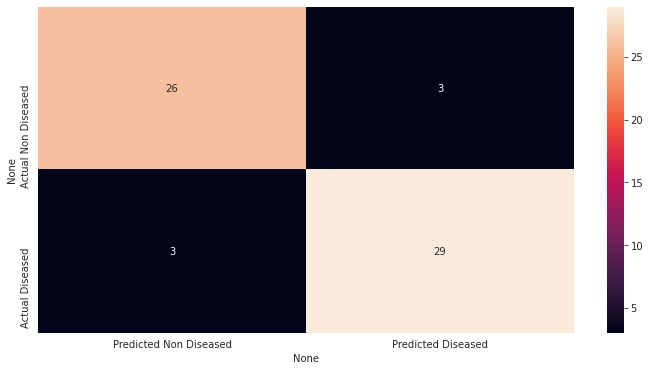

In [37]:
plt.figure(figsize=(12, 6))
pred = model.predict(x_test_scaled)
conf_df = pd.DataFrame(data=confusion_matrix(pred, y_test),
                   columns = [['Predicted Non Diseased', 'Predicted Diseased']],
                   index = [['Actual Non Diseased', 'Actual Diseased']]
                   )
sns.heatmap(conf_df, annot=True)
plt.show()

In [38]:
print('Train Score:', model.score(x_train_scaled, y_train))
print('Test Score:', model.score(x_test_scaled, y_test))
print('Recall Score:', recall_score(y_test, model.predict(x_test_scaled)))
print('Precision Score:', precision_score(y_test, model.predict(x_test_scaled)))
print('AUC Score:', roc_auc_score(y_test, model.predict(x_test_scaled)))
print('F1 Score:', f1_score(y_test, model.predict(x_test_scaled)), '\n')

4/4 [==============================] - 0s 587us/step - loss: 0.2332 - acc: 0.9256
Train Score: 0.9256198406219482
1/1 [==============================] - 0s 636us/step - loss: 0.3274 - acc: 0.9016
Test Score: 0.9016393423080444
Recall Score: 0.90625
Precision Score: 0.90625
AUC Score: 0.9014008620689655
F1 Score: 0.90625 



In [39]:
def model_for_decision_boundary(lr, neurons):
    model=Sequential()
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['acc'])
    return model
model_pca = KerasClassifier(build_fn=model_for_decision_boundary, epochs=50, lr=0.001, batch_size=32, neurons=64)
model_pca.fit(x_pca, y)

Epoch 1/50
10/10 [==============================] - 0s 534us/step - loss: 0.7547 - acc: 0.4026
Epoch 2/50
10/10 [==============================] - 0s 724us/step - loss: 0.6764 - acc: 0.6337
Epoch 3/50
10/10 [==============================] - 0s 543us/step - loss: 0.6118 - acc: 0.6997
Epoch 4/50
10/10 [==============================] - 0s 833us/step - loss: 0.5619 - acc: 0.7756
Epoch 5/50
10/10 [==============================] - 0s 563us/step - loss: 0.5210 - acc: 0.8086
Epoch 6/50
10/10 [==============================] - 0s 864us/step - loss: 0.4887 - acc: 0.8152
Epoch 7/50
10/10 [==============================] - 0s 630us/step - loss: 0.4649 - acc: 0.8152
Epoch 8/50
10/10 [==============================] - 0s 500us/step - loss: 0.4459 - acc: 0.8218
Epoch 9/50
10/10 [==============================] - 0s 683us/step - loss: 0.4323 - acc: 0.8218
Epoch 10/50
10/10 [==============================] - 0s 587us/step - loss: 0.4212 - acc: 0.8251
Epoch 11/50
10/10 [==============================

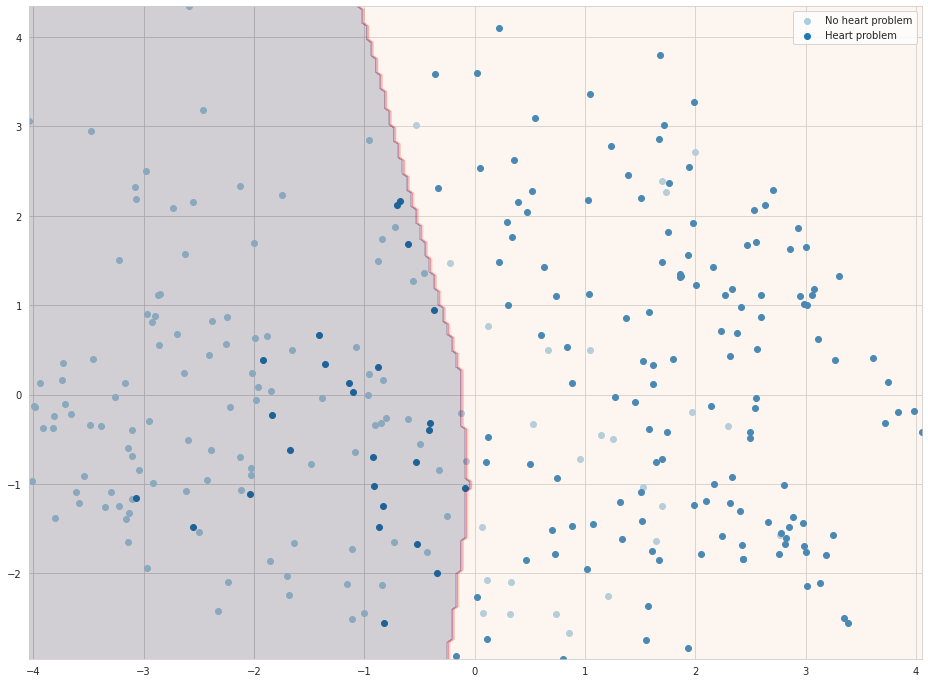

In [40]:
plt.figure(figsize=(16,12))
resolution = 200# 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(x_pca[:,0]), np.max(x_pca[:,0])
X2d_ymin, X2d_ymax = np.min(x_pca[:,1]), np.max(x_pca[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))
zz = model_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape((resolution, resolution))
plt.scatter(df_pca_no_heart_problem.iloc[:, 0], df_pca_no_heart_problem.iloc[:, 1], label='No heart problem')
plt.scatter(df_pca_heart_problem.iloc[:, 0], df_pca_heart_problem.iloc[:, 1], label='Heart problem')
plt.legend()
plt.contourf(xx, yy, zz, alpha=0.2)
plt.show()